# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5133374675157323 -2.6909381116309703
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [26]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [27]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [28]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [29]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [40]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [41]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [42]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [43]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [44]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [45]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 rate:0.0220 gloss:0.3409 dloss:1.2658 dlossR:0.5112 dlossQ:0.7545
Episode:1 meanR:10.5000 rate:0.0200 gloss:0.2893 dloss:1.2516 dlossR:0.4940 dlossQ:0.7576
Episode:2 meanR:10.3333 rate:0.0200 gloss:0.2439 dloss:1.2372 dlossR:0.4781 dlossQ:0.7591
Episode:3 meanR:10.0000 rate:0.0180 gloss:0.2123 dloss:1.2246 dlossR:0.4661 dlossQ:0.7585
Episode:4 meanR:9.8000 rate:0.0180 gloss:0.1701 dloss:1.2059 dlossR:0.4457 dlossQ:0.7602
Episode:5 meanR:9.8333 rate:0.0200 gloss:0.1222 dloss:1.1769 dlossR:0.4203 dlossQ:0.7566
Episode:6 meanR:9.7143 rate:0.0180 gloss:0.1103 dloss:1.1690 dlossR:0.4143 dlossQ:0.7547
Episode:7 meanR:9.7500 rate:0.0200 gloss:0.0479 dloss:1.1227 dlossR:0.3773 dlossQ:0.7454
Episode:8 meanR:9.6667 rate:0.0180 gloss:0.0362 dloss:1.1148 dlossR:0.3733 dlossQ:0.7416
Episode:9 meanR:9.7000 rate:0.0200 gloss:-0.0135 dloss:1.0677 dlossR:0.3433 dlossQ:0.7244
Episode:10 meanR:9.6364 rate:0.0180 gloss:-0.0437 dloss:1.0489 dlossR:0.3312 dlossQ:0.7176
Episode:11 mea

Episode:93 meanR:51.0426 rate:0.0860 gloss:0.0587 dloss:1.2634 dlossR:0.4548 dlossQ:0.8087
Episode:94 meanR:50.8316 rate:0.0620 gloss:0.0575 dloss:1.2421 dlossR:0.4321 dlossQ:0.8101
Episode:95 meanR:50.7396 rate:0.0840 gloss:0.0540 dloss:1.2597 dlossR:0.4513 dlossQ:0.8084
Episode:96 meanR:50.5979 rate:0.0740 gloss:0.0537 dloss:1.2530 dlossR:0.4441 dlossQ:0.8089
Episode:97 meanR:50.4184 rate:0.0660 gloss:0.0538 dloss:1.2472 dlossR:0.4383 dlossQ:0.8089
Episode:98 meanR:50.1717 rate:0.0520 gloss:0.0589 dloss:1.2353 dlossR:0.4266 dlossQ:0.8087
Episode:99 meanR:50.0200 rate:0.0700 gloss:0.0499 dloss:1.2489 dlossR:0.4397 dlossQ:0.8092
Episode:100 meanR:50.2500 rate:0.0680 gloss:0.0525 dloss:1.2477 dlossR:0.4392 dlossQ:0.8085
Episode:101 meanR:50.6100 rate:0.0920 gloss:0.0525 dloss:1.2696 dlossR:0.4626 dlossQ:0.8070
Episode:102 meanR:50.8600 rate:0.0700 gloss:0.0495 dloss:1.2482 dlossR:0.4396 dlossQ:0.8086
Episode:103 meanR:51.1200 rate:0.0700 gloss:0.0537 dloss:1.2496 dlossR:0.4413 dlossQ:0.

Episode:186 meanR:47.4200 rate:0.0700 gloss:0.0279 dloss:1.2633 dlossR:0.4615 dlossQ:0.8019
Episode:187 meanR:47.3300 rate:0.1060 gloss:0.0198 dloss:1.2933 dlossR:0.4943 dlossQ:0.7990
Episode:188 meanR:47.1000 rate:0.0700 gloss:0.0281 dloss:1.2596 dlossR:0.4564 dlossQ:0.8032
Episode:189 meanR:47.2600 rate:0.0980 gloss:0.0219 dloss:1.2812 dlossR:0.4803 dlossQ:0.8009
Episode:190 meanR:47.5400 rate:0.1520 gloss:0.0442 dloss:1.3244 dlossR:0.5281 dlossQ:0.7963
Episode:191 meanR:47.6300 rate:0.0820 gloss:0.0165 dloss:1.2683 dlossR:0.4660 dlossQ:0.8023
Episode:192 meanR:47.6700 rate:0.0840 gloss:0.0233 dloss:1.2724 dlossR:0.4711 dlossQ:0.8013
Episode:193 meanR:47.6400 rate:0.0800 gloss:0.0215 dloss:1.2657 dlossR:0.4631 dlossQ:0.8026
Episode:194 meanR:47.6600 rate:0.0660 gloss:0.0245 dloss:1.2517 dlossR:0.4472 dlossQ:0.8045
Episode:195 meanR:47.6700 rate:0.0860 gloss:0.0232 dloss:1.2692 dlossR:0.4658 dlossQ:0.8034
Episode:196 meanR:47.8500 rate:0.1100 gloss:0.0169 dloss:1.2911 dlossR:0.4898 dl

Episode:276 meanR:53.0500 rate:0.1980 gloss:0.0333 dloss:1.3584 dlossR:0.5747 dlossQ:0.7837
Episode:277 meanR:52.5800 rate:0.0640 gloss:0.0262 dloss:1.2634 dlossR:0.4659 dlossQ:0.7975
Episode:278 meanR:52.5800 rate:0.0760 gloss:0.0213 dloss:1.2778 dlossR:0.4846 dlossQ:0.7933
Episode:279 meanR:52.4200 rate:0.0780 gloss:0.0262 dloss:1.2852 dlossR:0.4937 dlossQ:0.7915
Episode:280 meanR:52.6700 rate:0.1220 gloss:0.0137 dloss:1.3162 dlossR:0.5284 dlossQ:0.7879
Episode:281 meanR:53.2000 rate:0.1860 gloss:0.0321 dloss:1.3542 dlossR:0.5744 dlossQ:0.7798
Episode:282 meanR:53.2000 rate:0.1340 gloss:0.0143 dloss:1.3239 dlossR:0.5388 dlossQ:0.7851
Episode:283 meanR:52.9800 rate:0.1260 gloss:0.0121 dloss:1.3168 dlossR:0.5298 dlossQ:0.7871
Episode:284 meanR:53.4800 rate:0.2000 gloss:0.0341 dloss:1.3629 dlossR:0.5874 dlossQ:0.7754
Episode:285 meanR:53.5200 rate:0.0980 gloss:0.0191 dloss:1.2972 dlossR:0.5076 dlossQ:0.7896
Episode:286 meanR:53.6600 rate:0.0980 gloss:0.0177 dloss:1.3009 dlossR:0.5136 dl

Episode:368 meanR:70.6500 rate:0.0780 gloss:0.0206 dloss:1.2965 dlossR:0.5088 dlossQ:0.7877
Episode:369 meanR:70.6100 rate:0.1040 gloss:0.0141 dloss:1.3068 dlossR:0.5154 dlossQ:0.7914
Episode:370 meanR:71.0700 rate:0.1740 gloss:0.0159 dloss:1.3574 dlossR:0.5853 dlossQ:0.7721
Episode:371 meanR:71.1200 rate:0.1120 gloss:0.0150 dloss:1.3096 dlossR:0.5128 dlossQ:0.7968
Episode:372 meanR:70.8700 rate:0.1120 gloss:0.0129 dloss:1.3077 dlossR:0.5076 dlossQ:0.8001
Episode:373 meanR:71.2700 rate:0.2820 gloss:0.0118 dloss:1.4008 dlossR:0.6256 dlossQ:0.7752
Episode:374 meanR:71.4000 rate:0.1080 gloss:0.0139 dloss:1.3099 dlossR:0.5146 dlossQ:0.7953
Episode:375 meanR:71.0600 rate:0.1100 gloss:0.0187 dloss:1.3136 dlossR:0.5249 dlossQ:0.7887
Episode:376 meanR:70.6100 rate:0.1080 gloss:0.0167 dloss:1.3118 dlossR:0.5256 dlossQ:0.7862
Episode:377 meanR:70.8300 rate:0.1080 gloss:0.0145 dloss:1.3180 dlossR:0.5378 dlossQ:0.7802
Episode:378 meanR:71.0500 rate:0.1200 gloss:0.0203 dloss:1.3259 dlossR:0.5459 dl

Episode:459 meanR:55.1000 rate:0.0940 gloss:0.0059 dloss:1.2733 dlossR:0.4700 dlossQ:0.8033
Episode:460 meanR:54.9500 rate:0.0600 gloss:0.0047 dloss:1.2389 dlossR:0.4338 dlossQ:0.8050
Episode:461 meanR:54.6700 rate:0.0900 gloss:0.0022 dloss:1.2753 dlossR:0.4704 dlossQ:0.8049
Episode:462 meanR:54.4400 rate:0.0940 gloss:0.0053 dloss:1.2744 dlossR:0.4697 dlossQ:0.8047
Episode:463 meanR:54.0400 rate:0.0620 gloss:0.0065 dloss:1.2323 dlossR:0.4232 dlossQ:0.8090
Episode:464 meanR:54.3000 rate:0.1460 gloss:0.0186 dloss:1.3162 dlossR:0.5154 dlossQ:0.8009
Episode:465 meanR:54.2400 rate:0.1080 gloss:0.0020 dloss:1.2786 dlossR:0.4721 dlossQ:0.8065
Episode:466 meanR:54.1400 rate:0.1100 gloss:0.0026 dloss:1.2914 dlossR:0.4901 dlossQ:0.8013
Episode:467 meanR:53.8200 rate:0.0940 gloss:0.0047 dloss:1.2758 dlossR:0.4728 dlossQ:0.8029
Episode:468 meanR:54.1900 rate:0.1520 gloss:0.0213 dloss:1.3281 dlossR:0.5354 dlossQ:0.7928
Episode:469 meanR:54.0000 rate:0.0660 gloss:0.0080 dloss:1.2586 dlossR:0.4578 dl

Episode:550 meanR:46.7000 rate:0.1340 gloss:0.0154 dloss:1.3176 dlossR:0.5260 dlossQ:0.7916
Episode:551 meanR:46.3300 rate:0.0940 gloss:0.0052 dloss:1.2795 dlossR:0.4802 dlossQ:0.7992
Episode:552 meanR:46.5200 rate:0.1320 gloss:0.0035 dloss:1.3155 dlossR:0.5228 dlossQ:0.7927
Episode:553 meanR:46.6600 rate:0.1040 gloss:0.0067 dloss:1.2948 dlossR:0.5004 dlossQ:0.7944
Episode:554 meanR:46.6600 rate:0.0660 gloss:0.0062 dloss:1.2586 dlossR:0.4577 dlossQ:0.8009
Episode:555 meanR:46.7700 rate:0.0960 gloss:0.0049 dloss:1.2927 dlossR:0.4993 dlossQ:0.7933
Episode:556 meanR:46.8700 rate:0.0820 gloss:0.0085 dloss:1.2762 dlossR:0.4783 dlossQ:0.7978
Episode:557 meanR:47.2000 rate:0.1280 gloss:0.0040 dloss:1.3103 dlossR:0.5154 dlossQ:0.7949
Episode:558 meanR:47.2000 rate:0.1340 gloss:0.0022 dloss:1.3124 dlossR:0.5168 dlossQ:0.7956
Episode:559 meanR:47.1900 rate:0.0920 gloss:0.0081 dloss:1.2801 dlossR:0.4806 dlossQ:0.7994
Episode:560 meanR:47.7700 rate:0.1760 gloss:0.0159 dloss:1.3451 dlossR:0.5565 dl

Episode:640 meanR:58.3000 rate:0.1000 gloss:0.0106 dloss:1.3037 dlossR:0.5171 dlossQ:0.7866
Episode:641 meanR:58.1000 rate:0.1040 gloss:0.0216 dloss:1.2997 dlossR:0.5074 dlossQ:0.7922
Episode:642 meanR:58.6300 rate:0.1800 gloss:0.0034 dloss:1.3470 dlossR:0.5601 dlossQ:0.7869
Episode:643 meanR:58.8900 rate:0.1580 gloss:0.0083 dloss:1.3316 dlossR:0.5404 dlossQ:0.7913
Episode:644 meanR:58.9900 rate:0.1060 gloss:0.0156 dloss:1.2997 dlossR:0.5073 dlossQ:0.7924
Episode:645 meanR:59.0300 rate:0.0980 gloss:0.0078 dloss:1.2940 dlossR:0.5004 dlossQ:0.7936
Episode:646 meanR:59.2300 rate:0.1340 gloss:0.0107 dloss:1.3225 dlossR:0.5360 dlossQ:0.7865
Episode:647 meanR:59.5300 rate:0.1680 gloss:0.0096 dloss:1.3429 dlossR:0.5597 dlossQ:0.7833
Episode:648 meanR:59.8800 rate:0.1480 gloss:0.0137 dloss:1.3328 dlossR:0.5499 dlossQ:0.7829
Episode:649 meanR:60.1400 rate:0.2100 gloss:0.0076 dloss:1.3673 dlossR:0.5949 dlossQ:0.7724
Episode:650 meanR:60.0200 rate:0.1100 gloss:0.0162 dloss:1.3198 dlossR:0.5419 dl

Episode:732 meanR:72.3800 rate:0.1300 gloss:0.0175 dloss:1.3314 dlossR:0.5553 dlossQ:0.7761
Episode:733 meanR:72.5500 rate:0.1280 gloss:0.0055 dloss:1.3288 dlossR:0.5504 dlossQ:0.7784
Episode:734 meanR:72.5200 rate:0.1060 gloss:0.0155 dloss:1.3139 dlossR:0.5298 dlossQ:0.7840
Episode:735 meanR:72.6200 rate:0.1160 gloss:0.0060 dloss:1.3090 dlossR:0.5176 dlossQ:0.7915
Episode:736 meanR:71.9300 rate:0.1000 gloss:0.0110 dloss:1.2888 dlossR:0.4908 dlossQ:0.7980
Episode:737 meanR:71.9900 rate:0.1480 gloss:0.0039 dloss:1.3211 dlossR:0.5228 dlossQ:0.7983
Episode:738 meanR:72.1000 rate:0.1500 gloss:0.0066 dloss:1.3184 dlossR:0.5142 dlossQ:0.8042
Episode:739 meanR:72.2900 rate:0.1500 gloss:0.0062 dloss:1.3216 dlossR:0.5226 dlossQ:0.7990
Episode:740 meanR:72.3500 rate:0.1120 gloss:0.0070 dloss:1.3013 dlossR:0.5049 dlossQ:0.7964
Episode:741 meanR:72.4000 rate:0.1140 gloss:0.0092 dloss:1.3067 dlossR:0.5147 dlossQ:0.7920
Episode:742 meanR:72.1500 rate:0.1300 gloss:0.0082 dloss:1.3218 dlossR:0.5353 dl

Episode:823 meanR:81.5700 rate:0.2260 gloss:0.0172 dloss:1.3831 dlossR:0.6583 dlossQ:0.7248
Episode:824 meanR:81.4400 rate:0.1300 gloss:0.0065 dloss:1.3417 dlossR:0.5763 dlossQ:0.7654
Episode:825 meanR:81.5700 rate:0.1320 gloss:0.0125 dloss:1.3405 dlossR:0.5699 dlossQ:0.7706
Episode:826 meanR:81.4700 rate:0.1160 gloss:0.0052 dloss:1.3231 dlossR:0.5404 dlossQ:0.7827
Episode:827 meanR:82.1300 rate:0.2480 gloss:0.0108 dloss:1.3854 dlossR:0.6261 dlossQ:0.7593
Episode:828 meanR:82.4200 rate:0.1680 gloss:0.0018 dloss:1.3412 dlossR:0.5516 dlossQ:0.7895
Episode:829 meanR:82.4100 rate:0.1240 gloss:0.0049 dloss:1.3137 dlossR:0.5204 dlossQ:0.7933
Episode:830 meanR:82.3700 rate:0.0880 gloss:0.0083 dloss:1.2922 dlossR:0.4986 dlossQ:0.7936
Episode:831 meanR:83.0900 rate:0.2680 gloss:0.0068 dloss:1.3951 dlossR:0.6111 dlossQ:0.7840
Episode:832 meanR:82.9000 rate:0.0920 gloss:0.0080 dloss:1.3041 dlossR:0.5191 dlossQ:0.7850
Episode:833 meanR:82.9400 rate:0.1360 gloss:0.0077 dloss:1.3354 dlossR:0.5599 dl

Episode:917 meanR:60.0800 rate:0.0840 gloss:0.0025 dloss:1.2579 dlossR:0.4500 dlossQ:0.8079
Episode:918 meanR:59.8600 rate:0.0800 gloss:0.0029 dloss:1.2536 dlossR:0.4452 dlossQ:0.8084
Episode:919 meanR:59.3200 rate:0.0900 gloss:0.0028 dloss:1.2613 dlossR:0.4544 dlossQ:0.8069
Episode:920 meanR:59.1300 rate:0.1500 gloss:0.0091 dloss:1.3235 dlossR:0.5270 dlossQ:0.7965
Episode:921 meanR:59.2700 rate:0.1460 gloss:0.0017 dloss:1.3219 dlossR:0.5265 dlossQ:0.7953
Episode:922 meanR:59.1400 rate:0.0860 gloss:0.0061 dloss:1.2788 dlossR:0.4809 dlossQ:0.7980
Episode:923 meanR:58.4000 rate:0.0780 gloss:0.0040 dloss:1.2771 dlossR:0.4807 dlossQ:0.7964
Episode:924 meanR:58.1300 rate:0.0760 gloss:0.0022 dloss:1.2697 dlossR:0.4700 dlossQ:0.7997
Episode:925 meanR:58.0300 rate:0.1120 gloss:0.0015 dloss:1.3041 dlossR:0.5102 dlossQ:0.7939
Episode:926 meanR:58.0800 rate:0.1260 gloss:0.0063 dloss:1.3160 dlossR:0.5236 dlossQ:0.7924
Episode:927 meanR:57.2400 rate:0.0800 gloss:0.0014 dloss:1.2748 dlossR:0.4759 dl

Episode:1008 meanR:48.9500 rate:0.0620 gloss:0.0024 dloss:1.2561 dlossR:0.4544 dlossQ:0.8017
Episode:1009 meanR:48.6400 rate:0.0620 gloss:0.0095 dloss:1.2582 dlossR:0.4570 dlossQ:0.8012
Episode:1010 meanR:48.6900 rate:0.1000 gloss:0.0032 dloss:1.2928 dlossR:0.4971 dlossQ:0.7957
Episode:1011 meanR:48.6200 rate:0.0880 gloss:0.0039 dloss:1.2777 dlossR:0.4779 dlossQ:0.7998
Episode:1012 meanR:48.6400 rate:0.0660 gloss:0.0005 dloss:1.2524 dlossR:0.4445 dlossQ:0.8079
Episode:1013 meanR:48.5900 rate:0.0700 gloss:0.0010 dloss:1.2563 dlossR:0.4484 dlossQ:0.8079
Episode:1014 meanR:48.8200 rate:0.1180 gloss:0.0042 dloss:1.2941 dlossR:0.4910 dlossQ:0.8031
Episode:1015 meanR:48.8400 rate:0.0960 gloss:0.0055 dloss:1.2797 dlossR:0.4783 dlossQ:0.8014
Episode:1016 meanR:48.7600 rate:0.0940 gloss:0.0015 dloss:1.2806 dlossR:0.4793 dlossQ:0.8013
Episode:1017 meanR:48.7100 rate:0.0740 gloss:0.0048 dloss:1.2638 dlossR:0.4620 dlossQ:0.8017
Episode:1018 meanR:48.8700 rate:0.1120 gloss:0.0008 dloss:1.2875 dloss

Episode:1097 meanR:60.2400 rate:0.1000 gloss:0.0144 dloss:1.3156 dlossR:0.5379 dlossQ:0.7777
Episode:1098 meanR:60.3000 rate:0.1300 gloss:0.0155 dloss:1.3271 dlossR:0.5480 dlossQ:0.7791
Episode:1099 meanR:60.7700 rate:0.1600 gloss:0.0105 dloss:1.3404 dlossR:0.5582 dlossQ:0.7822
Episode:1100 meanR:60.7100 rate:0.1060 gloss:0.0025 dloss:1.3004 dlossR:0.5077 dlossQ:0.7927
Episode:1101 meanR:61.1500 rate:0.1660 gloss:0.0038 dloss:1.3373 dlossR:0.5458 dlossQ:0.7915
Episode:1102 meanR:61.3900 rate:0.1220 gloss:0.0052 dloss:1.3073 dlossR:0.5120 dlossQ:0.7953
Episode:1103 meanR:61.7500 rate:0.1680 gloss:0.0103 dloss:1.3581 dlossR:0.5961 dlossQ:0.7620
Episode:1104 meanR:61.8800 rate:0.1020 gloss:0.0109 dloss:1.2983 dlossR:0.5056 dlossQ:0.7927
Episode:1105 meanR:62.1600 rate:0.1460 gloss:0.0053 dloss:1.3245 dlossR:0.5326 dlossQ:0.7920
Episode:1106 meanR:63.0400 rate:0.2480 gloss:0.0067 dloss:1.3834 dlossR:0.5969 dlossQ:0.7865
Episode:1107 meanR:62.9700 rate:0.2240 gloss:0.0078 dloss:1.3766 dloss

Episode:1186 meanR:73.2100 rate:0.2860 gloss:0.0063 dloss:1.3968 dlossR:0.6357 dlossQ:0.7612
Episode:1187 meanR:72.9800 rate:0.1140 gloss:0.0039 dloss:1.3325 dlossR:0.5651 dlossQ:0.7675
Episode:1188 meanR:73.5100 rate:0.2080 gloss:0.0051 dloss:1.3720 dlossR:0.6168 dlossQ:0.7552
Episode:1189 meanR:73.4400 rate:0.1260 gloss:0.0097 dloss:1.3428 dlossR:0.5811 dlossQ:0.7616
Episode:1190 meanR:73.6400 rate:0.1780 gloss:0.0121 dloss:1.3759 dlossR:0.6490 dlossQ:0.7269
Episode:1191 meanR:73.2700 rate:0.1120 gloss:0.0129 dloss:1.3218 dlossR:0.5421 dlossQ:0.7797
Episode:1192 meanR:74.0100 rate:0.3080 gloss:0.0043 dloss:1.4109 dlossR:0.6403 dlossQ:0.7706
Episode:1193 meanR:73.7800 rate:0.1040 gloss:0.0114 dloss:1.3163 dlossR:0.5349 dlossQ:0.7813
Episode:1194 meanR:73.5500 rate:0.1020 gloss:0.0083 dloss:1.3137 dlossR:0.5340 dlossQ:0.7797
Episode:1195 meanR:73.1500 rate:0.1140 gloss:0.0033 dloss:1.3224 dlossR:0.5445 dlossQ:0.7779
Episode:1196 meanR:73.9200 rate:0.3040 gloss:0.0073 dloss:1.4045 dloss

Episode:1276 meanR:73.0700 rate:0.1140 gloss:0.0026 dloss:1.2985 dlossR:0.4989 dlossQ:0.7996
Episode:1277 meanR:73.3500 rate:0.1600 gloss:0.0035 dloss:1.3337 dlossR:0.5397 dlossQ:0.7940
Episode:1278 meanR:73.4600 rate:0.1420 gloss:0.0041 dloss:1.3269 dlossR:0.5337 dlossQ:0.7932
Episode:1279 meanR:72.3800 rate:0.0820 gloss:0.0127 dloss:1.2884 dlossR:0.4942 dlossQ:0.7942
Episode:1280 meanR:72.5400 rate:0.1160 gloss:0.0029 dloss:1.3133 dlossR:0.5220 dlossQ:0.7913
Episode:1281 meanR:72.6500 rate:0.1600 gloss:0.0058 dloss:1.3439 dlossR:0.5671 dlossQ:0.7769
Episode:1282 meanR:72.4300 rate:0.2200 gloss:0.0044 dloss:1.3796 dlossR:0.6443 dlossQ:0.7354
Episode:1283 meanR:72.1000 rate:0.1380 gloss:0.0057 dloss:1.3411 dlossR:0.5702 dlossQ:0.7709
Episode:1284 meanR:72.2100 rate:0.1460 gloss:0.0093 dloss:1.3515 dlossR:0.5884 dlossQ:0.7631
Episode:1285 meanR:72.1600 rate:0.1360 gloss:0.0127 dloss:1.3409 dlossR:0.5734 dlossQ:0.7675
Episode:1286 meanR:71.2900 rate:0.1120 gloss:0.0115 dloss:1.3216 dloss

Episode:1366 meanR:69.7200 rate:0.1860 gloss:0.0094 dloss:1.3748 dlossR:0.6414 dlossQ:0.7334
Episode:1367 meanR:69.9100 rate:0.1720 gloss:0.0041 dloss:1.3481 dlossR:0.5699 dlossQ:0.7781
Episode:1368 meanR:69.9700 rate:0.1080 gloss:0.0040 dloss:1.3042 dlossR:0.5145 dlossQ:0.7897
Episode:1369 meanR:70.0900 rate:0.1180 gloss:0.0112 dloss:1.3143 dlossR:0.5291 dlossQ:0.7852
Episode:1370 meanR:70.2800 rate:0.1300 gloss:0.0062 dloss:1.3190 dlossR:0.5316 dlossQ:0.7874
Episode:1371 meanR:70.6500 rate:0.1740 gloss:0.0057 dloss:1.3466 dlossR:0.5643 dlossQ:0.7823
Episode:1372 meanR:70.7900 rate:0.1540 gloss:0.0042 dloss:1.3341 dlossR:0.5487 dlossQ:0.7854
Episode:1373 meanR:70.9800 rate:0.1720 gloss:0.0081 dloss:1.3670 dlossR:0.6233 dlossQ:0.7437
Episode:1374 meanR:71.4100 rate:0.1860 gloss:0.0027 dloss:1.3534 dlossR:0.5733 dlossQ:0.7801
Episode:1375 meanR:71.2400 rate:0.1740 gloss:0.0122 dloss:1.3461 dlossR:0.5633 dlossQ:0.7827
Episode:1376 meanR:71.8900 rate:0.2440 gloss:0.0045 dloss:1.3814 dloss

Episode:1457 meanR:77.7600 rate:0.1300 gloss:0.0044 dloss:1.3230 dlossR:0.5379 dlossQ:0.7852
Episode:1458 meanR:77.8500 rate:0.1240 gloss:0.0008 dloss:1.3149 dlossR:0.5259 dlossQ:0.7890
Episode:1459 meanR:77.4000 rate:0.0880 gloss:0.0067 dloss:1.2846 dlossR:0.4886 dlossQ:0.7960
Episode:1460 meanR:76.4600 rate:0.1200 gloss:0.0036 dloss:1.3051 dlossR:0.5093 dlossQ:0.7958
Episode:1461 meanR:76.1800 rate:0.1140 gloss:0.0042 dloss:1.3034 dlossR:0.5082 dlossQ:0.7952
Episode:1462 meanR:75.4000 rate:0.0920 gloss:0.0039 dloss:1.2867 dlossR:0.4907 dlossQ:0.7960
Episode:1463 meanR:75.8000 rate:0.1760 gloss:0.0041 dloss:1.3447 dlossR:0.5567 dlossQ:0.7880
Episode:1464 meanR:75.9100 rate:0.1400 gloss:0.0023 dloss:1.3250 dlossR:0.5368 dlossQ:0.7881
Episode:1465 meanR:76.1100 rate:0.1860 gloss:0.0114 dloss:1.3556 dlossR:0.5764 dlossQ:0.7791
Episode:1466 meanR:75.6000 rate:0.0840 gloss:0.0009 dloss:1.2888 dlossR:0.4973 dlossQ:0.7915
Episode:1467 meanR:75.3000 rate:0.1120 gloss:0.0061 dloss:1.3095 dloss

Episode:1546 meanR:62.6200 rate:0.1660 gloss:0.0014 dloss:1.3566 dlossR:0.5916 dlossQ:0.7651
Episode:1547 meanR:62.5300 rate:0.0980 gloss:0.0081 dloss:1.3135 dlossR:0.5298 dlossQ:0.7837
Episode:1548 meanR:62.5800 rate:0.0940 gloss:0.0002 dloss:1.3051 dlossR:0.5185 dlossQ:0.7866
Episode:1549 meanR:62.4900 rate:0.1340 gloss:0.0017 dloss:1.3271 dlossR:0.5452 dlossQ:0.7819
Episode:1550 meanR:62.7600 rate:0.1540 gloss:0.0043 dloss:1.3373 dlossR:0.5562 dlossQ:0.7811
Episode:1551 meanR:62.9200 rate:0.1700 gloss:0.0018 dloss:1.3460 dlossR:0.5653 dlossQ:0.7807
Episode:1552 meanR:63.1500 rate:0.2380 gloss:0.0059 dloss:1.3803 dlossR:0.6049 dlossQ:0.7754
Episode:1553 meanR:63.6700 rate:0.1920 gloss:0.0039 dloss:1.3620 dlossR:0.5854 dlossQ:0.7766
Episode:1554 meanR:63.7300 rate:0.1080 gloss:0.0043 dloss:1.3118 dlossR:0.5241 dlossQ:0.7878
Episode:1555 meanR:63.8800 rate:0.1480 gloss:0.0051 dloss:1.3318 dlossR:0.5466 dlossQ:0.7851
Episode:1556 meanR:63.7600 rate:0.1060 gloss:0.0088 dloss:1.3060 dloss

Episode:1637 meanR:86.9200 rate:0.3080 gloss:0.0053 dloss:1.4120 dlossR:0.6695 dlossQ:0.7425
Episode:1638 meanR:87.0800 rate:0.1480 gloss:0.0106 dloss:1.3788 dlossR:0.6526 dlossQ:0.7262
Episode:1639 meanR:86.9900 rate:0.1380 gloss:0.0140 dloss:1.3762 dlossR:0.6567 dlossQ:0.7195
Episode:1640 meanR:86.5000 rate:0.1400 gloss:0.0012 dloss:1.3745 dlossR:0.6525 dlossQ:0.7219
Episode:1641 meanR:87.7500 rate:0.3920 gloss:0.0112 dloss:1.3873 dlossR:0.6992 dlossQ:0.6881
Episode:1642 meanR:87.0300 rate:0.1380 gloss:0.0029 dloss:1.3638 dlossR:0.6242 dlossQ:0.7395
Episode:1643 meanR:86.9800 rate:0.1320 gloss:0.0045 dloss:1.3545 dlossR:0.6065 dlossQ:0.7479
Episode:1644 meanR:87.1400 rate:0.1220 gloss:0.0041 dloss:1.3345 dlossR:0.5669 dlossQ:0.7675
Episode:1645 meanR:87.3500 rate:0.1400 gloss:0.0055 dloss:1.3383 dlossR:0.5571 dlossQ:0.7812
Episode:1646 meanR:87.2000 rate:0.1360 gloss:0.0098 dloss:1.3340 dlossR:0.5431 dlossQ:0.7909
Episode:1647 meanR:87.4600 rate:0.1500 gloss:0.0027 dloss:1.3355 dloss

Episode:1725 meanR:110.0500 rate:0.2720 gloss:0.0112 dloss:1.3900 dlossR:0.6908 dlossQ:0.6992
Episode:1726 meanR:110.5200 rate:0.2560 gloss:0.0098 dloss:1.3971 dlossR:0.7011 dlossQ:0.6960
Episode:1727 meanR:110.9800 rate:0.1940 gloss:0.0085 dloss:1.4223 dlossR:0.7461 dlossQ:0.6762
Episode:1728 meanR:110.7700 rate:0.2420 gloss:0.0087 dloss:1.3917 dlossR:0.6897 dlossQ:0.7020
Episode:1729 meanR:112.5000 rate:0.5040 gloss:0.0066 dloss:1.4067 dlossR:0.6944 dlossQ:0.7123
Episode:1730 meanR:111.5500 rate:0.2260 gloss:0.0045 dloss:1.3851 dlossR:0.6788 dlossQ:0.7063
Episode:1731 meanR:110.8400 rate:0.1900 gloss:0.0125 dloss:1.3851 dlossR:0.6763 dlossQ:0.7088
Episode:1732 meanR:111.0900 rate:0.1860 gloss:0.0025 dloss:1.3843 dlossR:0.6728 dlossQ:0.7115
Episode:1733 meanR:111.4100 rate:0.3360 gloss:0.0107 dloss:1.3991 dlossR:0.6795 dlossQ:0.7196
Episode:1734 meanR:111.3100 rate:0.1600 gloss:0.0072 dloss:1.3817 dlossR:0.6765 dlossQ:0.7052
Episode:1735 meanR:111.0200 rate:0.1700 gloss:0.0126 dloss:1

Episode:1813 meanR:108.6000 rate:0.1400 gloss:0.0010 dloss:1.3513 dlossR:0.5969 dlossQ:0.7545
Episode:1814 meanR:107.5200 rate:0.1900 gloss:0.0016 dloss:1.3730 dlossR:0.6264 dlossQ:0.7466
Episode:1815 meanR:106.6800 rate:0.2060 gloss:0.0027 dloss:1.3743 dlossR:0.6022 dlossQ:0.7722
Episode:1816 meanR:106.5500 rate:0.1780 gloss:0.0035 dloss:1.3628 dlossR:0.5960 dlossQ:0.7669
Episode:1817 meanR:106.3000 rate:0.3460 gloss:0.0047 dloss:1.4193 dlossR:0.6574 dlossQ:0.7619
Episode:1818 meanR:106.5500 rate:0.3180 gloss:0.0107 dloss:1.4008 dlossR:0.6570 dlossQ:0.7438
Episode:1819 meanR:106.4700 rate:0.1580 gloss:0.0072 dloss:1.3775 dlossR:0.6463 dlossQ:0.7312
Episode:1820 meanR:106.6000 rate:0.2120 gloss:0.0031 dloss:1.3952 dlossR:0.6741 dlossQ:0.7210
Episode:1821 meanR:104.8400 rate:0.1520 gloss:0.0031 dloss:1.3908 dlossR:0.6734 dlossQ:0.7174
Episode:1822 meanR:104.3900 rate:0.1520 gloss:0.0051 dloss:1.3808 dlossR:0.6633 dlossQ:0.7175
Episode:1823 meanR:104.4500 rate:0.2420 gloss:0.0050 dloss:1

Episode:1901 meanR:112.5100 rate:0.3100 gloss:0.0213 dloss:1.3958 dlossR:0.6737 dlossQ:0.7221
Episode:1902 meanR:113.6900 rate:0.3840 gloss:0.0237 dloss:1.3979 dlossR:0.6881 dlossQ:0.7098
Episode:1903 meanR:113.9500 rate:0.2140 gloss:0.0113 dloss:1.3856 dlossR:0.6772 dlossQ:0.7084
Episode:1904 meanR:115.3400 rate:0.4580 gloss:0.0135 dloss:1.3796 dlossR:0.6980 dlossQ:0.6816
Episode:1905 meanR:115.1000 rate:0.1960 gloss:0.0102 dloss:1.3861 dlossR:0.6846 dlossQ:0.7015
Episode:1906 meanR:116.3200 rate:0.3840 gloss:0.0053 dloss:1.3899 dlossR:0.6941 dlossQ:0.6958
Episode:1907 meanR:116.6300 rate:0.2440 gloss:0.0071 dloss:1.3898 dlossR:0.7015 dlossQ:0.6883
Episode:1908 meanR:117.2200 rate:0.3320 gloss:0.0062 dloss:1.3836 dlossR:0.7193 dlossQ:0.6643
Episode:1909 meanR:118.7900 rate:0.4560 gloss:0.0129 dloss:1.3682 dlossR:0.7040 dlossQ:0.6642
Episode:1910 meanR:118.4700 rate:0.2580 gloss:0.0039 dloss:1.3932 dlossR:0.7168 dlossQ:0.6764
Episode:1911 meanR:119.2800 rate:0.2880 gloss:0.0078 dloss:1

Episode:1991 meanR:137.4300 rate:0.1740 gloss:0.0027 dloss:1.3884 dlossR:0.6586 dlossQ:0.7298
Episode:1992 meanR:137.5700 rate:0.1580 gloss:0.0072 dloss:1.3787 dlossR:0.6386 dlossQ:0.7401
Episode:1993 meanR:137.0900 rate:0.1660 gloss:0.0060 dloss:1.3724 dlossR:0.6289 dlossQ:0.7435
Episode:1994 meanR:136.9100 rate:0.1400 gloss:0.0032 dloss:1.3613 dlossR:0.6195 dlossQ:0.7418
Episode:1995 meanR:136.2600 rate:0.2080 gloss:0.0004 dloss:1.3792 dlossR:0.6484 dlossQ:0.7308
Episode:1996 meanR:136.9800 rate:0.3220 gloss:0.0027 dloss:1.4053 dlossR:0.6597 dlossQ:0.7456
Episode:1997 meanR:138.3900 rate:0.4760 gloss:0.0060 dloss:1.4391 dlossR:0.6962 dlossQ:0.7429
Episode:1998 meanR:137.3900 rate:0.1460 gloss:0.0049 dloss:1.3809 dlossR:0.6310 dlossQ:0.7500
Episode:1999 meanR:138.7500 rate:0.5220 gloss:0.0058 dloss:1.4254 dlossR:0.7027 dlossQ:0.7227
Episode:2000 meanR:138.7400 rate:0.1540 gloss:0.0008 dloss:1.3972 dlossR:0.6580 dlossQ:0.7392
Episode:2001 meanR:138.0800 rate:0.1780 gloss:0.0104 dloss:1

Episode:2079 meanR:103.9100 rate:0.1400 gloss:0.0010 dloss:1.3524 dlossR:0.5944 dlossQ:0.7580
Episode:2080 meanR:103.2200 rate:0.1000 gloss:0.0085 dloss:1.3370 dlossR:0.5758 dlossQ:0.7613
Episode:2081 meanR:103.0200 rate:0.1060 gloss:0.0013 dloss:1.3388 dlossR:0.5804 dlossQ:0.7585
Episode:2082 meanR:102.7300 rate:0.1640 gloss:0.0017 dloss:1.3598 dlossR:0.6080 dlossQ:0.7519
Episode:2083 meanR:100.4900 rate:0.1180 gloss:0.0012 dloss:1.3403 dlossR:0.5800 dlossQ:0.7603
Episode:2084 meanR:99.0000 rate:0.1420 gloss:0.0100 dloss:1.3497 dlossR:0.5913 dlossQ:0.7585
Episode:2085 meanR:99.4500 rate:0.2480 gloss:0.0023 dloss:1.3845 dlossR:0.6324 dlossQ:0.7522
Episode:2086 meanR:99.2500 rate:0.1480 gloss:0.0004 dloss:1.3507 dlossR:0.5897 dlossQ:0.7610
Episode:2087 meanR:98.8800 rate:0.1260 gloss:0.0036 dloss:1.3402 dlossR:0.5759 dlossQ:0.7643
Episode:2088 meanR:98.8500 rate:0.1220 gloss:0.0008 dloss:1.3390 dlossR:0.5753 dlossQ:0.7637
Episode:2089 meanR:98.4900 rate:0.1260 gloss:0.0006 dloss:1.3391 

Episode:2169 meanR:71.0500 rate:0.1020 gloss:0.0068 dloss:1.3076 dlossR:0.5204 dlossQ:0.7872
Episode:2170 meanR:70.5400 rate:0.0940 gloss:0.0011 dloss:1.2937 dlossR:0.4999 dlossQ:0.7938
Episode:2171 meanR:70.3500 rate:0.1020 gloss:0.0042 dloss:1.3030 dlossR:0.5130 dlossQ:0.7900
Episode:2172 meanR:69.7700 rate:0.0920 gloss:0.0007 dloss:1.2927 dlossR:0.5003 dlossQ:0.7924
Episode:2173 meanR:69.9500 rate:0.1880 gloss:0.0015 dloss:1.3535 dlossR:0.5691 dlossQ:0.7844
Episode:2174 meanR:69.8500 rate:0.0840 gloss:0.0024 dloss:1.2785 dlossR:0.4802 dlossQ:0.7983
Episode:2175 meanR:69.6300 rate:0.1060 gloss:0.0042 dloss:1.3045 dlossR:0.5120 dlossQ:0.7925
Episode:2176 meanR:69.1000 rate:0.0900 gloss:0.0045 dloss:1.2890 dlossR:0.4934 dlossQ:0.7957
Episode:2177 meanR:68.8700 rate:0.1220 gloss:0.0014 dloss:1.3119 dlossR:0.5189 dlossQ:0.7931
Episode:2178 meanR:68.9400 rate:0.1620 gloss:0.0032 dloss:1.3360 dlossR:0.5437 dlossQ:0.7923
Episode:2179 meanR:68.9900 rate:0.1500 gloss:0.0007 dloss:1.3322 dloss

Episode:2258 meanR:65.4200 rate:0.0960 gloss:0.0004 dloss:1.2917 dlossR:0.4968 dlossQ:0.7948
Episode:2259 meanR:64.8600 rate:0.0980 gloss:0.0005 dloss:1.3019 dlossR:0.5134 dlossQ:0.7885
Episode:2260 meanR:64.9700 rate:0.1120 gloss:0.0006 dloss:1.3037 dlossR:0.5116 dlossQ:0.7921
Episode:2261 meanR:64.8800 rate:0.0880 gloss:0.0003 dloss:1.2912 dlossR:0.5003 dlossQ:0.7908
Episode:2262 meanR:64.8200 rate:0.1080 gloss:0.0004 dloss:1.3035 dlossR:0.5131 dlossQ:0.7904
Episode:2263 meanR:64.3700 rate:0.0800 gloss:0.0000 dloss:1.2812 dlossR:0.4869 dlossQ:0.7943
Episode:2264 meanR:63.8300 rate:0.0980 gloss:0.0012 dloss:1.2981 dlossR:0.5074 dlossQ:0.7907
Episode:2265 meanR:63.7200 rate:0.0860 gloss:0.0011 dloss:1.2816 dlossR:0.4841 dlossQ:0.7975
Episode:2266 meanR:63.6000 rate:0.0860 gloss:0.0019 dloss:1.2788 dlossR:0.4797 dlossQ:0.7991
Episode:2267 meanR:63.6100 rate:0.0900 gloss:0.0001 dloss:1.2804 dlossR:0.4791 dlossQ:0.8013
Episode:2268 meanR:63.7100 rate:0.1160 gloss:0.0005 dloss:1.3001 dloss

Episode:2350 meanR:59.0300 rate:0.0880 gloss:0.0031 dloss:1.2749 dlossR:0.4738 dlossQ:0.8012
Episode:2351 meanR:58.9000 rate:0.0880 gloss:0.0056 dloss:1.2755 dlossR:0.4735 dlossQ:0.8020
Episode:2352 meanR:59.0300 rate:0.1400 gloss:0.0005 dloss:1.3164 dlossR:0.5175 dlossQ:0.7989
Episode:2353 meanR:59.6200 rate:0.2180 gloss:0.0029 dloss:1.3697 dlossR:0.5788 dlossQ:0.7909
Episode:2354 meanR:59.4900 rate:0.0900 gloss:0.0003 dloss:1.2831 dlossR:0.4857 dlossQ:0.7973
Episode:2355 meanR:59.4700 rate:0.1460 gloss:0.0001 dloss:1.3293 dlossR:0.5421 dlossQ:0.7872
Episode:2356 meanR:59.4800 rate:0.1040 gloss:0.0036 dloss:1.3026 dlossR:0.5115 dlossQ:0.7911
Episode:2357 meanR:59.5300 rate:0.1200 gloss:0.0018 dloss:1.3156 dlossR:0.5271 dlossQ:0.7885
Episode:2358 meanR:59.6400 rate:0.1180 gloss:0.0036 dloss:1.3147 dlossR:0.5262 dlossQ:0.7884
Episode:2359 meanR:60.1900 rate:0.2080 gloss:0.0037 dloss:1.3666 dlossR:0.5904 dlossQ:0.7762
Episode:2360 meanR:60.2000 rate:0.1140 gloss:0.0023 dloss:1.3080 dloss

Episode:2441 meanR:63.3600 rate:0.1440 gloss:0.0040 dloss:1.3264 dlossR:0.5368 dlossQ:0.7896
Episode:2442 meanR:63.8000 rate:0.1880 gloss:0.0017 dloss:1.3541 dlossR:0.5692 dlossQ:0.7849
Episode:2443 meanR:63.7900 rate:0.1020 gloss:0.0070 dloss:1.2966 dlossR:0.5030 dlossQ:0.7937
Episode:2444 meanR:63.6700 rate:0.1140 gloss:0.0047 dloss:1.3090 dlossR:0.5208 dlossQ:0.7882
Episode:2445 meanR:63.6200 rate:0.1100 gloss:0.0043 dloss:1.3071 dlossR:0.5186 dlossQ:0.7885
Episode:2446 meanR:63.5800 rate:0.1160 gloss:0.0006 dloss:1.3132 dlossR:0.5268 dlossQ:0.7864
Episode:2447 meanR:63.6400 rate:0.0960 gloss:0.0014 dloss:1.2944 dlossR:0.5024 dlossQ:0.7920
Episode:2448 meanR:63.4700 rate:0.1000 gloss:0.0062 dloss:1.2988 dlossR:0.5081 dlossQ:0.7907
Episode:2449 meanR:64.1300 rate:0.2200 gloss:0.0083 dloss:1.3725 dlossR:0.6033 dlossQ:0.7692
Episode:2450 meanR:64.2600 rate:0.1140 gloss:0.0004 dloss:1.3094 dlossR:0.5206 dlossQ:0.7888
Episode:2451 meanR:65.1800 rate:0.2720 gloss:0.0045 dloss:1.3945 dloss

Episode:2531 meanR:79.3100 rate:0.1960 gloss:0.0006 dloss:1.3636 dlossR:0.5980 dlossQ:0.7657
Episode:2532 meanR:79.4300 rate:0.1780 gloss:0.0007 dloss:1.3542 dlossR:0.5847 dlossQ:0.7695
Episode:2533 meanR:80.1700 rate:0.3860 gloss:0.0045 dloss:1.4301 dlossR:0.6703 dlossQ:0.7598
Episode:2534 meanR:80.6100 rate:0.1980 gloss:0.0049 dloss:1.3696 dlossR:0.6104 dlossQ:0.7592
Episode:2535 meanR:81.0200 rate:0.1940 gloss:0.0090 dloss:1.3754 dlossR:0.6243 dlossQ:0.7510
Episode:2536 meanR:81.5100 rate:0.2240 gloss:0.0051 dloss:1.3831 dlossR:0.6382 dlossQ:0.7449
Episode:2537 meanR:82.0800 rate:0.1980 gloss:0.0018 dloss:1.3768 dlossR:0.6306 dlossQ:0.7462
Episode:2538 meanR:82.3300 rate:0.1600 gloss:0.0185 dloss:1.3645 dlossR:0.6189 dlossQ:0.7456
Episode:2539 meanR:82.3800 rate:0.1500 gloss:0.0031 dloss:1.3568 dlossR:0.6062 dlossQ:0.7506
Episode:2540 meanR:83.9700 rate:0.4100 gloss:0.0118 dloss:1.4239 dlossR:0.6811 dlossQ:0.7427
Episode:2541 meanR:84.2600 rate:0.2020 gloss:0.0011 dloss:1.3731 dloss

Episode:2619 meanR:113.8200 rate:0.4340 gloss:0.0051 dloss:1.4369 dlossR:0.6874 dlossQ:0.7495
Episode:2620 meanR:114.3100 rate:0.2240 gloss:0.0009 dloss:1.3799 dlossR:0.6485 dlossQ:0.7314
Episode:2621 meanR:114.7300 rate:0.1960 gloss:0.0007 dloss:1.3902 dlossR:0.6981 dlossQ:0.6921
Episode:2622 meanR:114.2400 rate:0.2060 gloss:0.0002 dloss:1.3889 dlossR:0.6740 dlossQ:0.7148
Episode:2623 meanR:114.7200 rate:0.2100 gloss:0.0022 dloss:1.3888 dlossR:0.6719 dlossQ:0.7169
Episode:2624 meanR:114.8600 rate:0.1560 gloss:0.0016 dloss:1.3806 dlossR:0.6600 dlossQ:0.7205
Episode:2625 meanR:115.1400 rate:0.1940 gloss:0.0067 dloss:1.3769 dlossR:0.6515 dlossQ:0.7254
Episode:2626 meanR:115.0800 rate:0.1860 gloss:0.0038 dloss:1.3794 dlossR:0.6621 dlossQ:0.7173
Episode:2627 meanR:115.1100 rate:0.1740 gloss:0.0019 dloss:1.3664 dlossR:0.6166 dlossQ:0.7498
Episode:2628 meanR:114.9600 rate:0.1640 gloss:0.0041 dloss:1.3633 dlossR:0.5998 dlossQ:0.7634
Episode:2629 meanR:115.3500 rate:0.2140 gloss:0.0074 dloss:1

Episode:2707 meanR:114.7200 rate:0.1860 gloss:0.0039 dloss:1.3744 dlossR:0.6448 dlossQ:0.7296
Episode:2708 meanR:113.6000 rate:0.1980 gloss:0.0015 dloss:1.3767 dlossR:0.6498 dlossQ:0.7269
Episode:2709 meanR:113.9800 rate:0.2460 gloss:0.0030 dloss:1.3841 dlossR:0.6495 dlossQ:0.7347
Episode:2710 meanR:113.4000 rate:0.2300 gloss:0.0028 dloss:1.3811 dlossR:0.6446 dlossQ:0.7365
Episode:2711 meanR:113.1600 rate:0.1560 gloss:0.0106 dloss:1.3658 dlossR:0.6283 dlossQ:0.7375
Episode:2712 meanR:113.5100 rate:0.2860 gloss:0.0041 dloss:1.3917 dlossR:0.6576 dlossQ:0.7340
Episode:2713 meanR:113.0400 rate:0.1440 gloss:0.0025 dloss:1.3628 dlossR:0.6244 dlossQ:0.7383
Episode:2714 meanR:113.2300 rate:0.1620 gloss:0.0040 dloss:1.3642 dlossR:0.6217 dlossQ:0.7425
Episode:2715 meanR:112.8500 rate:0.1400 gloss:0.0007 dloss:1.3580 dlossR:0.6141 dlossQ:0.7439
Episode:2716 meanR:112.4500 rate:0.1660 gloss:0.0017 dloss:1.3635 dlossR:0.6142 dlossQ:0.7493
Episode:2717 meanR:112.4500 rate:0.1580 gloss:0.0003 dloss:1

Episode:2796 meanR:85.3900 rate:0.1400 gloss:0.0001 dloss:1.3360 dlossR:0.5605 dlossQ:0.7755
Episode:2797 meanR:84.6600 rate:0.1740 gloss:0.0038 dloss:1.3550 dlossR:0.5852 dlossQ:0.7697
Episode:2798 meanR:84.5400 rate:0.1480 gloss:0.0100 dloss:1.3446 dlossR:0.5748 dlossQ:0.7698
Episode:2799 meanR:84.3100 rate:0.1560 gloss:0.0062 dloss:1.3475 dlossR:0.5770 dlossQ:0.7706
Episode:2800 meanR:84.2000 rate:0.1440 gloss:0.0069 dloss:1.3438 dlossR:0.5750 dlossQ:0.7688
Episode:2801 meanR:84.1100 rate:0.1680 gloss:0.0013 dloss:1.3502 dlossR:0.5783 dlossQ:0.7720
Episode:2802 meanR:84.1600 rate:0.2180 gloss:0.0059 dloss:1.3795 dlossR:0.6440 dlossQ:0.7355
Episode:2803 meanR:84.1000 rate:0.1120 gloss:0.0000 dloss:1.3220 dlossR:0.5442 dlossQ:0.7778
Episode:2804 meanR:83.4000 rate:0.1640 gloss:0.0001 dloss:1.3473 dlossR:0.5706 dlossQ:0.7767
Episode:2805 meanR:83.4600 rate:0.1620 gloss:0.0014 dloss:1.3472 dlossR:0.5709 dlossQ:0.7763
Episode:2806 meanR:83.4900 rate:0.2000 gloss:0.0047 dloss:1.3648 dloss

Episode:2885 meanR:94.3900 rate:0.3820 gloss:0.0075 dloss:1.4188 dlossR:0.6716 dlossQ:0.7472
Episode:2886 meanR:95.0800 rate:0.2700 gloss:0.0018 dloss:1.3897 dlossR:0.6549 dlossQ:0.7348
Episode:2887 meanR:95.4600 rate:0.1960 gloss:0.0069 dloss:1.3809 dlossR:0.6511 dlossQ:0.7298
Episode:2888 meanR:95.8800 rate:0.1960 gloss:0.0011 dloss:1.3855 dlossR:0.6610 dlossQ:0.7245
Episode:2889 meanR:96.9100 rate:0.3480 gloss:0.0076 dloss:1.4025 dlossR:0.6838 dlossQ:0.7188
Episode:2890 meanR:97.3700 rate:0.2060 gloss:0.0023 dloss:1.3837 dlossR:0.6622 dlossQ:0.7216
Episode:2891 meanR:97.2300 rate:0.1500 gloss:0.0005 dloss:1.3679 dlossR:0.6375 dlossQ:0.7305
Episode:2892 meanR:98.1300 rate:0.3080 gloss:0.0031 dloss:1.3968 dlossR:0.6607 dlossQ:0.7361
Episode:2893 meanR:99.3400 rate:0.4060 gloss:0.0046 dloss:1.4145 dlossR:0.6816 dlossQ:0.7329
Episode:2894 meanR:99.9200 rate:0.2360 gloss:0.0075 dloss:1.3842 dlossR:0.6549 dlossQ:0.7293
Episode:2895 meanR:99.3000 rate:0.1420 gloss:0.0045 dloss:1.3692 dloss

Episode:2974 meanR:120.0200 rate:0.2500 gloss:0.0011 dloss:1.3871 dlossR:0.6645 dlossQ:0.7225
Episode:2975 meanR:119.3100 rate:0.1620 gloss:0.0012 dloss:1.3887 dlossR:0.6758 dlossQ:0.7129
Episode:2976 meanR:118.3600 rate:0.1860 gloss:0.0044 dloss:1.3885 dlossR:0.6806 dlossQ:0.7079
Episode:2977 meanR:118.1600 rate:0.1740 gloss:0.0028 dloss:1.3780 dlossR:0.6629 dlossQ:0.7151
Episode:2978 meanR:117.8900 rate:0.1140 gloss:0.0000 dloss:1.3618 dlossR:0.6275 dlossQ:0.7343
Episode:2979 meanR:117.8800 rate:0.1220 gloss:0.0012 dloss:1.3636 dlossR:0.6030 dlossQ:0.7606
Episode:2980 meanR:116.8700 rate:0.1320 gloss:0.0006 dloss:1.3721 dlossR:0.5950 dlossQ:0.7770
Episode:2981 meanR:116.8600 rate:0.1300 gloss:0.0012 dloss:1.3632 dlossR:0.5831 dlossQ:0.7802
Episode:2982 meanR:116.7000 rate:0.1220 gloss:0.0008 dloss:1.3505 dlossR:0.5853 dlossQ:0.7651
Episode:2983 meanR:116.4200 rate:0.1480 gloss:0.0030 dloss:1.3564 dlossR:0.6026 dlossQ:0.7538
Episode:2984 meanR:116.0900 rate:0.1780 gloss:0.0001 dloss:1

Episode:3063 meanR:84.8700 rate:0.1020 gloss:0.0002 dloss:1.3128 dlossR:0.5267 dlossQ:0.7861
Episode:3064 meanR:85.0200 rate:0.2380 gloss:0.0022 dloss:1.3826 dlossR:0.6076 dlossQ:0.7750
Episode:3065 meanR:85.6100 rate:0.2740 gloss:0.0035 dloss:1.3960 dlossR:0.6269 dlossQ:0.7691
Episode:3066 meanR:85.2600 rate:0.2000 gloss:0.0045 dloss:1.3659 dlossR:0.5972 dlossQ:0.7687
Episode:3067 meanR:85.7800 rate:0.2440 gloss:0.0084 dloss:1.3830 dlossR:0.6262 dlossQ:0.7569
Episode:3068 meanR:85.7900 rate:0.1580 gloss:0.0000 dloss:1.3549 dlossR:0.5964 dlossQ:0.7585
Episode:3069 meanR:86.1400 rate:0.2260 gloss:0.0003 dloss:1.3789 dlossR:0.6356 dlossQ:0.7433
Episode:3070 meanR:87.0700 rate:0.3780 gloss:0.0017 dloss:1.4083 dlossR:0.6769 dlossQ:0.7314
Episode:3071 meanR:87.6300 rate:0.2400 gloss:0.0022 dloss:1.3839 dlossR:0.6559 dlossQ:0.7280
Episode:3072 meanR:86.2300 rate:0.1060 gloss:0.0001 dloss:1.3526 dlossR:0.6120 dlossQ:0.7406
Episode:3073 meanR:85.0700 rate:0.1620 gloss:0.0001 dloss:1.3699 dloss

Episode:3155 meanR:73.4000 rate:0.1060 gloss:0.0009 dloss:1.3016 dlossR:0.5093 dlossQ:0.7923
Episode:3156 meanR:73.4700 rate:0.1180 gloss:0.0043 dloss:1.3138 dlossR:0.5268 dlossQ:0.7870
Episode:3157 meanR:73.5600 rate:0.1240 gloss:0.0001 dloss:1.3204 dlossR:0.5363 dlossQ:0.7841
Episode:3158 meanR:74.0000 rate:0.2080 gloss:0.0015 dloss:1.3671 dlossR:0.5932 dlossQ:0.7739
Episode:3159 meanR:74.0000 rate:0.2260 gloss:0.0032 dloss:1.3767 dlossR:0.6072 dlossQ:0.7695
Episode:3160 meanR:73.7400 rate:0.0980 gloss:0.0024 dloss:1.3129 dlossR:0.5295 dlossQ:0.7834
Episode:3161 meanR:73.8900 rate:0.1220 gloss:0.0000 dloss:1.3248 dlossR:0.5440 dlossQ:0.7807
Episode:3162 meanR:74.1000 rate:0.1540 gloss:0.0005 dloss:1.3387 dlossR:0.5592 dlossQ:0.7795
Episode:3163 meanR:74.3800 rate:0.1580 gloss:0.0004 dloss:1.3405 dlossR:0.5608 dlossQ:0.7798
Episode:3164 meanR:73.9000 rate:0.1420 gloss:0.0093 dloss:1.3303 dlossR:0.5459 dlossQ:0.7844
Episode:3165 meanR:73.2100 rate:0.1360 gloss:0.0005 dloss:1.3292 dloss

Episode:3246 meanR:79.6000 rate:0.1340 gloss:0.0026 dloss:1.3491 dlossR:0.5861 dlossQ:0.7629
Episode:3247 meanR:79.8500 rate:0.1720 gloss:0.0013 dloss:1.3637 dlossR:0.5971 dlossQ:0.7666
Episode:3248 meanR:80.3500 rate:0.2560 gloss:0.0017 dloss:1.3907 dlossR:0.6697 dlossQ:0.7210
Episode:3249 meanR:80.4700 rate:0.1100 gloss:0.0048 dloss:1.3326 dlossR:0.5636 dlossQ:0.7690
Episode:3250 meanR:80.6600 rate:0.1480 gloss:0.0008 dloss:1.3474 dlossR:0.5819 dlossQ:0.7655
Episode:3251 meanR:81.3500 rate:0.2280 gloss:0.0024 dloss:1.3847 dlossR:0.6722 dlossQ:0.7125
Episode:3252 meanR:82.9100 rate:0.4180 gloss:0.0004 dloss:1.4076 dlossR:0.6860 dlossQ:0.7216
Episode:3253 meanR:83.0600 rate:0.1240 gloss:0.0007 dloss:1.3460 dlossR:0.5881 dlossQ:0.7579
Episode:3254 meanR:83.3100 rate:0.1600 gloss:0.0003 dloss:1.3578 dlossR:0.5995 dlossQ:0.7583
Episode:3255 meanR:85.0300 rate:0.4500 gloss:0.0048 dloss:1.4058 dlossR:0.6926 dlossQ:0.7132
Episode:3256 meanR:85.2900 rate:0.1700 gloss:0.0001 dloss:1.3638 dloss

Episode:3337 meanR:80.2500 rate:0.1160 gloss:0.0013 dloss:1.3123 dlossR:0.5262 dlossQ:0.7861
Episode:3338 meanR:80.0100 rate:0.1140 gloss:0.0009 dloss:1.3147 dlossR:0.5326 dlossQ:0.7821
Episode:3339 meanR:79.9800 rate:0.1260 gloss:0.0004 dloss:1.3234 dlossR:0.5432 dlossQ:0.7802
Episode:3340 meanR:78.0200 rate:0.1420 gloss:0.0002 dloss:1.3310 dlossR:0.5507 dlossQ:0.7803
Episode:3341 meanR:78.1400 rate:0.1880 gloss:0.0021 dloss:1.3564 dlossR:0.5815 dlossQ:0.7749
Episode:3342 meanR:77.9500 rate:0.1380 gloss:0.0006 dloss:1.3309 dlossR:0.5527 dlossQ:0.7781
Episode:3343 meanR:77.9900 rate:0.1720 gloss:0.0011 dloss:1.3530 dlossR:0.5852 dlossQ:0.7677
Episode:3344 meanR:77.9700 rate:0.1120 gloss:0.0026 dloss:1.3161 dlossR:0.5355 dlossQ:0.7805
Episode:3345 meanR:77.6400 rate:0.0960 gloss:0.0093 dloss:1.3030 dlossR:0.5188 dlossQ:0.7843
Episode:3346 meanR:77.4300 rate:0.0920 gloss:0.0048 dloss:1.2972 dlossR:0.5100 dlossQ:0.7873
Episode:3347 meanR:77.3700 rate:0.1600 gloss:0.0007 dloss:1.3420 dloss

Episode:3427 meanR:64.8400 rate:0.1540 gloss:0.0021 dloss:1.3349 dlossR:0.5501 dlossQ:0.7848
Episode:3428 meanR:65.7900 rate:0.2740 gloss:0.0014 dloss:1.3939 dlossR:0.6250 dlossQ:0.7689
Episode:3429 meanR:66.5100 rate:0.2440 gloss:0.0011 dloss:1.3820 dlossR:0.6164 dlossQ:0.7656
Episode:3430 meanR:65.9900 rate:0.0980 gloss:0.0003 dloss:1.3074 dlossR:0.5225 dlossQ:0.7848
Episode:3431 meanR:66.0400 rate:0.1220 gloss:0.0001 dloss:1.3310 dlossR:0.5583 dlossQ:0.7727
Episode:3432 meanR:66.4700 rate:0.1780 gloss:0.0001 dloss:1.3590 dlossR:0.5982 dlossQ:0.7608
Episode:3433 meanR:66.5000 rate:0.0900 gloss:0.0007 dloss:1.3100 dlossR:0.5330 dlossQ:0.7770
Episode:3434 meanR:66.4400 rate:0.0940 gloss:0.0000 dloss:1.3120 dlossR:0.5327 dlossQ:0.7792
Episode:3435 meanR:66.8000 rate:0.2340 gloss:0.0019 dloss:1.3834 dlossR:0.6278 dlossQ:0.7556
Episode:3436 meanR:66.5700 rate:0.1360 gloss:0.0001 dloss:1.3371 dlossR:0.5577 dlossQ:0.7794
Episode:3437 meanR:66.7200 rate:0.1460 gloss:0.0042 dloss:1.3419 dloss

Episode:3517 meanR:68.4500 rate:0.1100 gloss:0.0000 dloss:1.3100 dlossR:0.5236 dlossQ:0.7864
Episode:3518 meanR:68.4900 rate:0.1220 gloss:0.0000 dloss:1.3198 dlossR:0.5376 dlossQ:0.7823
Episode:3519 meanR:68.4700 rate:0.1180 gloss:0.0008 dloss:1.3175 dlossR:0.5338 dlossQ:0.7837
Episode:3520 meanR:68.4800 rate:0.1320 gloss:0.0015 dloss:1.3272 dlossR:0.5454 dlossQ:0.7819
Episode:3521 meanR:68.5300 rate:0.0980 gloss:0.0040 dloss:1.2961 dlossR:0.5037 dlossQ:0.7925
Episode:3522 meanR:68.6200 rate:0.1080 gloss:0.0003 dloss:1.3038 dlossR:0.5136 dlossQ:0.7902
Episode:3523 meanR:68.5600 rate:0.1040 gloss:0.0000 dloss:1.2963 dlossR:0.5022 dlossQ:0.7941
Episode:3524 meanR:68.6600 rate:0.1440 gloss:0.0000 dloss:1.3245 dlossR:0.5330 dlossQ:0.7915
Episode:3525 meanR:68.3800 rate:0.1020 gloss:0.0037 dloss:1.2923 dlossR:0.4968 dlossQ:0.7955
Episode:3526 meanR:68.0400 rate:0.0900 gloss:0.0004 dloss:1.2811 dlossR:0.4825 dlossQ:0.7986
Episode:3527 meanR:68.5700 rate:0.2600 gloss:0.0021 dloss:1.3892 dloss

Episode:3606 meanR:73.8900 rate:0.1220 gloss:0.0047 dloss:1.3325 dlossR:0.5593 dlossQ:0.7732
Episode:3607 meanR:73.4400 rate:0.1020 gloss:0.0006 dloss:1.3209 dlossR:0.5443 dlossQ:0.7765
Episode:3608 meanR:73.4700 rate:0.1220 gloss:0.0023 dloss:1.3232 dlossR:0.5419 dlossQ:0.7814
Episode:3609 meanR:73.0700 rate:0.1060 gloss:0.0034 dloss:1.3063 dlossR:0.5172 dlossQ:0.7892
Episode:3610 meanR:73.6800 rate:0.2700 gloss:0.0002 dloss:1.3935 dlossR:0.6221 dlossQ:0.7713
Episode:3611 meanR:74.1300 rate:0.1800 gloss:0.0001 dloss:1.3497 dlossR:0.5639 dlossQ:0.7857
Episode:3612 meanR:74.1800 rate:0.1180 gloss:0.0036 dloss:1.3149 dlossR:0.5274 dlossQ:0.7875
Episode:3613 meanR:74.4000 rate:0.1380 gloss:0.0000 dloss:1.3275 dlossR:0.5426 dlossQ:0.7849
Episode:3614 meanR:74.6800 rate:0.1360 gloss:0.0009 dloss:1.3319 dlossR:0.5525 dlossQ:0.7793
Episode:3615 meanR:74.2200 rate:0.1300 gloss:0.0050 dloss:1.3305 dlossR:0.5517 dlossQ:0.7788
Episode:3616 meanR:74.3200 rate:0.1180 gloss:0.0084 dloss:1.3209 dloss

Episode:3695 meanR:98.3100 rate:0.6140 gloss:0.0038 dloss:1.3168 dlossR:0.6787 dlossQ:0.6381
Episode:3696 meanR:98.2800 rate:0.3700 gloss:0.0101 dloss:1.4052 dlossR:0.7419 dlossQ:0.6633
Episode:3697 meanR:99.0300 rate:0.2800 gloss:0.0119 dloss:1.4333 dlossR:0.7586 dlossQ:0.6747
Episode:3698 meanR:100.1500 rate:0.3360 gloss:0.0148 dloss:1.4329 dlossR:0.7439 dlossQ:0.6891
Episode:3699 meanR:101.4800 rate:0.3760 gloss:0.0029 dloss:1.4147 dlossR:0.7343 dlossQ:0.6804
Episode:3700 meanR:101.8500 rate:0.1660 gloss:0.0090 dloss:1.4320 dlossR:0.7647 dlossQ:0.6673
Episode:3701 meanR:102.3900 rate:0.2760 gloss:0.0089 dloss:1.4113 dlossR:0.7528 dlossQ:0.6585
Episode:3702 meanR:102.8000 rate:0.2400 gloss:0.0037 dloss:1.4196 dlossR:0.7934 dlossQ:0.6262
Episode:3703 meanR:102.9200 rate:0.1260 gloss:0.0065 dloss:1.4179 dlossR:0.7541 dlossQ:0.6638
Episode:3704 meanR:102.6400 rate:0.1800 gloss:0.0034 dloss:1.3958 dlossR:0.7124 dlossQ:0.6835
Episode:3705 meanR:103.0900 rate:0.1900 gloss:0.0021 dloss:1.38

Episode:3785 meanR:107.5000 rate:0.1680 gloss:0.0057 dloss:1.3568 dlossR:0.5984 dlossQ:0.7585
Episode:3786 meanR:106.7500 rate:0.2200 gloss:0.0033 dloss:1.3754 dlossR:0.6254 dlossQ:0.7500
Episode:3787 meanR:106.7800 rate:0.2200 gloss:0.0000 dloss:1.3831 dlossR:0.6674 dlossQ:0.7157
Episode:3788 meanR:104.0100 rate:0.2880 gloss:0.0033 dloss:1.3940 dlossR:0.6485 dlossQ:0.7455
Episode:3789 meanR:103.6700 rate:0.1480 gloss:0.0007 dloss:1.3602 dlossR:0.6155 dlossQ:0.7447
Episode:3790 meanR:102.6800 rate:0.1660 gloss:0.0075 dloss:1.3641 dlossR:0.6212 dlossQ:0.7429
Episode:3791 meanR:99.7400 rate:0.3400 gloss:0.0012 dloss:1.3937 dlossR:0.6800 dlossQ:0.7138
Episode:3792 meanR:99.5000 rate:0.2160 gloss:0.0040 dloss:1.3767 dlossR:0.6384 dlossQ:0.7384
Episode:3793 meanR:99.0600 rate:0.3760 gloss:0.0075 dloss:1.4098 dlossR:0.6740 dlossQ:0.7359
Episode:3794 meanR:98.5600 rate:0.1920 gloss:0.0015 dloss:1.3735 dlossR:0.6387 dlossQ:0.7349
Episode:3795 meanR:96.0900 rate:0.1200 gloss:0.0040 dloss:1.3580

Episode:3873 meanR:118.2000 rate:0.2180 gloss:0.0020 dloss:1.3886 dlossR:0.6780 dlossQ:0.7106
Episode:3874 meanR:118.5200 rate:0.1740 gloss:0.0096 dloss:1.3981 dlossR:0.7129 dlossQ:0.6852
Episode:3875 meanR:118.1500 rate:0.1980 gloss:0.0047 dloss:1.3944 dlossR:0.7056 dlossQ:0.6888
Episode:3876 meanR:117.9200 rate:0.1200 gloss:0.0017 dloss:1.3726 dlossR:0.6508 dlossQ:0.7218
Episode:3877 meanR:118.1600 rate:0.2040 gloss:0.0007 dloss:1.3838 dlossR:0.6617 dlossQ:0.7221
Episode:3878 meanR:120.2000 rate:0.5640 gloss:0.0071 dloss:1.4157 dlossR:0.7012 dlossQ:0.7145
Episode:3879 meanR:121.0200 rate:0.3960 gloss:0.0039 dloss:1.3921 dlossR:0.6898 dlossQ:0.7023
Episode:3880 meanR:121.3200 rate:0.1820 gloss:0.0032 dloss:1.3985 dlossR:0.7232 dlossQ:0.6753
Episode:3881 meanR:121.0500 rate:0.1940 gloss:0.0099 dloss:1.4057 dlossR:0.7340 dlossQ:0.6717
Episode:3882 meanR:121.8100 rate:0.2820 gloss:0.0006 dloss:1.3972 dlossR:0.7253 dlossQ:0.6719
Episode:3883 meanR:123.9200 rate:0.6880 gloss:0.0060 dloss:1

Episode:3962 meanR:130.4700 rate:0.2320 gloss:0.0060 dloss:1.3835 dlossR:0.6461 dlossQ:0.7374
Episode:3963 meanR:129.5800 rate:0.1420 gloss:0.0001 dloss:1.3637 dlossR:0.6189 dlossQ:0.7447
Episode:3964 meanR:127.3300 rate:0.1760 gloss:0.0012 dloss:1.3727 dlossR:0.6230 dlossQ:0.7498
Episode:3965 meanR:127.1100 rate:0.1260 gloss:0.0068 dloss:1.3583 dlossR:0.6079 dlossQ:0.7504
Episode:3966 meanR:127.5300 rate:0.2480 gloss:0.0008 dloss:1.3904 dlossR:0.6411 dlossQ:0.7493
Episode:3967 meanR:126.5000 rate:0.2460 gloss:0.0013 dloss:1.3879 dlossR:0.6424 dlossQ:0.7455
Episode:3968 meanR:126.3700 rate:0.1740 gloss:0.0051 dloss:1.3695 dlossR:0.6313 dlossQ:0.7381
Episode:3969 meanR:125.6100 rate:0.1160 gloss:0.0002 dloss:1.3588 dlossR:0.6246 dlossQ:0.7342
Episode:3970 meanR:125.1700 rate:0.1520 gloss:0.0081 dloss:1.3683 dlossR:0.6375 dlossQ:0.7308
Episode:3971 meanR:127.0200 rate:0.5160 gloss:0.0050 dloss:1.4247 dlossR:0.6986 dlossQ:0.7261
Episode:3972 meanR:126.4600 rate:0.2760 gloss:0.0028 dloss:1

Episode:4052 meanR:99.7400 rate:0.1920 gloss:0.0004 dloss:1.3750 dlossR:0.6377 dlossQ:0.7373
Episode:4053 meanR:98.8700 rate:0.1540 gloss:0.0056 dloss:1.3635 dlossR:0.6242 dlossQ:0.7393
Episode:4054 meanR:98.6900 rate:0.1140 gloss:0.0002 dloss:1.3461 dlossR:0.5964 dlossQ:0.7497
Episode:4055 meanR:98.8600 rate:0.1560 gloss:0.0000 dloss:1.3575 dlossR:0.6040 dlossQ:0.7534
Episode:4056 meanR:98.6000 rate:0.2040 gloss:0.0019 dloss:1.3732 dlossR:0.6170 dlossQ:0.7562
Episode:4057 meanR:98.3200 rate:0.1840 gloss:0.0000 dloss:1.3681 dlossR:0.6065 dlossQ:0.7616
Episode:4058 meanR:98.0500 rate:0.1220 gloss:0.0096 dloss:1.3432 dlossR:0.5781 dlossQ:0.7651
Episode:4059 meanR:98.2300 rate:0.1720 gloss:0.0000 dloss:1.3635 dlossR:0.6006 dlossQ:0.7629
Episode:4060 meanR:97.7100 rate:0.1760 gloss:0.0009 dloss:1.3640 dlossR:0.6055 dlossQ:0.7585
Episode:4061 meanR:97.8000 rate:0.1860 gloss:0.0028 dloss:1.3663 dlossR:0.6122 dlossQ:0.7541
Episode:4062 meanR:97.6400 rate:0.2000 gloss:0.0006 dloss:1.3778 dloss

Episode:4142 meanR:96.2000 rate:0.1540 gloss:0.0004 dloss:1.3661 dlossR:0.6305 dlossQ:0.7356
Episode:4143 meanR:96.2900 rate:0.1840 gloss:0.0001 dloss:1.3727 dlossR:0.6311 dlossQ:0.7416
Episode:4144 meanR:96.4400 rate:0.1660 gloss:0.0004 dloss:1.3691 dlossR:0.6161 dlossQ:0.7531
Episode:4145 meanR:96.2400 rate:0.1620 gloss:0.0024 dloss:1.3702 dlossR:0.6095 dlossQ:0.7607
Episode:4146 meanR:96.5000 rate:0.2220 gloss:0.0002 dloss:1.3893 dlossR:0.6357 dlossQ:0.7537
Episode:4147 meanR:95.1100 rate:0.1240 gloss:0.0013 dloss:1.3555 dlossR:0.5989 dlossQ:0.7566
Episode:4148 meanR:94.1300 rate:0.1320 gloss:0.0001 dloss:1.3582 dlossR:0.6092 dlossQ:0.7490
Episode:4149 meanR:93.6600 rate:0.1120 gloss:0.0002 dloss:1.3503 dlossR:0.6028 dlossQ:0.7475
Episode:4150 meanR:95.3800 rate:0.4920 gloss:0.0052 dloss:1.4193 dlossR:0.6955 dlossQ:0.7239
Episode:4151 meanR:95.1500 rate:0.1480 gloss:0.0004 dloss:1.3676 dlossR:0.6383 dlossQ:0.7293
Episode:4152 meanR:94.7700 rate:0.1160 gloss:0.0017 dloss:1.3654 dloss

Episode:4230 meanR:110.8100 rate:0.4500 gloss:0.0034 dloss:1.3889 dlossR:0.6944 dlossQ:0.6946
Episode:4231 meanR:111.4700 rate:0.2600 gloss:0.0006 dloss:1.3944 dlossR:0.7067 dlossQ:0.6877
Episode:4232 meanR:111.6300 rate:0.3880 gloss:0.0144 dloss:1.3897 dlossR:0.7072 dlossQ:0.6825
Episode:4233 meanR:111.5600 rate:0.1780 gloss:0.0012 dloss:1.4056 dlossR:0.7185 dlossQ:0.6871
Episode:4234 meanR:111.4500 rate:0.1740 gloss:0.0001 dloss:1.4061 dlossR:0.7196 dlossQ:0.6865
Episode:4235 meanR:111.9500 rate:0.2880 gloss:0.0015 dloss:1.3878 dlossR:0.7211 dlossQ:0.6666
Episode:4236 meanR:109.7800 rate:0.2280 gloss:0.0000 dloss:1.3895 dlossR:0.6951 dlossQ:0.6944
Episode:4237 meanR:111.3400 rate:0.5080 gloss:0.0044 dloss:1.3907 dlossR:0.6943 dlossQ:0.6964
Episode:4238 meanR:110.6500 rate:0.2480 gloss:0.0003 dloss:1.3868 dlossR:0.6805 dlossQ:0.7064
Episode:4239 meanR:111.4900 rate:0.2960 gloss:0.0021 dloss:1.3913 dlossR:0.6828 dlossQ:0.7085
Episode:4240 meanR:112.0600 rate:0.2580 gloss:0.0028 dloss:1

Episode:4319 meanR:133.8200 rate:0.2120 gloss:0.0002 dloss:1.3860 dlossR:0.6740 dlossQ:0.7120
Episode:4320 meanR:133.8000 rate:0.1660 gloss:0.0035 dloss:1.3820 dlossR:0.6703 dlossQ:0.7118
Episode:4321 meanR:135.1200 rate:0.4180 gloss:0.0047 dloss:1.3957 dlossR:0.6908 dlossQ:0.7049
Episode:4322 meanR:134.9600 rate:0.2080 gloss:0.0006 dloss:1.3852 dlossR:0.6772 dlossQ:0.7080
Episode:4323 meanR:135.1700 rate:0.1840 gloss:0.0052 dloss:1.3806 dlossR:0.6690 dlossQ:0.7116
Episode:4324 meanR:135.2200 rate:0.1600 gloss:0.0002 dloss:1.3756 dlossR:0.6601 dlossQ:0.7155
Episode:4325 meanR:134.5800 rate:0.2060 gloss:0.0030 dloss:1.3794 dlossR:0.6600 dlossQ:0.7194
Episode:4326 meanR:132.7600 rate:0.2520 gloss:0.0012 dloss:1.3862 dlossR:0.6627 dlossQ:0.7235
Episode:4327 meanR:132.8500 rate:0.2240 gloss:0.0002 dloss:1.3832 dlossR:0.6516 dlossQ:0.7317
Episode:4328 meanR:132.7900 rate:0.3260 gloss:0.0005 dloss:1.3994 dlossR:0.6725 dlossQ:0.7269
Episode:4329 meanR:132.7500 rate:0.1740 gloss:0.0005 dloss:1

Episode:4407 meanR:134.1200 rate:0.3220 gloss:0.0034 dloss:1.3929 dlossR:0.6764 dlossQ:0.7166
Episode:4408 meanR:134.0000 rate:0.1960 gloss:0.0020 dloss:1.3855 dlossR:0.6870 dlossQ:0.6985
Episode:4409 meanR:134.4600 rate:0.2940 gloss:0.0037 dloss:1.3882 dlossR:0.6937 dlossQ:0.6945
Episode:4410 meanR:134.1900 rate:0.1860 gloss:0.0053 dloss:1.3908 dlossR:0.7009 dlossQ:0.6899
Episode:4411 meanR:137.6500 rate:0.8480 gloss:0.0038 dloss:1.3837 dlossR:0.6902 dlossQ:0.6935
Episode:4412 meanR:138.1800 rate:0.2940 gloss:0.0007 dloss:1.3952 dlossR:0.7056 dlossQ:0.6895
Episode:4413 meanR:138.1800 rate:0.2220 gloss:0.0000 dloss:1.4076 dlossR:0.7257 dlossQ:0.6819
Episode:4414 meanR:137.5200 rate:0.2000 gloss:0.0025 dloss:1.4146 dlossR:0.7378 dlossQ:0.6768
Episode:4415 meanR:137.9200 rate:0.2920 gloss:0.0052 dloss:1.3950 dlossR:0.7176 dlossQ:0.6774
Episode:4416 meanR:138.1600 rate:0.2520 gloss:0.0027 dloss:1.3953 dlossR:0.7194 dlossQ:0.6759
Episode:4417 meanR:136.1200 rate:0.2120 gloss:0.0035 dloss:1

Episode:4495 meanR:143.4500 rate:0.1720 gloss:0.0004 dloss:1.3997 dlossR:0.7147 dlossQ:0.6850
Episode:4496 meanR:144.7100 rate:0.4100 gloss:0.0012 dloss:1.3888 dlossR:0.7072 dlossQ:0.6816
Episode:4497 meanR:148.8700 rate:0.9760 gloss:0.0048 dloss:1.3814 dlossR:0.6850 dlossQ:0.6964
Episode:4498 meanR:150.5300 rate:0.5960 gloss:0.0020 dloss:1.3677 dlossR:0.6892 dlossQ:0.6786
Episode:4499 meanR:151.2200 rate:0.3640 gloss:0.0026 dloss:1.3750 dlossR:0.7200 dlossQ:0.6550
Episode:4500 meanR:150.3400 rate:0.1940 gloss:0.0001 dloss:1.4158 dlossR:0.7869 dlossQ:0.6288
Episode:4501 meanR:150.2900 rate:0.1940 gloss:0.0100 dloss:1.4274 dlossR:0.8014 dlossQ:0.6260
Episode:4502 meanR:150.2900 rate:0.1500 gloss:0.0146 dloss:1.4531 dlossR:0.8299 dlossQ:0.6232
Episode:4503 meanR:149.6000 rate:0.1960 gloss:0.0111 dloss:1.4242 dlossR:0.8046 dlossQ:0.6196
Episode:4504 meanR:151.0300 rate:0.4900 gloss:0.0054 dloss:1.3390 dlossR:0.7108 dlossQ:0.6282
Episode:4505 meanR:151.7300 rate:0.4240 gloss:0.0142 dloss:1

Episode:4584 meanR:161.7200 rate:0.1880 gloss:0.0039 dloss:1.3927 dlossR:0.7166 dlossQ:0.6761
Episode:4585 meanR:162.5900 rate:0.3660 gloss:0.0033 dloss:1.3797 dlossR:0.7038 dlossQ:0.6759
Episode:4586 meanR:162.3900 rate:0.4040 gloss:0.0013 dloss:1.3755 dlossR:0.7022 dlossQ:0.6733
Episode:4587 meanR:162.1300 rate:0.3420 gloss:0.0039 dloss:1.3808 dlossR:0.7076 dlossQ:0.6733
Episode:4588 meanR:162.0800 rate:0.4840 gloss:0.0031 dloss:1.3668 dlossR:0.6960 dlossQ:0.6709
Episode:4589 meanR:162.4600 rate:0.4360 gloss:0.0031 dloss:1.3732 dlossR:0.6997 dlossQ:0.6735
Episode:4590 meanR:162.6400 rate:0.2360 gloss:0.0019 dloss:1.3928 dlossR:0.7335 dlossQ:0.6592
Episode:4591 meanR:163.1600 rate:0.4100 gloss:0.0030 dloss:1.3696 dlossR:0.7082 dlossQ:0.6614
Episode:4592 meanR:161.9800 rate:0.2140 gloss:0.0022 dloss:1.4004 dlossR:0.7516 dlossQ:0.6488
Episode:4593 meanR:162.1200 rate:0.2120 gloss:0.0001 dloss:1.3993 dlossR:0.7416 dlossQ:0.6576
Episode:4594 meanR:163.7500 rate:0.5020 gloss:0.0001 dloss:1

Episode:4672 meanR:131.9800 rate:0.3220 gloss:0.0086 dloss:1.3886 dlossR:0.6893 dlossQ:0.6993
Episode:4673 meanR:132.7300 rate:0.3940 gloss:0.0030 dloss:1.3854 dlossR:0.6949 dlossQ:0.6905
Episode:4674 meanR:134.0800 rate:0.4860 gloss:0.0081 dloss:1.3782 dlossR:0.6945 dlossQ:0.6836
Episode:4675 meanR:132.8500 rate:0.1580 gloss:0.0088 dloss:1.3897 dlossR:0.7008 dlossQ:0.6889
Episode:4676 meanR:133.5500 rate:0.4420 gloss:0.0038 dloss:1.3758 dlossR:0.7008 dlossQ:0.6750
Episode:4677 meanR:130.7700 rate:0.2060 gloss:0.0006 dloss:1.4003 dlossR:0.7243 dlossQ:0.6760
Episode:4678 meanR:131.0300 rate:0.2340 gloss:0.0003 dloss:1.3991 dlossR:0.7435 dlossQ:0.6556
Episode:4679 meanR:131.1900 rate:0.2120 gloss:0.0004 dloss:1.4000 dlossR:0.7424 dlossQ:0.6576
Episode:4680 meanR:131.0300 rate:0.1580 gloss:0.0012 dloss:1.3939 dlossR:0.7094 dlossQ:0.6845
Episode:4681 meanR:131.3800 rate:0.2460 gloss:0.0003 dloss:1.3875 dlossR:0.7028 dlossQ:0.6847
Episode:4682 meanR:130.4000 rate:0.2080 gloss:0.0046 dloss:1

Episode:4761 meanR:137.3800 rate:0.3740 gloss:0.0145 dloss:1.3770 dlossR:0.7070 dlossQ:0.6700
Episode:4762 meanR:138.5700 rate:0.4120 gloss:0.0041 dloss:1.3826 dlossR:0.6964 dlossQ:0.6862
Episode:4763 meanR:138.3200 rate:0.1740 gloss:0.0001 dloss:1.3983 dlossR:0.7314 dlossQ:0.6669
Episode:4764 meanR:138.0500 rate:0.1800 gloss:0.0089 dloss:1.3969 dlossR:0.7288 dlossQ:0.6680
Episode:4765 meanR:138.2400 rate:0.3160 gloss:0.0000 dloss:1.3832 dlossR:0.7100 dlossQ:0.6732
Episode:4766 meanR:137.7500 rate:0.1600 gloss:0.0013 dloss:1.3971 dlossR:0.7249 dlossQ:0.6723
Episode:4767 meanR:137.0600 rate:0.1520 gloss:0.0034 dloss:1.3960 dlossR:0.7195 dlossQ:0.6764
Episode:4768 meanR:139.4200 rate:0.6120 gloss:0.0048 dloss:1.3761 dlossR:0.6901 dlossQ:0.6861
Episode:4769 meanR:138.7400 rate:0.1500 gloss:0.0002 dloss:1.3951 dlossR:0.7167 dlossQ:0.6784
Episode:4770 meanR:140.2700 rate:0.4600 gloss:0.0006 dloss:1.3761 dlossR:0.6960 dlossQ:0.6801
Episode:4771 meanR:141.2600 rate:0.4100 gloss:0.0002 dloss:1

Episode:4850 meanR:154.8700 rate:0.3200 gloss:0.0016 dloss:1.3884 dlossR:0.7027 dlossQ:0.6857
Episode:4851 meanR:156.7600 rate:0.5440 gloss:0.0045 dloss:1.3781 dlossR:0.6932 dlossQ:0.6849
Episode:4852 meanR:157.4400 rate:0.6200 gloss:0.0032 dloss:1.3701 dlossR:0.6882 dlossQ:0.6818
Episode:4853 meanR:156.8100 rate:0.1780 gloss:0.0028 dloss:1.3980 dlossR:0.7318 dlossQ:0.6662
Episode:4854 meanR:157.4000 rate:0.3040 gloss:0.0011 dloss:1.3830 dlossR:0.7239 dlossQ:0.6591
Episode:4855 meanR:156.4300 rate:0.1660 gloss:0.0006 dloss:1.4065 dlossR:0.7535 dlossQ:0.6530
Episode:4856 meanR:156.9100 rate:0.3000 gloss:0.0016 dloss:1.3850 dlossR:0.7364 dlossQ:0.6485
Episode:4857 meanR:157.0300 rate:0.2460 gloss:0.0000 dloss:1.3970 dlossR:0.7515 dlossQ:0.6455
Episode:4858 meanR:155.8100 rate:0.2040 gloss:0.0013 dloss:1.4053 dlossR:0.7571 dlossQ:0.6482
Episode:4859 meanR:155.9500 rate:0.2000 gloss:0.0024 dloss:1.4013 dlossR:0.7484 dlossQ:0.6529
Episode:4860 meanR:155.7600 rate:0.1640 gloss:0.0011 dloss:1

Episode:4938 meanR:156.6500 rate:0.5060 gloss:0.0044 dloss:1.3453 dlossR:0.7070 dlossQ:0.6383
Episode:4939 meanR:155.7000 rate:0.3720 gloss:0.0048 dloss:1.3784 dlossR:0.7401 dlossQ:0.6383
Episode:4940 meanR:154.8200 rate:0.1460 gloss:0.0137 dloss:1.4359 dlossR:0.7969 dlossQ:0.6391
Episode:4941 meanR:154.9800 rate:0.1900 gloss:0.0000 dloss:1.4113 dlossR:0.7713 dlossQ:0.6400
Episode:4942 meanR:154.7700 rate:0.3260 gloss:0.0034 dloss:1.3788 dlossR:0.7326 dlossQ:0.6462
Episode:4943 meanR:155.9500 rate:0.5640 gloss:0.0005 dloss:1.3450 dlossR:0.6868 dlossQ:0.6582
Episode:4944 meanR:157.0900 rate:0.6280 gloss:0.0057 dloss:1.3378 dlossR:0.6780 dlossQ:0.6598
Episode:4945 meanR:158.2000 rate:0.4480 gloss:0.0094 dloss:1.3639 dlossR:0.7043 dlossQ:0.6596
Episode:4946 meanR:158.2200 rate:0.2020 gloss:0.0009 dloss:1.4005 dlossR:0.7487 dlossQ:0.6519
Episode:4947 meanR:157.9200 rate:0.2040 gloss:0.0043 dloss:1.4022 dlossR:0.7535 dlossQ:0.6487
Episode:4948 meanR:157.0800 rate:0.1560 gloss:0.0008 dloss:1

Episode:5026 meanR:157.8700 rate:0.9040 gloss:0.0006 dloss:1.3369 dlossR:0.6620 dlossQ:0.6749
Episode:5027 meanR:156.8800 rate:0.2460 gloss:0.0037 dloss:1.3902 dlossR:0.7270 dlossQ:0.6633
Episode:5028 meanR:155.9000 rate:0.1960 gloss:0.0001 dloss:1.3987 dlossR:0.7360 dlossQ:0.6627
Episode:5029 meanR:154.8300 rate:0.1520 gloss:0.0003 dloss:1.4099 dlossR:0.7581 dlossQ:0.6518
Episode:5030 meanR:154.9600 rate:0.3920 gloss:0.0009 dloss:1.3683 dlossR:0.7186 dlossQ:0.6497
Episode:5031 meanR:152.9000 rate:0.3040 gloss:0.0038 dloss:1.3860 dlossR:0.7391 dlossQ:0.6469
Episode:5032 meanR:153.3900 rate:0.4540 gloss:0.0072 dloss:1.3567 dlossR:0.7099 dlossQ:0.6468
Episode:5033 meanR:153.0900 rate:0.3740 gloss:0.0028 dloss:1.3724 dlossR:0.7256 dlossQ:0.6468
Episode:5034 meanR:153.1900 rate:0.1920 gloss:0.0002 dloss:1.4102 dlossR:0.7581 dlossQ:0.6520
Episode:5035 meanR:155.3500 rate:0.9520 gloss:0.0017 dloss:1.2624 dlossR:0.6128 dlossQ:0.6496
Episode:5036 meanR:155.8800 rate:0.5020 gloss:0.0059 dloss:1

Episode:5114 meanR:132.1700 rate:0.2380 gloss:0.0008 dloss:1.3873 dlossR:0.6793 dlossQ:0.7080
Episode:5115 meanR:131.3400 rate:0.1360 gloss:0.0000 dloss:1.3779 dlossR:0.6678 dlossQ:0.7101
Episode:5116 meanR:134.1900 rate:0.7260 gloss:0.0033 dloss:1.4025 dlossR:0.7010 dlossQ:0.7015
Episode:5117 meanR:133.8700 rate:0.2160 gloss:0.0059 dloss:1.3856 dlossR:0.6880 dlossQ:0.6975
Episode:5118 meanR:134.1700 rate:0.2660 gloss:0.0033 dloss:1.3877 dlossR:0.6980 dlossQ:0.6897
Episode:5119 meanR:134.1000 rate:0.2320 gloss:0.0059 dloss:1.3902 dlossR:0.7026 dlossQ:0.6875
Episode:5120 meanR:134.3400 rate:0.1960 gloss:0.0085 dloss:1.3944 dlossR:0.7087 dlossQ:0.6858
Episode:5121 meanR:134.0100 rate:0.1720 gloss:0.0001 dloss:1.3961 dlossR:0.7096 dlossQ:0.6864
Episode:5122 meanR:132.3800 rate:0.1500 gloss:0.0008 dloss:1.3960 dlossR:0.7076 dlossQ:0.6884
Episode:5123 meanR:132.1900 rate:0.1520 gloss:0.0000 dloss:1.3932 dlossR:0.7027 dlossQ:0.6905
Episode:5124 meanR:130.9400 rate:0.1400 gloss:0.0074 dloss:1

Episode:5203 meanR:143.3500 rate:0.6220 gloss:0.0023 dloss:1.3522 dlossR:0.6826 dlossQ:0.6697
Episode:5204 meanR:144.4400 rate:0.4280 gloss:0.0043 dloss:1.3698 dlossR:0.7041 dlossQ:0.6657
Episode:5205 meanR:144.2900 rate:0.1780 gloss:0.0006 dloss:1.4006 dlossR:0.7336 dlossQ:0.6669
Episode:5206 meanR:145.8700 rate:0.4840 gloss:0.0055 dloss:1.3576 dlossR:0.7011 dlossQ:0.6566
Episode:5207 meanR:145.9500 rate:0.2000 gloss:0.0063 dloss:1.4100 dlossR:0.7632 dlossQ:0.6468
Episode:5208 meanR:146.7900 rate:0.3600 gloss:0.0049 dloss:1.3772 dlossR:0.7246 dlossQ:0.6525
Episode:5209 meanR:146.6400 rate:0.1580 gloss:0.0003 dloss:1.4152 dlossR:0.7663 dlossQ:0.6489
Episode:5210 meanR:146.9800 rate:0.3380 gloss:0.0004 dloss:1.3784 dlossR:0.7269 dlossQ:0.6515
Episode:5211 meanR:147.5400 rate:0.3920 gloss:0.0013 dloss:1.3692 dlossR:0.7167 dlossQ:0.6525
Episode:5212 meanR:147.6100 rate:0.2140 gloss:0.0004 dloss:1.3971 dlossR:0.7394 dlossQ:0.6577
Episode:5213 meanR:147.1800 rate:0.1480 gloss:0.0002 dloss:1

Episode:5293 meanR:140.6600 rate:0.1700 gloss:0.0026 dloss:1.3789 dlossR:0.6654 dlossQ:0.7135
Episode:5294 meanR:140.4100 rate:0.1400 gloss:0.0043 dloss:1.3716 dlossR:0.6508 dlossQ:0.7208
Episode:5295 meanR:141.2300 rate:0.3440 gloss:0.0028 dloss:1.3971 dlossR:0.6796 dlossQ:0.7175
Episode:5296 meanR:141.1500 rate:0.1680 gloss:0.0008 dloss:1.3728 dlossR:0.6440 dlossQ:0.7289
Episode:5297 meanR:141.2800 rate:0.2960 gloss:0.0014 dloss:1.3946 dlossR:0.6685 dlossQ:0.7262
Episode:5298 meanR:139.8700 rate:0.1820 gloss:0.0003 dloss:1.3751 dlossR:0.6417 dlossQ:0.7334
Episode:5299 meanR:139.1900 rate:0.2080 gloss:0.0016 dloss:1.3801 dlossR:0.6497 dlossQ:0.7303
Episode:5300 meanR:138.5700 rate:0.1440 gloss:0.0000 dloss:1.3658 dlossR:0.6320 dlossQ:0.7338
Episode:5301 meanR:136.8600 rate:0.3140 gloss:0.0004 dloss:1.3962 dlossR:0.6679 dlossQ:0.7283
Episode:5302 meanR:137.7800 rate:0.3240 gloss:0.0037 dloss:1.3993 dlossR:0.6711 dlossQ:0.7282
Episode:5303 meanR:135.6600 rate:0.1980 gloss:0.0017 dloss:1

Episode:5381 meanR:138.6100 rate:0.2640 gloss:0.0064 dloss:1.3869 dlossR:0.7086 dlossQ:0.6783
Episode:5382 meanR:137.7800 rate:0.1740 gloss:0.0066 dloss:1.3900 dlossR:0.7048 dlossQ:0.6853
Episode:5383 meanR:137.5300 rate:0.1500 gloss:0.0000 dloss:1.3887 dlossR:0.6998 dlossQ:0.6890
Episode:5384 meanR:137.7100 rate:0.2280 gloss:0.0038 dloss:1.3867 dlossR:0.6937 dlossQ:0.6930
Episode:5385 meanR:137.3900 rate:0.1560 gloss:0.0038 dloss:1.3833 dlossR:0.6822 dlossQ:0.7011
Episode:5386 meanR:137.1700 rate:0.1820 gloss:0.0010 dloss:1.3839 dlossR:0.6762 dlossQ:0.7077
Episode:5387 meanR:136.3600 rate:0.1660 gloss:0.0022 dloss:1.3804 dlossR:0.6666 dlossQ:0.7138
Episode:5388 meanR:136.7600 rate:0.2240 gloss:0.0035 dloss:1.3853 dlossR:0.6656 dlossQ:0.7197
Episode:5389 meanR:136.3000 rate:0.1640 gloss:0.0001 dloss:1.3769 dlossR:0.6515 dlossQ:0.7253
Episode:5390 meanR:135.3600 rate:0.1400 gloss:0.0000 dloss:1.3713 dlossR:0.6418 dlossQ:0.7295
Episode:5391 meanR:135.2300 rate:0.2020 gloss:0.0025 dloss:1

Episode:5469 meanR:110.3600 rate:0.2260 gloss:0.0000 dloss:1.3824 dlossR:0.6652 dlossQ:0.7172
Episode:5470 meanR:111.2200 rate:0.3220 gloss:0.0003 dloss:1.3941 dlossR:0.6740 dlossQ:0.7202
Episode:5471 meanR:109.4600 rate:0.1200 gloss:0.0001 dloss:1.3652 dlossR:0.6377 dlossQ:0.7275
Episode:5472 meanR:109.2400 rate:0.1520 gloss:0.0031 dloss:1.3703 dlossR:0.6421 dlossQ:0.7281
Episode:5473 meanR:108.7000 rate:0.1440 gloss:0.0015 dloss:1.3683 dlossR:0.6367 dlossQ:0.7316
Episode:5474 meanR:107.3300 rate:0.1400 gloss:0.0000 dloss:1.3680 dlossR:0.6348 dlossQ:0.7331
Episode:5475 meanR:107.1800 rate:0.1340 gloss:0.0013 dloss:1.3667 dlossR:0.6345 dlossQ:0.7323
Episode:5476 meanR:106.2300 rate:0.3560 gloss:0.0012 dloss:1.4110 dlossR:0.6747 dlossQ:0.7363
Episode:5477 meanR:105.2900 rate:0.1300 gloss:0.0036 dloss:1.3640 dlossR:0.6252 dlossQ:0.7388
Episode:5478 meanR:105.0300 rate:0.1700 gloss:0.0002 dloss:1.3723 dlossR:0.6340 dlossQ:0.7383
Episode:5479 meanR:105.0200 rate:0.1380 gloss:0.0002 dloss:1

Episode:5558 meanR:113.1600 rate:0.1780 gloss:0.0030 dloss:1.3793 dlossR:0.6685 dlossQ:0.7108
Episode:5559 meanR:113.3500 rate:0.1840 gloss:0.0000 dloss:1.3740 dlossR:0.6467 dlossQ:0.7273
Episode:5560 meanR:113.6600 rate:0.2840 gloss:0.0001 dloss:1.3893 dlossR:0.6670 dlossQ:0.7223
Episode:5561 meanR:112.6600 rate:0.1520 gloss:0.0003 dloss:1.3664 dlossR:0.6334 dlossQ:0.7330
Episode:5562 meanR:111.7200 rate:0.1800 gloss:0.0000 dloss:1.3725 dlossR:0.6418 dlossQ:0.7307
Episode:5563 meanR:111.4600 rate:0.1300 gloss:0.0029 dloss:1.3596 dlossR:0.6213 dlossQ:0.7382
Episode:5564 meanR:111.5300 rate:0.1440 gloss:0.0004 dloss:1.3623 dlossR:0.6226 dlossQ:0.7396
Episode:5565 meanR:111.3100 rate:0.1180 gloss:0.0038 dloss:1.3554 dlossR:0.6127 dlossQ:0.7428
Episode:5566 meanR:110.7900 rate:0.1580 gloss:0.0000 dloss:1.3647 dlossR:0.6212 dlossQ:0.7436
Episode:5567 meanR:111.1400 rate:0.1940 gloss:0.0001 dloss:1.3783 dlossR:0.6392 dlossQ:0.7392
Episode:5568 meanR:110.7300 rate:0.1280 gloss:0.0002 dloss:1

Episode:5646 meanR:85.1400 rate:0.1540 gloss:0.0000 dloss:1.3468 dlossR:0.5773 dlossQ:0.7695
Episode:5647 meanR:84.7800 rate:0.1080 gloss:0.0021 dloss:1.3216 dlossR:0.5447 dlossQ:0.7769
Episode:5648 meanR:84.4000 rate:0.1180 gloss:0.0000 dloss:1.3271 dlossR:0.5523 dlossQ:0.7748
Episode:5649 meanR:83.8600 rate:0.1460 gloss:0.0004 dloss:1.3439 dlossR:0.5744 dlossQ:0.7695
Episode:5650 meanR:83.5400 rate:0.1380 gloss:0.0000 dloss:1.3368 dlossR:0.5630 dlossQ:0.7738
Episode:5651 meanR:83.6500 rate:0.2180 gloss:0.0000 dloss:1.3734 dlossR:0.6097 dlossQ:0.7637
Episode:5652 meanR:82.7000 rate:0.1120 gloss:0.0000 dloss:1.3196 dlossR:0.5402 dlossQ:0.7793
Episode:5653 meanR:81.6500 rate:0.1400 gloss:0.0005 dloss:1.3343 dlossR:0.5576 dlossQ:0.7767
Episode:5654 meanR:81.5000 rate:0.1080 gloss:0.0053 dloss:1.3133 dlossR:0.5307 dlossQ:0.7826
Episode:5655 meanR:81.2900 rate:0.2140 gloss:0.0019 dloss:1.3792 dlossR:0.6369 dlossQ:0.7424
Episode:5656 meanR:82.9900 rate:0.5340 gloss:0.0004 dloss:1.4529 dloss

Episode:5735 meanR:84.0600 rate:0.1160 gloss:0.0025 dloss:1.3397 dlossR:0.5811 dlossQ:0.7586
Episode:5736 meanR:83.9100 rate:0.1080 gloss:0.0001 dloss:1.3348 dlossR:0.5746 dlossQ:0.7602
Episode:5737 meanR:83.8100 rate:0.1300 gloss:0.0000 dloss:1.3444 dlossR:0.5831 dlossQ:0.7613
Episode:5738 meanR:83.8100 rate:0.1200 gloss:0.0002 dloss:1.3382 dlossR:0.5743 dlossQ:0.7639
Episode:5739 meanR:83.9700 rate:0.1620 gloss:0.0018 dloss:1.3556 dlossR:0.5942 dlossQ:0.7615
Episode:5740 meanR:84.1100 rate:0.1320 gloss:0.0107 dloss:1.3402 dlossR:0.5737 dlossQ:0.7665
Episode:5741 meanR:83.4800 rate:0.1300 gloss:0.0035 dloss:1.3393 dlossR:0.5733 dlossQ:0.7660
Episode:5742 meanR:83.4200 rate:0.1120 gloss:0.0057 dloss:1.3263 dlossR:0.5560 dlossQ:0.7703
Episode:5743 meanR:83.7900 rate:0.1760 gloss:0.0018 dloss:1.3577 dlossR:0.5969 dlossQ:0.7608
Episode:5744 meanR:83.7300 rate:0.1100 gloss:0.0019 dloss:1.3238 dlossR:0.5508 dlossQ:0.7730
Episode:5745 meanR:84.0800 rate:0.2280 gloss:0.0002 dloss:1.3816 dloss

Episode:5824 meanR:76.7800 rate:0.3360 gloss:0.0025 dloss:1.4065 dlossR:0.6616 dlossQ:0.7449
Episode:5825 meanR:77.8800 rate:0.3340 gloss:0.0026 dloss:1.4027 dlossR:0.6639 dlossQ:0.7388
Episode:5826 meanR:78.1600 rate:0.1880 gloss:0.0003 dloss:1.3618 dlossR:0.5935 dlossQ:0.7684
Episode:5827 meanR:77.7600 rate:0.1100 gloss:0.0001 dloss:1.3256 dlossR:0.5471 dlossQ:0.7784
Episode:5828 meanR:77.0600 rate:0.2040 gloss:0.0000 dloss:1.3827 dlossR:0.6601 dlossQ:0.7226
Episode:5829 meanR:76.9900 rate:0.1220 gloss:0.0000 dloss:1.3334 dlossR:0.5601 dlossQ:0.7733
Episode:5830 meanR:76.9100 rate:0.1940 gloss:0.0001 dloss:1.3780 dlossR:0.6544 dlossQ:0.7236
Episode:5831 meanR:77.5600 rate:0.3360 gloss:0.0002 dloss:1.4099 dlossR:0.6565 dlossQ:0.7534
Episode:5832 meanR:77.5900 rate:0.1260 gloss:0.0058 dloss:1.3288 dlossR:0.5544 dlossQ:0.7744
Episode:5833 meanR:77.1000 rate:0.1200 gloss:0.0019 dloss:1.3250 dlossR:0.5491 dlossQ:0.7759
Episode:5834 meanR:77.3400 rate:0.1900 gloss:0.0000 dloss:1.3624 dloss

Episode:5915 meanR:79.5200 rate:0.1520 gloss:0.0014 dloss:1.3397 dlossR:0.5648 dlossQ:0.7749
Episode:5916 meanR:79.9200 rate:0.1780 gloss:0.0000 dloss:1.3545 dlossR:0.5841 dlossQ:0.7704
Episode:5917 meanR:80.2600 rate:0.2220 gloss:0.0019 dloss:1.3793 dlossR:0.6412 dlossQ:0.7381
Episode:5918 meanR:80.1800 rate:0.1260 gloss:0.0007 dloss:1.3264 dlossR:0.5480 dlossQ:0.7784
Episode:5919 meanR:80.3400 rate:0.1380 gloss:0.0034 dloss:1.3314 dlossR:0.5518 dlossQ:0.7796
Episode:5920 meanR:80.3500 rate:0.1440 gloss:0.0000 dloss:1.3360 dlossR:0.5594 dlossQ:0.7766
Episode:5921 meanR:80.4900 rate:0.1300 gloss:0.0003 dloss:1.3254 dlossR:0.5444 dlossQ:0.7811
Episode:5922 meanR:80.2000 rate:0.0880 gloss:0.0000 dloss:1.3023 dlossR:0.5198 dlossQ:0.7825
Episode:5923 meanR:80.1200 rate:0.0940 gloss:0.0014 dloss:1.3057 dlossR:0.5234 dlossQ:0.7823
Episode:5924 meanR:78.9500 rate:0.1020 gloss:0.0020 dloss:1.3128 dlossR:0.5335 dlossQ:0.7793
Episode:5925 meanR:77.8700 rate:0.1180 gloss:0.0000 dloss:1.3202 dloss

Episode:6006 meanR:80.2300 rate:0.1660 gloss:0.0012 dloss:1.3494 dlossR:0.5789 dlossQ:0.7705
Episode:6007 meanR:80.3300 rate:0.2060 gloss:0.0034 dloss:1.3686 dlossR:0.6077 dlossQ:0.7609
Episode:6008 meanR:79.2400 rate:0.1180 gloss:0.0000 dloss:1.3257 dlossR:0.5511 dlossQ:0.7746
Episode:6009 meanR:79.3400 rate:0.1540 gloss:0.0000 dloss:1.3462 dlossR:0.5788 dlossQ:0.7674
Episode:6010 meanR:80.3200 rate:0.3420 gloss:0.0019 dloss:1.4017 dlossR:0.6686 dlossQ:0.7332
Episode:6011 meanR:79.8300 rate:0.1140 gloss:0.0051 dloss:1.3248 dlossR:0.5510 dlossQ:0.7738
Episode:6012 meanR:79.9500 rate:0.1300 gloss:0.0003 dloss:1.3347 dlossR:0.5645 dlossQ:0.7701
Episode:6013 meanR:80.3500 rate:0.2020 gloss:0.0002 dloss:1.3775 dlossR:0.6508 dlossQ:0.7267
Episode:6014 meanR:80.7300 rate:0.1680 gloss:0.0091 dloss:1.3519 dlossR:0.5863 dlossQ:0.7657
Episode:6015 meanR:80.4100 rate:0.0880 gloss:0.0005 dloss:1.3115 dlossR:0.5359 dlossQ:0.7756
Episode:6016 meanR:80.1700 rate:0.1300 gloss:0.0003 dloss:1.3340 dloss

Episode:6095 meanR:69.2900 rate:0.0960 gloss:0.0026 dloss:1.3088 dlossR:0.5277 dlossQ:0.7811
Episode:6096 meanR:69.1100 rate:0.1460 gloss:0.0000 dloss:1.3392 dlossR:0.5629 dlossQ:0.7763
Episode:6097 meanR:68.9300 rate:0.1100 gloss:0.0006 dloss:1.3160 dlossR:0.5307 dlossQ:0.7852
Episode:6098 meanR:68.9300 rate:0.1580 gloss:0.0000 dloss:1.3461 dlossR:0.5695 dlossQ:0.7766
Episode:6099 meanR:68.9500 rate:0.1060 gloss:0.0006 dloss:1.3165 dlossR:0.5344 dlossQ:0.7820
Episode:6100 meanR:69.0400 rate:0.1360 gloss:0.0002 dloss:1.3300 dlossR:0.5505 dlossQ:0.7795
Episode:6101 meanR:68.7600 rate:0.0940 gloss:0.0000 dloss:1.3091 dlossR:0.5285 dlossQ:0.7806
Episode:6102 meanR:67.4600 rate:0.1080 gloss:0.0007 dloss:1.3169 dlossR:0.5383 dlossQ:0.7787
Episode:6103 meanR:67.5900 rate:0.1280 gloss:0.0000 dloss:1.3260 dlossR:0.5467 dlossQ:0.7793
Episode:6104 meanR:67.4000 rate:0.1100 gloss:0.0000 dloss:1.3147 dlossR:0.5333 dlossQ:0.7814
Episode:6105 meanR:67.8100 rate:0.2440 gloss:0.0000 dloss:1.3816 dloss

Episode:6184 meanR:76.1700 rate:0.2140 gloss:0.0005 dloss:1.3800 dlossR:0.6500 dlossQ:0.7300
Episode:6185 meanR:76.2100 rate:0.1600 gloss:0.0006 dloss:1.3456 dlossR:0.5722 dlossQ:0.7734
Episode:6186 meanR:75.2800 rate:0.1220 gloss:0.0013 dloss:1.3257 dlossR:0.5483 dlossQ:0.7774
Episode:6187 meanR:75.5100 rate:0.1680 gloss:0.0002 dloss:1.3506 dlossR:0.5808 dlossQ:0.7699
Episode:6188 meanR:75.3800 rate:0.1200 gloss:0.0001 dloss:1.3253 dlossR:0.5492 dlossQ:0.7761
Episode:6189 meanR:75.2600 rate:0.1180 gloss:0.0002 dloss:1.3240 dlossR:0.5474 dlossQ:0.7765
Episode:6190 meanR:74.3700 rate:0.1660 gloss:0.0009 dloss:1.3488 dlossR:0.5771 dlossQ:0.7717
Episode:6191 meanR:74.5400 rate:0.1740 gloss:0.0060 dloss:1.3525 dlossR:0.5821 dlossQ:0.7704
Episode:6192 meanR:74.6000 rate:0.1500 gloss:0.0008 dloss:1.3420 dlossR:0.5702 dlossQ:0.7718
Episode:6193 meanR:74.8200 rate:0.1360 gloss:0.0026 dloss:1.3347 dlossR:0.5610 dlossQ:0.7737
Episode:6194 meanR:74.8800 rate:0.1220 gloss:0.0003 dloss:1.3248 dloss

Episode:6273 meanR:111.8700 rate:0.1480 gloss:0.0099 dloss:1.3901 dlossR:0.6917 dlossQ:0.6985
Episode:6274 meanR:112.8100 rate:0.3140 gloss:0.0060 dloss:1.3917 dlossR:0.6916 dlossQ:0.7002
Episode:6275 meanR:113.7200 rate:0.3800 gloss:0.0024 dloss:1.3923 dlossR:0.6907 dlossQ:0.7016
Episode:6276 meanR:114.2100 rate:0.2520 gloss:0.0031 dloss:1.3868 dlossR:0.6866 dlossQ:0.7002
Episode:6277 meanR:114.5500 rate:0.2140 gloss:0.0059 dloss:1.3850 dlossR:0.6839 dlossQ:0.7011
Episode:6278 meanR:115.6800 rate:0.4280 gloss:0.0064 dloss:1.3929 dlossR:0.6908 dlossQ:0.7021
Episode:6279 meanR:115.6500 rate:0.1280 gloss:0.0012 dloss:1.3845 dlossR:0.6853 dlossQ:0.6992
Episode:6280 meanR:115.5300 rate:0.1340 gloss:0.0005 dloss:1.3838 dlossR:0.6829 dlossQ:0.7009
Episode:6281 meanR:118.2100 rate:0.6500 gloss:0.0000 dloss:1.4024 dlossR:0.6996 dlossQ:0.7028
Episode:6282 meanR:119.4800 rate:0.3500 gloss:0.0065 dloss:1.3907 dlossR:0.6899 dlossQ:0.7008
Episode:6283 meanR:118.9300 rate:0.1380 gloss:0.0001 dloss:1

Episode:6362 meanR:122.4100 rate:0.1220 gloss:0.0000 dloss:1.3607 dlossR:0.6258 dlossQ:0.7348
Episode:6363 meanR:121.8800 rate:0.1860 gloss:0.0018 dloss:1.3733 dlossR:0.6397 dlossQ:0.7337
Episode:6364 meanR:119.0700 rate:0.2100 gloss:0.0000 dloss:1.3773 dlossR:0.6428 dlossQ:0.7345
Episode:6365 meanR:118.8300 rate:0.1180 gloss:0.0015 dloss:1.3546 dlossR:0.6120 dlossQ:0.7425
Episode:6366 meanR:117.3700 rate:0.1260 gloss:0.0000 dloss:1.3536 dlossR:0.6065 dlossQ:0.7472
Episode:6367 meanR:116.7900 rate:0.1220 gloss:0.0048 dloss:1.3502 dlossR:0.5981 dlossQ:0.7521
Episode:6368 meanR:116.5200 rate:0.1460 gloss:0.0001 dloss:1.3559 dlossR:0.6004 dlossQ:0.7555
Episode:6369 meanR:116.5200 rate:0.1500 gloss:0.0011 dloss:1.3562 dlossR:0.5928 dlossQ:0.7634
Episode:6370 meanR:115.9400 rate:0.1700 gloss:0.0001 dloss:1.3624 dlossR:0.5983 dlossQ:0.7641
Episode:6371 meanR:115.9300 rate:0.1660 gloss:0.0000 dloss:1.3605 dlossR:0.5932 dlossQ:0.7673
Episode:6372 meanR:114.4800 rate:0.1180 gloss:0.0000 dloss:1

Episode:6451 meanR:101.3100 rate:0.1940 gloss:0.0000 dloss:1.3825 dlossR:0.6756 dlossQ:0.7069
Episode:6452 meanR:101.1500 rate:0.1340 gloss:0.0043 dloss:1.3691 dlossR:0.6465 dlossQ:0.7226
Episode:6453 meanR:100.9500 rate:0.1740 gloss:0.0001 dloss:1.3738 dlossR:0.6470 dlossQ:0.7268
Episode:6454 meanR:101.3100 rate:0.2860 gloss:0.0004 dloss:1.3918 dlossR:0.6664 dlossQ:0.7254
Episode:6455 meanR:101.4700 rate:0.1540 gloss:0.0022 dloss:1.3682 dlossR:0.6327 dlossQ:0.7355
Episode:6456 meanR:99.7600 rate:0.1660 gloss:0.0057 dloss:1.3774 dlossR:0.6570 dlossQ:0.7204
Episode:6457 meanR:99.9000 rate:0.2220 gloss:0.0010 dloss:1.3819 dlossR:0.6441 dlossQ:0.7379
Episode:6458 meanR:100.6900 rate:0.2800 gloss:0.0013 dloss:1.3937 dlossR:0.6563 dlossQ:0.7374
Episode:6459 meanR:100.9200 rate:0.2900 gloss:0.0016 dloss:1.3934 dlossR:0.6592 dlossQ:0.7342
Episode:6460 meanR:100.8900 rate:0.2100 gloss:0.0003 dloss:1.3773 dlossR:0.6434 dlossQ:0.7339
Episode:6461 meanR:103.0400 rate:0.5620 gloss:0.0001 dloss:1.4

Episode:6541 meanR:127.6500 rate:0.4980 gloss:0.0005 dloss:1.4020 dlossR:0.6943 dlossQ:0.7077
Episode:6542 meanR:129.9300 rate:0.6440 gloss:0.0002 dloss:1.4080 dlossR:0.7019 dlossQ:0.7061
Episode:6543 meanR:127.4700 rate:0.1640 gloss:0.0000 dloss:1.3865 dlossR:0.6920 dlossQ:0.6945
Episode:6544 meanR:128.1300 rate:0.2900 gloss:0.0003 dloss:1.3881 dlossR:0.6953 dlossQ:0.6928
Episode:6545 meanR:128.5800 rate:0.2160 gloss:0.0025 dloss:1.3914 dlossR:0.7039 dlossQ:0.6875
Episode:6546 meanR:129.7600 rate:0.3980 gloss:0.0014 dloss:1.3809 dlossR:0.7015 dlossQ:0.6794
Episode:6547 meanR:129.4600 rate:0.1940 gloss:0.0000 dloss:1.3945 dlossR:0.7178 dlossQ:0.6767
Episode:6548 meanR:129.1000 rate:0.3820 gloss:0.0001 dloss:1.3809 dlossR:0.7049 dlossQ:0.6760
Episode:6549 meanR:130.3600 rate:0.3900 gloss:0.0015 dloss:1.3799 dlossR:0.7067 dlossQ:0.6733
Episode:6550 meanR:130.1100 rate:0.1320 gloss:0.0000 dloss:1.4018 dlossR:0.7157 dlossQ:0.6861
Episode:6551 meanR:131.1800 rate:0.4080 gloss:0.0076 dloss:1

Episode:6629 meanR:137.7300 rate:0.1400 gloss:0.0013 dloss:1.3706 dlossR:0.6491 dlossQ:0.7216
Episode:6630 meanR:137.3100 rate:0.1700 gloss:0.0002 dloss:1.3743 dlossR:0.6491 dlossQ:0.7252
Episode:6631 meanR:137.4100 rate:0.2080 gloss:0.0000 dloss:1.3796 dlossR:0.6516 dlossQ:0.7280
Episode:6632 meanR:136.5800 rate:0.1280 gloss:0.0000 dloss:1.3635 dlossR:0.6295 dlossQ:0.7340
Episode:6633 meanR:136.1900 rate:0.2320 gloss:0.0000 dloss:1.3838 dlossR:0.6499 dlossQ:0.7339
Episode:6634 meanR:135.9300 rate:0.1880 gloss:0.0000 dloss:1.3746 dlossR:0.6367 dlossQ:0.7379
Episode:6635 meanR:135.7000 rate:0.1960 gloss:0.0000 dloss:1.3763 dlossR:0.6444 dlossQ:0.7319
Episode:6636 meanR:136.2000 rate:0.2480 gloss:0.0030 dloss:1.3857 dlossR:0.6511 dlossQ:0.7345
Episode:6637 meanR:136.4000 rate:0.1920 gloss:0.0000 dloss:1.3743 dlossR:0.6390 dlossQ:0.7354
Episode:6638 meanR:135.3700 rate:0.1880 gloss:0.0000 dloss:1.3731 dlossR:0.6380 dlossQ:0.7352
Episode:6639 meanR:135.2500 rate:0.1480 gloss:0.0004 dloss:1

Episode:6718 meanR:110.9200 rate:0.3860 gloss:0.0018 dloss:1.3954 dlossR:0.6876 dlossQ:0.7078
Episode:6719 meanR:111.2000 rate:0.1800 gloss:0.0000 dloss:1.3800 dlossR:0.6691 dlossQ:0.7109
Episode:6720 meanR:111.1800 rate:0.2200 gloss:0.0045 dloss:1.3857 dlossR:0.6874 dlossQ:0.6983
Episode:6721 meanR:111.1500 rate:0.1620 gloss:0.0012 dloss:1.3807 dlossR:0.6751 dlossQ:0.7055
Episode:6722 meanR:110.6300 rate:0.1420 gloss:0.0000 dloss:1.3795 dlossR:0.6728 dlossQ:0.7067
Episode:6723 meanR:111.6000 rate:0.3460 gloss:0.0000 dloss:1.3858 dlossR:0.6949 dlossQ:0.6909
Episode:6724 meanR:111.6300 rate:0.1400 gloss:0.0056 dloss:1.3784 dlossR:0.6716 dlossQ:0.7068
Episode:6725 meanR:110.6900 rate:0.1520 gloss:0.0065 dloss:1.3786 dlossR:0.6701 dlossQ:0.7085
Episode:6726 meanR:110.8500 rate:0.2560 gloss:0.0097 dloss:1.3866 dlossR:0.6817 dlossQ:0.7049
Episode:6727 meanR:112.1400 rate:0.4320 gloss:0.0022 dloss:1.3945 dlossR:0.6914 dlossQ:0.7031
Episode:6728 meanR:112.1800 rate:0.1360 gloss:0.0003 dloss:1

Episode:6808 meanR:120.2700 rate:0.1060 gloss:0.0000 dloss:1.3411 dlossR:0.5810 dlossQ:0.7601
Episode:6809 meanR:122.2100 rate:0.5860 gloss:0.0008 dloss:1.4751 dlossR:0.7244 dlossQ:0.7507
Episode:6810 meanR:121.8300 rate:0.1120 gloss:0.0010 dloss:1.3451 dlossR:0.5889 dlossQ:0.7562
Episode:6811 meanR:122.6100 rate:0.3520 gloss:0.0050 dloss:1.4028 dlossR:0.6737 dlossQ:0.7291
Episode:6812 meanR:122.4000 rate:0.1160 gloss:0.0000 dloss:1.3516 dlossR:0.5981 dlossQ:0.7534
Episode:6813 meanR:121.5000 rate:0.1500 gloss:0.0000 dloss:1.3633 dlossR:0.6155 dlossQ:0.7478
Episode:6814 meanR:121.3700 rate:0.1540 gloss:0.0002 dloss:1.3665 dlossR:0.6207 dlossQ:0.7458
Episode:6815 meanR:120.8700 rate:0.1160 gloss:0.0035 dloss:1.3581 dlossR:0.6089 dlossQ:0.7492
Episode:6816 meanR:116.4800 rate:0.1220 gloss:0.0000 dloss:1.3576 dlossR:0.6104 dlossQ:0.7472
Episode:6817 meanR:116.5300 rate:0.1500 gloss:0.0034 dloss:1.3629 dlossR:0.6166 dlossQ:0.7463
Episode:6818 meanR:115.1700 rate:0.1140 gloss:0.0000 dloss:1

Episode:6896 meanR:90.8700 rate:0.1840 gloss:0.0000 dloss:1.3643 dlossR:0.6092 dlossQ:0.7551
Episode:6897 meanR:91.3300 rate:0.2380 gloss:0.0003 dloss:1.3851 dlossR:0.6549 dlossQ:0.7303
Episode:6898 meanR:91.4200 rate:0.2080 gloss:0.0034 dloss:1.3801 dlossR:0.6503 dlossQ:0.7299
Episode:6899 meanR:91.7700 rate:0.1900 gloss:0.0000 dloss:1.3645 dlossR:0.6059 dlossQ:0.7587
Episode:6900 meanR:92.0500 rate:0.2200 gloss:0.0018 dloss:1.3752 dlossR:0.6215 dlossQ:0.7538
Episode:6901 meanR:91.9700 rate:0.1680 gloss:0.0000 dloss:1.3561 dlossR:0.5966 dlossQ:0.7595
Episode:6902 meanR:92.3900 rate:0.2060 gloss:0.0060 dloss:1.3797 dlossR:0.6584 dlossQ:0.7212
Episode:6903 meanR:92.1100 rate:0.1440 gloss:0.0000 dloss:1.3480 dlossR:0.5886 dlossQ:0.7594
Episode:6904 meanR:92.1700 rate:0.1880 gloss:0.0000 dloss:1.3654 dlossR:0.6115 dlossQ:0.7539
Episode:6905 meanR:93.1800 rate:0.3240 gloss:0.0019 dloss:1.4018 dlossR:0.6600 dlossQ:0.7419
Episode:6906 meanR:93.3600 rate:0.1820 gloss:0.0013 dloss:1.3644 dloss

Episode:6986 meanR:87.9500 rate:0.2120 gloss:0.0001 dloss:1.3721 dlossR:0.6176 dlossQ:0.7545
Episode:6987 meanR:88.1600 rate:0.2220 gloss:0.0001 dloss:1.3827 dlossR:0.6680 dlossQ:0.7147
Episode:6988 meanR:87.2600 rate:0.1180 gloss:0.0000 dloss:1.3326 dlossR:0.5655 dlossQ:0.7671
Episode:6989 meanR:87.2600 rate:0.1980 gloss:0.0000 dloss:1.3804 dlossR:0.6653 dlossQ:0.7152
Episode:6990 meanR:86.8700 rate:0.1120 gloss:0.0006 dloss:1.3306 dlossR:0.5638 dlossQ:0.7668
Episode:6991 meanR:87.4900 rate:0.3280 gloss:0.0002 dloss:1.4105 dlossR:0.6504 dlossQ:0.7601
Episode:6992 meanR:87.8100 rate:0.1840 gloss:0.0022 dloss:1.3604 dlossR:0.5981 dlossQ:0.7623
Episode:6993 meanR:89.0800 rate:0.3740 gloss:0.0006 dloss:1.4000 dlossR:0.6803 dlossQ:0.7197
Episode:6994 meanR:88.9700 rate:0.1820 gloss:0.0001 dloss:1.3635 dlossR:0.6088 dlossQ:0.7547
Episode:6995 meanR:89.3400 rate:0.1880 gloss:0.0000 dloss:1.3662 dlossR:0.6145 dlossQ:0.7517
Episode:6996 meanR:89.3200 rate:0.1800 gloss:0.0005 dloss:1.3643 dloss

Episode:7075 meanR:97.2100 rate:0.2080 gloss:0.0013 dloss:1.3727 dlossR:0.6248 dlossQ:0.7478
Episode:7076 meanR:98.1400 rate:0.3560 gloss:0.0009 dloss:1.4096 dlossR:0.6666 dlossQ:0.7430
Episode:7077 meanR:98.3100 rate:0.2020 gloss:0.0030 dloss:1.3699 dlossR:0.6186 dlossQ:0.7513
Episode:7078 meanR:98.5100 rate:0.1480 gloss:0.0007 dloss:1.3540 dlossR:0.6022 dlossQ:0.7518
Episode:7079 meanR:98.6700 rate:0.2760 gloss:0.0003 dloss:1.3909 dlossR:0.6437 dlossQ:0.7472
Episode:7080 meanR:98.7700 rate:0.1640 gloss:0.0028 dloss:1.3594 dlossR:0.6088 dlossQ:0.7506
Episode:7081 meanR:98.6200 rate:0.1500 gloss:0.0000 dloss:1.3549 dlossR:0.6034 dlossQ:0.7516
Episode:7082 meanR:98.6700 rate:0.1360 gloss:0.0022 dloss:1.3502 dlossR:0.5981 dlossQ:0.7521
Episode:7083 meanR:98.6100 rate:0.1640 gloss:0.0000 dloss:1.3597 dlossR:0.6096 dlossQ:0.7501
Episode:7084 meanR:98.8100 rate:0.1820 gloss:0.0000 dloss:1.3758 dlossR:0.6528 dlossQ:0.7230
Episode:7085 meanR:98.6100 rate:0.1800 gloss:0.0002 dloss:1.3648 dloss

Episode:7163 meanR:98.4900 rate:0.1900 gloss:0.0001 dloss:1.3757 dlossR:0.6502 dlossQ:0.7255
Episode:7164 meanR:98.5300 rate:0.2340 gloss:0.0002 dloss:1.3800 dlossR:0.6337 dlossQ:0.7463
Episode:7165 meanR:98.5700 rate:0.2300 gloss:0.0001 dloss:1.3786 dlossR:0.6283 dlossQ:0.7503
Episode:7166 meanR:98.4300 rate:0.2620 gloss:0.0055 dloss:1.3874 dlossR:0.6387 dlossQ:0.7488
Episode:7167 meanR:99.8000 rate:0.4660 gloss:0.0005 dloss:1.4331 dlossR:0.6925 dlossQ:0.7405
Episode:7168 meanR:100.1600 rate:0.2060 gloss:0.0000 dloss:1.3798 dlossR:0.6593 dlossQ:0.7205
Episode:7169 meanR:100.3400 rate:0.2360 gloss:0.0000 dloss:1.3820 dlossR:0.6434 dlossQ:0.7386
Episode:7170 meanR:100.0400 rate:0.1440 gloss:0.0029 dloss:1.3606 dlossR:0.6187 dlossQ:0.7419
Episode:7171 meanR:100.0600 rate:0.1480 gloss:0.0001 dloss:1.3635 dlossR:0.6250 dlossQ:0.7385
Episode:7172 meanR:100.3900 rate:0.2200 gloss:0.0022 dloss:1.3839 dlossR:0.6711 dlossQ:0.7127
Episode:7173 meanR:100.5500 rate:0.1960 gloss:0.0018 dloss:1.3808

Episode:7254 meanR:100.0000 rate:0.1500 gloss:0.0003 dloss:1.3473 dlossR:0.5825 dlossQ:0.7648
Episode:7255 meanR:99.7600 rate:0.1480 gloss:0.0005 dloss:1.3464 dlossR:0.5807 dlossQ:0.7658
Episode:7256 meanR:99.7900 rate:0.1560 gloss:0.0000 dloss:1.3504 dlossR:0.5857 dlossQ:0.7648
Episode:7257 meanR:99.5600 rate:0.1020 gloss:0.0004 dloss:1.3197 dlossR:0.5441 dlossQ:0.7756
Episode:7258 meanR:98.9600 rate:0.1460 gloss:0.0000 dloss:1.3414 dlossR:0.5695 dlossQ:0.7719
Episode:7259 meanR:98.5800 rate:0.1080 gloss:0.0000 dloss:1.3199 dlossR:0.5413 dlossQ:0.7786
Episode:7260 meanR:98.1000 rate:0.1260 gloss:0.0000 dloss:1.3292 dlossR:0.5518 dlossQ:0.7774
Episode:7261 meanR:98.0700 rate:0.1300 gloss:0.0000 dloss:1.3315 dlossR:0.5537 dlossQ:0.7778
Episode:7262 meanR:97.5200 rate:0.1000 gloss:0.0070 dloss:1.3120 dlossR:0.5288 dlossQ:0.7832
Episode:7263 meanR:97.0500 rate:0.0960 gloss:0.0022 dloss:1.3064 dlossR:0.5203 dlossQ:0.7861
Episode:7264 meanR:96.5000 rate:0.1240 gloss:0.0003 dloss:1.3233 dlos

Episode:7344 meanR:78.9600 rate:0.1400 gloss:0.0033 dloss:1.3507 dlossR:0.5866 dlossQ:0.7641
Episode:7345 meanR:78.9000 rate:0.1100 gloss:0.0000 dloss:1.3348 dlossR:0.5667 dlossQ:0.7681
Episode:7346 meanR:78.3100 rate:0.1140 gloss:0.0000 dloss:1.3326 dlossR:0.5655 dlossQ:0.7671
Episode:7347 meanR:78.4200 rate:0.1740 gloss:0.0000 dloss:1.3557 dlossR:0.5917 dlossQ:0.7640
Episode:7348 meanR:78.8700 rate:0.2520 gloss:0.0000 dloss:1.3851 dlossR:0.6300 dlossQ:0.7551
Episode:7349 meanR:78.4000 rate:0.1320 gloss:0.0000 dloss:1.3328 dlossR:0.5566 dlossQ:0.7761
Episode:7350 meanR:78.6500 rate:0.1640 gloss:0.0000 dloss:1.3522 dlossR:0.5817 dlossQ:0.7705
Episode:7351 meanR:78.6800 rate:0.1160 gloss:0.0000 dloss:1.3268 dlossR:0.5499 dlossQ:0.7769
Episode:7352 meanR:78.8800 rate:0.1760 gloss:0.0002 dloss:1.3589 dlossR:0.5917 dlossQ:0.7673
Episode:7353 meanR:78.9500 rate:0.1340 gloss:0.0000 dloss:1.3331 dlossR:0.5557 dlossQ:0.7773
Episode:7354 meanR:79.1400 rate:0.1880 gloss:0.0012 dloss:1.3632 dloss

Episode:7434 meanR:81.9900 rate:0.1400 gloss:0.0000 dloss:1.3374 dlossR:0.5648 dlossQ:0.7726
Episode:7435 meanR:82.0900 rate:0.1580 gloss:0.0001 dloss:1.3461 dlossR:0.5728 dlossQ:0.7732
Episode:7436 meanR:82.1600 rate:0.1600 gloss:0.0000 dloss:1.3489 dlossR:0.5778 dlossQ:0.7711
Episode:7437 meanR:82.0700 rate:0.1480 gloss:0.0007 dloss:1.3443 dlossR:0.5738 dlossQ:0.7704
Episode:7438 meanR:82.0200 rate:0.1120 gloss:0.0000 dloss:1.3240 dlossR:0.5492 dlossQ:0.7748
Episode:7439 meanR:82.0400 rate:0.1180 gloss:0.0003 dloss:1.3254 dlossR:0.5492 dlossQ:0.7762
Episode:7440 meanR:82.4500 rate:0.2240 gloss:0.0006 dloss:1.3762 dlossR:0.6172 dlossQ:0.7589
Episode:7441 meanR:82.5300 rate:0.5580 gloss:0.0004 dloss:1.4111 dlossR:0.7000 dlossQ:0.7111
Episode:7442 meanR:82.4800 rate:0.1680 gloss:0.0000 dloss:1.3577 dlossR:0.5993 dlossQ:0.7583
Episode:7443 meanR:82.3700 rate:0.1500 gloss:0.0025 dloss:1.3569 dlossR:0.5989 dlossQ:0.7580
Episode:7444 meanR:82.3000 rate:0.1260 gloss:0.0000 dloss:1.3526 dloss

Episode:7524 meanR:83.5300 rate:0.1120 gloss:0.0000 dloss:1.3185 dlossR:0.5396 dlossQ:0.7789
Episode:7525 meanR:83.2300 rate:0.1160 gloss:0.0005 dloss:1.3187 dlossR:0.5374 dlossQ:0.7813
Episode:7526 meanR:84.3700 rate:0.3300 gloss:0.0000 dloss:1.4104 dlossR:0.6539 dlossQ:0.7564
Episode:7527 meanR:84.3900 rate:0.1060 gloss:0.0035 dloss:1.3156 dlossR:0.5369 dlossQ:0.7786
Episode:7528 meanR:83.2700 rate:0.1220 gloss:0.0040 dloss:1.3251 dlossR:0.5481 dlossQ:0.7770
Episode:7529 meanR:84.7200 rate:0.4120 gloss:0.0001 dloss:1.4137 dlossR:0.6837 dlossQ:0.7300
Episode:7530 meanR:84.2300 rate:0.1760 gloss:0.0000 dloss:1.3606 dlossR:0.6023 dlossQ:0.7584
Episode:7531 meanR:84.1300 rate:0.0940 gloss:0.0000 dloss:1.3179 dlossR:0.5429 dlossQ:0.7750
Episode:7532 meanR:84.5700 rate:0.2060 gloss:0.0001 dloss:1.3728 dlossR:0.6162 dlossQ:0.7566
Episode:7533 meanR:83.7000 rate:0.1240 gloss:0.0000 dloss:1.3373 dlossR:0.5714 dlossQ:0.7659
Episode:7534 meanR:83.8100 rate:0.1620 gloss:0.0000 dloss:1.3534 dloss

Episode:7613 meanR:94.4300 rate:0.1760 gloss:0.0002 dloss:1.3671 dlossR:0.6279 dlossQ:0.7392
Episode:7614 meanR:94.2900 rate:0.1100 gloss:0.0000 dloss:1.3356 dlossR:0.5739 dlossQ:0.7617
Episode:7615 meanR:94.1800 rate:0.1360 gloss:0.0000 dloss:1.3442 dlossR:0.5784 dlossQ:0.7658
Episode:7616 meanR:94.0900 rate:0.1240 gloss:0.0000 dloss:1.3411 dlossR:0.5721 dlossQ:0.7690
Episode:7617 meanR:94.2700 rate:0.1740 gloss:0.0000 dloss:1.3648 dlossR:0.6019 dlossQ:0.7629
Episode:7618 meanR:94.5300 rate:0.1840 gloss:0.0012 dloss:1.3699 dlossR:0.6120 dlossQ:0.7579
Episode:7619 meanR:94.5600 rate:0.1320 gloss:0.0032 dloss:1.3356 dlossR:0.5597 dlossQ:0.7759
Episode:7620 meanR:94.4600 rate:0.1060 gloss:0.0015 dloss:1.3205 dlossR:0.5449 dlossQ:0.7756
Episode:7621 meanR:94.3900 rate:0.1320 gloss:0.0018 dloss:1.3351 dlossR:0.5650 dlossQ:0.7700
Episode:7622 meanR:94.0700 rate:0.1100 gloss:0.0000 dloss:1.3207 dlossR:0.5457 dlossQ:0.7750
Episode:7623 meanR:93.7400 rate:0.1160 gloss:0.0002 dloss:1.3241 dloss

Episode:7703 meanR:86.5000 rate:0.1120 gloss:0.0001 dloss:1.3255 dlossR:0.5535 dlossQ:0.7721
Episode:7704 meanR:86.2500 rate:0.1360 gloss:0.0036 dloss:1.3366 dlossR:0.5656 dlossQ:0.7710
Episode:7705 meanR:87.8600 rate:0.4900 gloss:0.0009 dloss:1.4362 dlossR:0.6986 dlossQ:0.7377
Episode:7706 meanR:87.7600 rate:0.1120 gloss:0.0005 dloss:1.3232 dlossR:0.5486 dlossQ:0.7746
Episode:7707 meanR:85.1100 rate:0.1280 gloss:0.0013 dloss:1.3366 dlossR:0.5688 dlossQ:0.7678
Episode:7708 meanR:85.1200 rate:0.1260 gloss:0.0024 dloss:1.3398 dlossR:0.5761 dlossQ:0.7637
Episode:7709 meanR:85.1600 rate:0.1200 gloss:0.0000 dloss:1.3348 dlossR:0.5686 dlossQ:0.7662
Episode:7710 meanR:84.7500 rate:0.1320 gloss:0.0049 dloss:1.3379 dlossR:0.5714 dlossQ:0.7665
Episode:7711 meanR:84.7800 rate:0.1480 gloss:0.0000 dloss:1.3444 dlossR:0.5780 dlossQ:0.7665
Episode:7712 meanR:84.7000 rate:0.1120 gloss:0.0000 dloss:1.3269 dlossR:0.5551 dlossQ:0.7718
Episode:7713 meanR:84.3600 rate:0.1080 gloss:0.0000 dloss:1.3192 dloss

Episode:7793 meanR:71.7300 rate:0.1060 gloss:0.0012 dloss:1.3133 dlossR:0.5324 dlossQ:0.7809
Episode:7794 meanR:71.6800 rate:0.1380 gloss:0.0000 dloss:1.3342 dlossR:0.5594 dlossQ:0.7747
Episode:7795 meanR:71.6900 rate:0.1380 gloss:0.0000 dloss:1.3310 dlossR:0.5513 dlossQ:0.7797
Episode:7796 meanR:71.6000 rate:0.1060 gloss:0.0000 dloss:1.3083 dlossR:0.5219 dlossQ:0.7864
Episode:7797 meanR:71.5900 rate:0.1180 gloss:0.0001 dloss:1.3180 dlossR:0.5347 dlossQ:0.7833
Episode:7798 meanR:71.6100 rate:0.1140 gloss:0.0000 dloss:1.3184 dlossR:0.5376 dlossQ:0.7808
Episode:7799 meanR:71.6900 rate:0.1340 gloss:0.0000 dloss:1.3271 dlossR:0.5453 dlossQ:0.7818
Episode:7800 meanR:71.6000 rate:0.1380 gloss:0.0000 dloss:1.3318 dlossR:0.5537 dlossQ:0.7782
Episode:7801 meanR:71.2400 rate:0.1300 gloss:0.0000 dloss:1.3292 dlossR:0.5530 dlossQ:0.7762
Episode:7802 meanR:71.5300 rate:0.1860 gloss:0.0033 dloss:1.3591 dlossR:0.5912 dlossQ:0.7678
Episode:7803 meanR:71.5600 rate:0.1180 gloss:0.0000 dloss:1.3218 dloss

Episode:7884 meanR:65.4700 rate:0.0920 gloss:0.0000 dloss:1.3012 dlossR:0.5132 dlossQ:0.7880
Episode:7885 meanR:65.6600 rate:0.1640 gloss:0.0021 dloss:1.3479 dlossR:0.5751 dlossQ:0.7728
Episode:7886 meanR:65.4000 rate:0.1420 gloss:0.0000 dloss:1.3288 dlossR:0.5437 dlossQ:0.7851
Episode:7887 meanR:65.0100 rate:0.1760 gloss:0.0068 dloss:1.3544 dlossR:0.5789 dlossQ:0.7755
Episode:7888 meanR:64.9900 rate:0.1180 gloss:0.0000 dloss:1.3188 dlossR:0.5344 dlossQ:0.7843
Episode:7889 meanR:65.0400 rate:0.1280 gloss:0.0000 dloss:1.3247 dlossR:0.5398 dlossQ:0.7849
Episode:7890 meanR:65.5200 rate:0.1980 gloss:0.0006 dloss:1.3685 dlossR:0.5993 dlossQ:0.7692
Episode:7891 meanR:64.8500 rate:0.0820 gloss:0.0000 dloss:1.2944 dlossR:0.5078 dlossQ:0.7866
Episode:7892 meanR:64.9400 rate:0.1120 gloss:0.0015 dloss:1.3136 dlossR:0.5296 dlossQ:0.7840
Episode:7893 meanR:64.9800 rate:0.1140 gloss:0.0000 dloss:1.3208 dlossR:0.5427 dlossQ:0.7781
Episode:7894 meanR:64.8800 rate:0.1180 gloss:0.0000 dloss:1.3268 dloss

Episode:7976 meanR:61.5000 rate:0.1200 gloss:0.0000 dloss:1.3071 dlossR:0.5108 dlossQ:0.7963
Episode:7977 meanR:61.9400 rate:0.1740 gloss:0.0035 dloss:1.3474 dlossR:0.5544 dlossQ:0.7931
Episode:7978 meanR:61.9300 rate:0.0840 gloss:0.0000 dloss:1.2748 dlossR:0.4748 dlossQ:0.8000
Episode:7979 meanR:61.5200 rate:0.0920 gloss:0.0031 dloss:1.2803 dlossR:0.4812 dlossQ:0.7991
Episode:7980 meanR:61.2300 rate:0.1140 gloss:0.0013 dloss:1.2981 dlossR:0.5023 dlossQ:0.7958
Episode:7981 meanR:61.0400 rate:0.2100 gloss:0.0004 dloss:1.3656 dlossR:0.5879 dlossQ:0.7777
Episode:7982 meanR:60.8400 rate:0.1340 gloss:0.0000 dloss:1.3209 dlossR:0.5321 dlossQ:0.7889
Episode:7983 meanR:60.6500 rate:0.1040 gloss:0.0005 dloss:1.3005 dlossR:0.5063 dlossQ:0.7942
Episode:7984 meanR:60.7800 rate:0.1180 gloss:0.0000 dloss:1.3116 dlossR:0.5208 dlossQ:0.7908
Episode:7985 meanR:60.5100 rate:0.1100 gloss:0.0000 dloss:1.3068 dlossR:0.5166 dlossQ:0.7902
Episode:7986 meanR:60.3300 rate:0.1060 gloss:0.0012 dloss:1.3021 dloss

Episode:8065 meanR:63.1000 rate:0.1060 gloss:0.0013 dloss:1.3005 dlossR:0.5074 dlossQ:0.7930
Episode:8066 meanR:63.1400 rate:0.1080 gloss:0.0001 dloss:1.3055 dlossR:0.5160 dlossQ:0.7894
Episode:8067 meanR:62.6600 rate:0.1240 gloss:0.0005 dloss:1.3176 dlossR:0.5314 dlossQ:0.7862
Episode:8068 meanR:63.2900 rate:0.2340 gloss:0.0000 dloss:1.3781 dlossR:0.6107 dlossQ:0.7674
Episode:8069 meanR:63.3900 rate:0.1020 gloss:0.0000 dloss:1.3007 dlossR:0.5105 dlossQ:0.7902
Episode:8070 meanR:64.0900 rate:0.2580 gloss:0.0028 dloss:1.3872 dlossR:0.6207 dlossQ:0.7664
Episode:8071 meanR:63.7300 rate:0.0900 gloss:0.0011 dloss:1.2952 dlossR:0.5041 dlossQ:0.7911
Episode:8072 meanR:63.8100 rate:0.1060 gloss:0.0001 dloss:1.3082 dlossR:0.5198 dlossQ:0.7884
Episode:8073 meanR:64.0600 rate:0.1280 gloss:0.0000 dloss:1.3222 dlossR:0.5361 dlossQ:0.7861
Episode:8074 meanR:64.1800 rate:0.1140 gloss:0.0000 dloss:1.3110 dlossR:0.5230 dlossQ:0.7881
Episode:8075 meanR:64.2800 rate:0.1120 gloss:0.0000 dloss:1.3084 dloss

Episode:8156 meanR:60.8500 rate:0.1080 gloss:0.0000 dloss:1.2952 dlossR:0.4980 dlossQ:0.7972
Episode:8157 meanR:60.8900 rate:0.1080 gloss:0.0000 dloss:1.2921 dlossR:0.4930 dlossQ:0.7991
Episode:8158 meanR:60.9600 rate:0.1080 gloss:0.0000 dloss:1.2933 dlossR:0.4953 dlossQ:0.7980
Episode:8159 meanR:60.5800 rate:0.0760 gloss:0.0017 dloss:1.2676 dlossR:0.4667 dlossQ:0.8009
Episode:8160 meanR:60.3600 rate:0.0860 gloss:0.0000 dloss:1.2766 dlossR:0.4765 dlossQ:0.8000
Episode:8161 meanR:60.3500 rate:0.0880 gloss:0.0000 dloss:1.2783 dlossR:0.4792 dlossQ:0.7991
Episode:8162 meanR:60.5300 rate:0.1400 gloss:0.0044 dloss:1.3220 dlossR:0.5309 dlossQ:0.7911
Episode:8163 meanR:61.0500 rate:0.2060 gloss:0.0000 dloss:1.3614 dlossR:0.5741 dlossQ:0.7872
Episode:8164 meanR:61.0000 rate:0.0880 gloss:0.0022 dloss:1.2797 dlossR:0.4816 dlossQ:0.7981
Episode:8165 meanR:60.8500 rate:0.0760 gloss:0.0009 dloss:1.2659 dlossR:0.4648 dlossQ:0.8011
Episode:8166 meanR:60.7500 rate:0.0880 gloss:0.0039 dloss:1.2819 dloss

Episode:8246 meanR:54.8400 rate:0.2300 gloss:0.0004 dloss:1.3752 dlossR:0.5864 dlossQ:0.7888
Episode:8247 meanR:54.7600 rate:0.0880 gloss:0.0003 dloss:1.2809 dlossR:0.4834 dlossQ:0.7975
Episode:8248 meanR:54.5700 rate:0.1000 gloss:0.0000 dloss:1.2945 dlossR:0.5000 dlossQ:0.7945
Episode:8249 meanR:54.5200 rate:0.1080 gloss:0.0000 dloss:1.3019 dlossR:0.5096 dlossQ:0.7923
Episode:8250 meanR:54.5300 rate:0.0820 gloss:0.0000 dloss:1.2837 dlossR:0.4897 dlossQ:0.7940
Episode:8251 meanR:54.9800 rate:0.1680 gloss:0.0000 dloss:1.3433 dlossR:0.5598 dlossQ:0.7835
Episode:8252 meanR:55.0500 rate:0.1060 gloss:0.0000 dloss:1.3025 dlossR:0.5113 dlossQ:0.7913
Episode:8253 meanR:54.8600 rate:0.1080 gloss:0.0000 dloss:1.3040 dlossR:0.5137 dlossQ:0.7903
Episode:8254 meanR:54.9900 rate:0.1280 gloss:0.0009 dloss:1.3208 dlossR:0.5359 dlossQ:0.7849
Episode:8255 meanR:55.2500 rate:0.1480 gloss:0.0019 dloss:1.3317 dlossR:0.5465 dlossQ:0.7852
Episode:8256 meanR:55.1100 rate:0.0800 gloss:0.0000 dloss:1.2829 dloss

Episode:8335 meanR:57.1500 rate:0.0760 gloss:0.0000 dloss:1.2615 dlossR:0.4579 dlossQ:0.8035
Episode:8336 meanR:57.1500 rate:0.0980 gloss:0.0000 dloss:1.2833 dlossR:0.4825 dlossQ:0.8007
Episode:8337 meanR:56.6900 rate:0.0640 gloss:0.0001 dloss:1.2541 dlossR:0.4504 dlossQ:0.8037
Episode:8338 meanR:56.2900 rate:0.0840 gloss:0.0000 dloss:1.2627 dlossR:0.4573 dlossQ:0.8054
Episode:8339 meanR:55.8300 rate:0.1000 gloss:0.0000 dloss:1.2877 dlossR:0.4882 dlossQ:0.7995
Episode:8340 meanR:55.8500 rate:0.1120 gloss:0.0000 dloss:1.2919 dlossR:0.4912 dlossQ:0.8007
Episode:8341 meanR:55.6500 rate:0.0960 gloss:0.0000 dloss:1.2754 dlossR:0.4721 dlossQ:0.8033
Episode:8342 meanR:55.5000 rate:0.0840 gloss:0.0051 dloss:1.2709 dlossR:0.4697 dlossQ:0.8012
Episode:8343 meanR:55.2900 rate:0.0860 gloss:0.0000 dloss:1.2721 dlossR:0.4697 dlossQ:0.8024
Episode:8344 meanR:55.5300 rate:0.1240 gloss:0.0033 dloss:1.3104 dlossR:0.5179 dlossQ:0.7925
Episode:8345 meanR:55.4600 rate:0.0780 gloss:0.0000 dloss:1.2669 dloss

Episode:8428 meanR:48.7000 rate:0.1180 gloss:0.0013 dloss:1.3027 dlossR:0.5057 dlossQ:0.7969
Episode:8429 meanR:48.5300 rate:0.0740 gloss:0.0006 dloss:1.2613 dlossR:0.4582 dlossQ:0.8031
Episode:8430 meanR:48.8200 rate:0.1200 gloss:0.0048 dloss:1.3056 dlossR:0.5103 dlossQ:0.7953
Episode:8431 meanR:48.6000 rate:0.0720 gloss:0.0000 dloss:1.2622 dlossR:0.4600 dlossQ:0.8022
Episode:8432 meanR:48.6900 rate:0.1360 gloss:0.0023 dloss:1.3131 dlossR:0.5155 dlossQ:0.7975
Episode:8433 meanR:48.9200 rate:0.1240 gloss:0.0032 dloss:1.3042 dlossR:0.5059 dlossQ:0.7983
Episode:8434 meanR:48.7400 rate:0.0800 gloss:0.0047 dloss:1.2668 dlossR:0.4649 dlossQ:0.8019
Episode:8435 meanR:49.0000 rate:0.1280 gloss:0.0002 dloss:1.3087 dlossR:0.5116 dlossQ:0.7970
Episode:8436 meanR:48.8800 rate:0.0740 gloss:0.0005 dloss:1.2551 dlossR:0.4506 dlossQ:0.8045
Episode:8437 meanR:48.9600 rate:0.0800 gloss:0.0000 dloss:1.2685 dlossR:0.4673 dlossQ:0.8012
Episode:8438 meanR:48.8900 rate:0.0700 gloss:0.0003 dloss:1.2617 dloss

Episode:8517 meanR:52.1600 rate:0.1320 gloss:0.0000 dloss:1.3207 dlossR:0.5331 dlossQ:0.7877
Episode:8518 meanR:52.0800 rate:0.1040 gloss:0.0000 dloss:1.2967 dlossR:0.5021 dlossQ:0.7946
Episode:8519 meanR:51.9200 rate:0.0960 gloss:0.0000 dloss:1.2932 dlossR:0.5000 dlossQ:0.7933
Episode:8520 meanR:51.9600 rate:0.0800 gloss:0.0008 dloss:1.2769 dlossR:0.4800 dlossQ:0.7969
Episode:8521 meanR:52.0500 rate:0.1120 gloss:0.0000 dloss:1.3066 dlossR:0.5166 dlossQ:0.7900
Episode:8522 meanR:51.8200 rate:0.0820 gloss:0.0000 dloss:1.2742 dlossR:0.4745 dlossQ:0.7997
Episode:8523 meanR:51.8600 rate:0.0920 gloss:0.0000 dloss:1.2897 dlossR:0.4949 dlossQ:0.7947
Episode:8524 meanR:52.3000 rate:0.1680 gloss:0.0000 dloss:1.3408 dlossR:0.5517 dlossQ:0.7892
Episode:8525 meanR:52.3700 rate:0.0760 gloss:0.0000 dloss:1.2698 dlossR:0.4702 dlossQ:0.7996
Episode:8526 meanR:52.3300 rate:0.0980 gloss:0.0004 dloss:1.2858 dlossR:0.4867 dlossQ:0.7991
Episode:8527 meanR:52.3200 rate:0.0720 gloss:0.0000 dloss:1.2643 dloss

Episode:8606 meanR:55.6900 rate:0.1540 gloss:0.0036 dloss:1.3228 dlossR:0.5236 dlossQ:0.7992
Episode:8607 meanR:55.6000 rate:0.1060 gloss:0.0001 dloss:1.2885 dlossR:0.4877 dlossQ:0.8008
Episode:8608 meanR:55.7600 rate:0.1040 gloss:0.0000 dloss:1.2890 dlossR:0.4900 dlossQ:0.7991
Episode:8609 meanR:55.6900 rate:0.1000 gloss:0.0011 dloss:1.2823 dlossR:0.4807 dlossQ:0.8016
Episode:8610 meanR:55.6500 rate:0.0840 gloss:0.0001 dloss:1.2684 dlossR:0.4655 dlossQ:0.8029
Episode:8611 meanR:55.8300 rate:0.1480 gloss:0.0000 dloss:1.3242 dlossR:0.5305 dlossQ:0.7937
Episode:8612 meanR:55.9300 rate:0.1240 gloss:0.0000 dloss:1.3095 dlossR:0.5153 dlossQ:0.7942
Episode:8613 meanR:55.4900 rate:0.0960 gloss:0.0009 dloss:1.2844 dlossR:0.4856 dlossQ:0.7988
Episode:8614 meanR:55.6100 rate:0.1280 gloss:0.0000 dloss:1.3140 dlossR:0.5218 dlossQ:0.7922
Episode:8615 meanR:55.5500 rate:0.0820 gloss:0.0040 dloss:1.2744 dlossR:0.4747 dlossQ:0.7997
Episode:8616 meanR:55.0000 rate:0.0700 gloss:0.0000 dloss:1.2683 dloss

Episode:8695 meanR:53.5800 rate:0.1840 gloss:0.0003 dloss:1.3486 dlossR:0.5602 dlossQ:0.7884
Episode:8696 meanR:53.6300 rate:0.0960 gloss:0.0008 dloss:1.2896 dlossR:0.4934 dlossQ:0.7962
Episode:8697 meanR:53.7300 rate:0.0980 gloss:0.0000 dloss:1.2918 dlossR:0.4958 dlossQ:0.7961
Episode:8698 meanR:53.9300 rate:0.1400 gloss:0.0000 dloss:1.3217 dlossR:0.5293 dlossQ:0.7924
Episode:8699 meanR:53.9200 rate:0.0800 gloss:0.0000 dloss:1.2789 dlossR:0.4829 dlossQ:0.7961
Episode:8700 meanR:54.4800 rate:0.2100 gloss:0.0001 dloss:1.3649 dlossR:0.5835 dlossQ:0.7813
Episode:8701 meanR:54.7200 rate:0.1200 gloss:0.0000 dloss:1.3165 dlossR:0.5311 dlossQ:0.7854
Episode:8702 meanR:54.9800 rate:0.1240 gloss:0.0000 dloss:1.3176 dlossR:0.5312 dlossQ:0.7864
Episode:8703 meanR:54.7800 rate:0.0740 gloss:0.0000 dloss:1.2728 dlossR:0.4750 dlossQ:0.7978
Episode:8704 meanR:54.7800 rate:0.0860 gloss:0.0039 dloss:1.2887 dlossR:0.4962 dlossQ:0.7924
Episode:8705 meanR:54.9600 rate:0.1200 gloss:0.0000 dloss:1.3050 dloss

Episode:8789 meanR:52.1700 rate:0.0940 gloss:0.0000 dloss:1.2749 dlossR:0.4720 dlossQ:0.8028
Episode:8790 meanR:51.9000 rate:0.0880 gloss:0.0000 dloss:1.2686 dlossR:0.4651 dlossQ:0.8035
Episode:8791 meanR:51.6500 rate:0.0760 gloss:0.0000 dloss:1.2591 dlossR:0.4553 dlossQ:0.8038
Episode:8792 meanR:51.4700 rate:0.0680 gloss:0.0000 dloss:1.2466 dlossR:0.4396 dlossQ:0.8070
Episode:8793 meanR:51.1000 rate:0.0660 gloss:0.0006 dloss:1.2396 dlossR:0.4316 dlossQ:0.8080
Episode:8794 meanR:50.9700 rate:0.0700 gloss:0.0000 dloss:1.2541 dlossR:0.4489 dlossQ:0.8052
Episode:8795 meanR:50.7700 rate:0.1440 gloss:0.0000 dloss:1.3207 dlossR:0.5238 dlossQ:0.7968
Episode:8796 meanR:50.8300 rate:0.1080 gloss:0.0000 dloss:1.2853 dlossR:0.4823 dlossQ:0.8030
Episode:8797 meanR:50.9800 rate:0.1280 gloss:0.0019 dloss:1.3098 dlossR:0.5141 dlossQ:0.7957
Episode:8798 meanR:50.6500 rate:0.0740 gloss:0.0000 dloss:1.2579 dlossR:0.4526 dlossQ:0.8053
Episode:8799 meanR:50.6300 rate:0.0760 gloss:0.0000 dloss:1.2586 dloss

Episode:8878 meanR:50.4800 rate:0.0840 gloss:0.0000 dloss:1.2776 dlossR:0.4796 dlossQ:0.7980
Episode:8879 meanR:50.7700 rate:0.1300 gloss:0.0000 dloss:1.3145 dlossR:0.5227 dlossQ:0.7918
Episode:8880 meanR:50.8600 rate:0.0980 gloss:0.0008 dloss:1.2860 dlossR:0.4881 dlossQ:0.7979
Episode:8881 meanR:50.6700 rate:0.0780 gloss:0.0003 dloss:1.2711 dlossR:0.4718 dlossQ:0.7993
Episode:8882 meanR:51.0800 rate:0.1580 gloss:0.0000 dloss:1.3347 dlossR:0.5466 dlossQ:0.7881
Episode:8883 meanR:50.9400 rate:0.1080 gloss:0.0000 dloss:1.2995 dlossR:0.5052 dlossQ:0.7943
Episode:8884 meanR:50.9700 rate:0.1140 gloss:0.0015 dloss:1.2980 dlossR:0.5010 dlossQ:0.7969
Episode:8885 meanR:51.1100 rate:0.1000 gloss:0.0015 dloss:1.2907 dlossR:0.4941 dlossQ:0.7966
Episode:8886 meanR:51.4800 rate:0.1480 gloss:0.0015 dloss:1.3316 dlossR:0.5459 dlossQ:0.7857
Episode:8887 meanR:51.5500 rate:0.0860 gloss:0.0000 dloss:1.2806 dlossR:0.4835 dlossQ:0.7971
Episode:8888 meanR:52.3200 rate:0.2420 gloss:0.0055 dloss:1.3812 dloss

Episode:8970 meanR:53.6900 rate:0.1540 gloss:0.0000 dloss:1.3306 dlossR:0.5369 dlossQ:0.7937
Episode:8971 meanR:53.7400 rate:0.1140 gloss:0.0000 dloss:1.2915 dlossR:0.4895 dlossQ:0.8020
Episode:8972 meanR:54.1900 rate:0.1740 gloss:0.0048 dloss:1.3411 dlossR:0.5486 dlossQ:0.7925
Episode:8973 meanR:54.0700 rate:0.0860 gloss:0.0000 dloss:1.2758 dlossR:0.4754 dlossQ:0.8004
Episode:8974 meanR:54.0200 rate:0.1460 gloss:0.0010 dloss:1.3259 dlossR:0.5333 dlossQ:0.7925
Episode:8975 meanR:54.0100 rate:0.1260 gloss:0.0006 dloss:1.3150 dlossR:0.5243 dlossQ:0.7907
Episode:8976 meanR:54.2300 rate:0.1460 gloss:0.0037 dloss:1.3291 dlossR:0.5406 dlossQ:0.7885
Episode:8977 meanR:54.3600 rate:0.1660 gloss:0.0001 dloss:1.3447 dlossR:0.5652 dlossQ:0.7795
Episode:8978 meanR:54.6700 rate:0.1460 gloss:0.0001 dloss:1.3309 dlossR:0.5459 dlossQ:0.7850
Episode:8979 meanR:54.6200 rate:0.1200 gloss:0.0018 dloss:1.3139 dlossR:0.5253 dlossQ:0.7886
Episode:8980 meanR:54.6200 rate:0.0980 gloss:0.0000 dloss:1.2955 dloss

Episode:9059 meanR:59.4500 rate:0.1400 gloss:0.0000 dloss:1.3210 dlossR:0.5275 dlossQ:0.7935
Episode:9060 meanR:59.7000 rate:0.1660 gloss:0.0000 dloss:1.3368 dlossR:0.5441 dlossQ:0.7927
Episode:9061 meanR:59.7200 rate:0.1720 gloss:0.0038 dloss:1.3466 dlossR:0.5649 dlossQ:0.7817
Episode:9062 meanR:59.4800 rate:0.0760 gloss:0.0000 dloss:1.2742 dlossR:0.4770 dlossQ:0.7972
Episode:9063 meanR:59.4800 rate:0.0800 gloss:0.0000 dloss:1.2844 dlossR:0.4913 dlossQ:0.7931
Episode:9064 meanR:59.4000 rate:0.0940 gloss:0.0000 dloss:1.2888 dlossR:0.4933 dlossQ:0.7955
Episode:9065 meanR:59.4200 rate:0.0980 gloss:0.0000 dloss:1.2997 dlossR:0.5102 dlossQ:0.7895
Episode:9066 meanR:59.5500 rate:0.1140 gloss:0.0001 dloss:1.3124 dlossR:0.5260 dlossQ:0.7863
Episode:9067 meanR:59.8800 rate:0.1460 gloss:0.0013 dloss:1.3320 dlossR:0.5478 dlossQ:0.7843
Episode:9068 meanR:59.9200 rate:0.1040 gloss:0.0001 dloss:1.3048 dlossR:0.5154 dlossQ:0.7894
Episode:9069 meanR:60.0600 rate:0.1160 gloss:0.0000 dloss:1.3061 dloss

Episode:9152 meanR:52.4300 rate:0.1240 gloss:0.0001 dloss:1.3071 dlossR:0.5100 dlossQ:0.7970
Episode:9153 meanR:52.4400 rate:0.0940 gloss:0.0000 dloss:1.2870 dlossR:0.4896 dlossQ:0.7974
Episode:9154 meanR:52.3800 rate:0.0820 gloss:0.0000 dloss:1.2698 dlossR:0.4679 dlossQ:0.8019
Episode:9155 meanR:52.1000 rate:0.0900 gloss:0.0001 dloss:1.2714 dlossR:0.4676 dlossQ:0.8038
Episode:9156 meanR:52.0700 rate:0.1360 gloss:0.0004 dloss:1.3132 dlossR:0.5155 dlossQ:0.7977
Episode:9157 meanR:52.2000 rate:0.1280 gloss:0.0039 dloss:1.3139 dlossR:0.5204 dlossQ:0.7935
Episode:9158 meanR:52.2100 rate:0.0960 gloss:0.0000 dloss:1.2916 dlossR:0.4967 dlossQ:0.7949
Episode:9159 meanR:51.9000 rate:0.0780 gloss:0.0000 dloss:1.2661 dlossR:0.4642 dlossQ:0.8019
Episode:9160 meanR:51.7500 rate:0.1360 gloss:0.0000 dloss:1.3234 dlossR:0.5355 dlossQ:0.7879
Episode:9161 meanR:51.3300 rate:0.0880 gloss:0.0000 dloss:1.2738 dlossR:0.4721 dlossQ:0.8016
Episode:9162 meanR:51.3500 rate:0.0800 gloss:0.0000 dloss:1.2757 dloss

Episode:9243 meanR:54.8700 rate:0.1560 gloss:0.0002 dloss:1.3321 dlossR:0.5417 dlossQ:0.7904
Episode:9244 meanR:54.7900 rate:0.0800 gloss:0.0000 dloss:1.2778 dlossR:0.4812 dlossQ:0.7966
Episode:9245 meanR:54.5800 rate:0.0860 gloss:0.0000 dloss:1.2794 dlossR:0.4816 dlossQ:0.7977
Episode:9246 meanR:54.7100 rate:0.1460 gloss:0.0006 dloss:1.3248 dlossR:0.5333 dlossQ:0.7915
Episode:9247 meanR:54.6000 rate:0.1020 gloss:0.0000 dloss:1.2944 dlossR:0.5001 dlossQ:0.7943
Episode:9248 meanR:54.9400 rate:0.1440 gloss:0.0008 dloss:1.3273 dlossR:0.5387 dlossQ:0.7886
Episode:9249 meanR:54.8500 rate:0.0980 gloss:0.0033 dloss:1.2932 dlossR:0.4988 dlossQ:0.7944
Episode:9250 meanR:54.8900 rate:0.0900 gloss:0.0013 dloss:1.2809 dlossR:0.4824 dlossQ:0.7985
Episode:9251 meanR:54.9900 rate:0.0960 gloss:0.0023 dloss:1.2862 dlossR:0.4879 dlossQ:0.7983
Episode:9252 meanR:55.2700 rate:0.1800 gloss:0.0000 dloss:1.3478 dlossR:0.5589 dlossQ:0.7890
Episode:9253 meanR:55.2500 rate:0.0900 gloss:0.0003 dloss:1.2898 dloss

Episode:9334 meanR:56.9000 rate:0.0760 gloss:0.0000 dloss:1.2643 dlossR:0.4627 dlossQ:0.8017
Episode:9335 meanR:56.8700 rate:0.0880 gloss:0.0009 dloss:1.2788 dlossR:0.4801 dlossQ:0.7987
Episode:9336 meanR:56.6900 rate:0.0820 gloss:0.0000 dloss:1.2762 dlossR:0.4774 dlossQ:0.7988
Episode:9337 meanR:56.6800 rate:0.0960 gloss:0.0009 dloss:1.2775 dlossR:0.4754 dlossQ:0.8020
Episode:9338 meanR:56.9800 rate:0.1420 gloss:0.0045 dloss:1.3211 dlossR:0.5266 dlossQ:0.7945
Episode:9339 meanR:56.9500 rate:0.0800 gloss:0.0036 dloss:1.2710 dlossR:0.4701 dlossQ:0.8009
Episode:9340 meanR:56.8100 rate:0.1040 gloss:0.0000 dloss:1.2887 dlossR:0.4891 dlossQ:0.7996
Episode:9341 meanR:57.1800 rate:0.1620 gloss:0.0027 dloss:1.3393 dlossR:0.5532 dlossQ:0.7861
Episode:9342 meanR:56.8100 rate:0.1200 gloss:0.0001 dloss:1.3078 dlossR:0.5141 dlossQ:0.7937
Episode:9343 meanR:56.6600 rate:0.1260 gloss:0.0000 dloss:1.3072 dlossR:0.5102 dlossQ:0.7970
Episode:9344 meanR:56.7800 rate:0.1040 gloss:0.0000 dloss:1.2925 dloss

Episode:9425 meanR:52.0600 rate:0.0820 gloss:0.0008 dloss:1.2589 dlossR:0.4519 dlossQ:0.8070
Episode:9426 meanR:52.3000 rate:0.1200 gloss:0.0001 dloss:1.2962 dlossR:0.4946 dlossQ:0.8017
Episode:9427 meanR:52.0700 rate:0.0940 gloss:0.0000 dloss:1.2675 dlossR:0.4605 dlossQ:0.8070
Episode:9428 meanR:52.0800 rate:0.0960 gloss:0.0000 dloss:1.2770 dlossR:0.4746 dlossQ:0.8024
Episode:9429 meanR:51.9700 rate:0.0740 gloss:0.0000 dloss:1.2519 dlossR:0.4450 dlossQ:0.8069
Episode:9430 meanR:52.0900 rate:0.1160 gloss:0.0005 dloss:1.2928 dlossR:0.4904 dlossQ:0.8024
Episode:9431 meanR:51.8500 rate:0.0880 gloss:0.0000 dloss:1.2713 dlossR:0.4681 dlossQ:0.8032
Episode:9432 meanR:52.0500 rate:0.1240 gloss:0.0000 dloss:1.2995 dlossR:0.4984 dlossQ:0.8011
Episode:9433 meanR:51.9400 rate:0.0900 gloss:0.0000 dloss:1.2733 dlossR:0.4701 dlossQ:0.8032
Episode:9434 meanR:52.3200 rate:0.1520 gloss:0.0026 dloss:1.3258 dlossR:0.5305 dlossQ:0.7953
Episode:9435 meanR:52.2200 rate:0.0680 gloss:0.0000 dloss:1.2523 dloss

Episode:9514 meanR:53.6100 rate:0.1700 gloss:0.0019 dloss:1.3432 dlossR:0.5565 dlossQ:0.7867
Episode:9515 meanR:53.4100 rate:0.0760 gloss:0.0000 dloss:1.2800 dlossR:0.4851 dlossQ:0.7950
Episode:9516 meanR:53.3600 rate:0.0820 gloss:0.0000 dloss:1.2827 dlossR:0.4874 dlossQ:0.7953
Episode:9517 meanR:53.4300 rate:0.0940 gloss:0.0014 dloss:1.2885 dlossR:0.4923 dlossQ:0.7962
Episode:9518 meanR:53.6700 rate:0.1300 gloss:0.0000 dloss:1.3175 dlossR:0.5277 dlossQ:0.7898
Episode:9519 meanR:53.7900 rate:0.1040 gloss:0.0011 dloss:1.2953 dlossR:0.4998 dlossQ:0.7955
Episode:9520 meanR:53.9000 rate:0.1540 gloss:0.0000 dloss:1.3345 dlossR:0.5487 dlossQ:0.7858
Episode:9521 meanR:53.6500 rate:0.0820 gloss:0.0001 dloss:1.2750 dlossR:0.4756 dlossQ:0.7994
Episode:9522 meanR:53.9000 rate:0.1240 gloss:0.0000 dloss:1.3071 dlossR:0.5109 dlossQ:0.7962
Episode:9523 meanR:54.0700 rate:0.1020 gloss:0.0000 dloss:1.2898 dlossR:0.4916 dlossQ:0.7982
Episode:9524 meanR:54.4600 rate:0.1620 gloss:0.0051 dloss:1.3389 dloss

Episode:9604 meanR:58.9600 rate:0.1180 gloss:0.0002 dloss:1.3032 dlossR:0.5068 dlossQ:0.7964
Episode:9605 meanR:58.9800 rate:0.0860 gloss:0.0000 dloss:1.2846 dlossR:0.4886 dlossQ:0.7960
Episode:9606 meanR:58.8100 rate:0.1120 gloss:0.0000 dloss:1.2961 dlossR:0.4969 dlossQ:0.7992
Episode:9607 meanR:58.7900 rate:0.0780 gloss:0.0000 dloss:1.2762 dlossR:0.4785 dlossQ:0.7977
Episode:9608 meanR:58.7200 rate:0.1160 gloss:0.0000 dloss:1.2967 dlossR:0.4970 dlossQ:0.7997
Episode:9609 meanR:59.0300 rate:0.1640 gloss:0.0008 dloss:1.3389 dlossR:0.5506 dlossQ:0.7883
Episode:9610 meanR:59.0600 rate:0.1140 gloss:0.0000 dloss:1.3017 dlossR:0.5068 dlossQ:0.7949
Episode:9611 meanR:59.0800 rate:0.1060 gloss:0.0000 dloss:1.2968 dlossR:0.5015 dlossQ:0.7952
Episode:9612 meanR:58.9300 rate:0.0880 gloss:0.0000 dloss:1.2841 dlossR:0.4879 dlossQ:0.7962
Episode:9613 meanR:59.0900 rate:0.1260 gloss:0.0000 dloss:1.3142 dlossR:0.5233 dlossQ:0.7909
Episode:9614 meanR:58.8200 rate:0.1160 gloss:0.0000 dloss:1.3077 dloss

Episode:9694 meanR:61.8500 rate:0.2560 gloss:0.0013 dloss:1.3866 dlossR:0.6141 dlossQ:0.7725
Episode:9695 meanR:62.0100 rate:0.1860 gloss:0.0000 dloss:1.3582 dlossR:0.5886 dlossQ:0.7696
Episode:9696 meanR:62.0400 rate:0.1560 gloss:0.0000 dloss:1.3441 dlossR:0.5701 dlossQ:0.7740
Episode:9697 meanR:62.1000 rate:0.1060 gloss:0.0041 dloss:1.3132 dlossR:0.5303 dlossQ:0.7829
Episode:9698 meanR:62.3000 rate:0.1380 gloss:0.0000 dloss:1.3361 dlossR:0.5619 dlossQ:0.7742
Episode:9699 meanR:62.6800 rate:0.2200 gloss:0.0004 dloss:1.3731 dlossR:0.6072 dlossQ:0.7659
Episode:9700 meanR:62.8600 rate:0.1300 gloss:0.0000 dloss:1.3274 dlossR:0.5479 dlossQ:0.7794
Episode:9701 meanR:63.0400 rate:0.1740 gloss:0.0000 dloss:1.3519 dlossR:0.5789 dlossQ:0.7729
Episode:9702 meanR:63.3900 rate:0.1760 gloss:0.0001 dloss:1.3576 dlossR:0.5926 dlossQ:0.7650
Episode:9703 meanR:63.5600 rate:0.1540 gloss:0.0001 dloss:1.3469 dlossR:0.5785 dlossQ:0.7685
Episode:9704 meanR:63.5700 rate:0.1200 gloss:0.0001 dloss:1.3270 dloss

Episode:9783 meanR:75.6000 rate:0.1320 gloss:0.0000 dloss:1.3261 dlossR:0.5430 dlossQ:0.7831
Episode:9784 meanR:75.2000 rate:0.1240 gloss:0.0014 dloss:1.3192 dlossR:0.5329 dlossQ:0.7862
Episode:9785 meanR:75.2200 rate:0.1200 gloss:0.0003 dloss:1.3123 dlossR:0.5218 dlossQ:0.7905
Episode:9786 meanR:74.9900 rate:0.1200 gloss:0.0000 dloss:1.3153 dlossR:0.5270 dlossQ:0.7883
Episode:9787 meanR:75.6900 rate:0.2660 gloss:0.0000 dloss:1.3920 dlossR:0.6128 dlossQ:0.7793
Episode:9788 meanR:75.7300 rate:0.1160 gloss:0.0000 dloss:1.3154 dlossR:0.5298 dlossQ:0.7856
Episode:9789 meanR:75.7300 rate:0.1400 gloss:0.0000 dloss:1.3249 dlossR:0.5366 dlossQ:0.7883
Episode:9790 meanR:75.5600 rate:0.1040 gloss:0.0000 dloss:1.3116 dlossR:0.5280 dlossQ:0.7836
Episode:9791 meanR:75.6900 rate:0.1340 gloss:0.0000 dloss:1.3294 dlossR:0.5479 dlossQ:0.7814
Episode:9792 meanR:75.5800 rate:0.1300 gloss:0.0011 dloss:1.3221 dlossR:0.5360 dlossQ:0.7861
Episode:9793 meanR:75.9900 rate:0.2320 gloss:0.0003 dloss:1.3785 dloss

Episode:9874 meanR:76.1600 rate:0.1640 gloss:0.0001 dloss:1.3470 dlossR:0.5734 dlossQ:0.7736
Episode:9875 meanR:76.2100 rate:0.1340 gloss:0.0000 dloss:1.3303 dlossR:0.5506 dlossQ:0.7796
Episode:9876 meanR:76.2000 rate:0.1320 gloss:0.0000 dloss:1.3324 dlossR:0.5564 dlossQ:0.7760
Episode:9877 meanR:76.0600 rate:0.1260 gloss:0.0000 dloss:1.3243 dlossR:0.5431 dlossQ:0.7813
Episode:9878 meanR:77.0500 rate:0.3040 gloss:0.0000 dloss:1.4010 dlossR:0.6463 dlossQ:0.7547
Episode:9879 meanR:77.3800 rate:0.1680 gloss:0.0000 dloss:1.3491 dlossR:0.5761 dlossQ:0.7730
Episode:9880 meanR:77.6800 rate:0.1680 gloss:0.0000 dloss:1.3515 dlossR:0.5828 dlossQ:0.7687
Episode:9881 meanR:78.6200 rate:0.3240 gloss:0.0007 dloss:1.4053 dlossR:0.6542 dlossQ:0.7511
Episode:9882 meanR:79.1600 rate:0.2400 gloss:0.0044 dloss:1.3816 dlossR:0.6350 dlossQ:0.7467
Episode:9883 meanR:79.4200 rate:0.1840 gloss:0.0042 dloss:1.3630 dlossR:0.6056 dlossQ:0.7574
Episode:9884 meanR:79.7400 rate:0.1880 gloss:0.0000 dloss:1.3689 dloss

Episode:9963 meanR:88.8700 rate:0.1360 gloss:0.0038 dloss:1.3459 dlossR:0.5860 dlossQ:0.7599
Episode:9964 meanR:89.2000 rate:0.2560 gloss:0.0001 dloss:1.3872 dlossR:0.6331 dlossQ:0.7540
Episode:9965 meanR:89.4200 rate:0.1700 gloss:0.0003 dloss:1.3597 dlossR:0.6026 dlossQ:0.7571
Episode:9966 meanR:89.5300 rate:0.1500 gloss:0.0000 dloss:1.3528 dlossR:0.5953 dlossQ:0.7575
Episode:9967 meanR:89.5300 rate:0.1900 gloss:0.0000 dloss:1.3659 dlossR:0.6097 dlossQ:0.7562
Episode:9968 meanR:89.8100 rate:0.1700 gloss:0.0011 dloss:1.3597 dlossR:0.6048 dlossQ:0.7548
Episode:9969 meanR:90.2900 rate:0.2580 gloss:0.0013 dloss:1.3867 dlossR:0.6563 dlossQ:0.7304
Episode:9970 meanR:90.8400 rate:0.2740 gloss:0.0000 dloss:1.3886 dlossR:0.6644 dlossQ:0.7242
Episode:9971 meanR:91.4800 rate:0.2800 gloss:0.0058 dloss:1.3883 dlossR:0.6737 dlossQ:0.7146
Episode:9972 meanR:91.7500 rate:0.2060 gloss:0.0052 dloss:1.3770 dlossR:0.6436 dlossQ:0.7333
Episode:9973 meanR:91.8800 rate:0.2020 gloss:0.0000 dloss:1.3755 dloss

Episode:10052 meanR:96.7300 rate:0.4780 gloss:0.0034 dloss:1.4110 dlossR:0.6948 dlossQ:0.7162
Episode:10053 meanR:96.8500 rate:0.1880 gloss:0.0000 dloss:1.3682 dlossR:0.6216 dlossQ:0.7466
Episode:10054 meanR:97.5700 rate:0.3380 gloss:0.0006 dloss:1.3908 dlossR:0.6875 dlossQ:0.7032
Episode:10055 meanR:97.2500 rate:0.2080 gloss:0.0000 dloss:1.3795 dlossR:0.6500 dlossQ:0.7295
Episode:10056 meanR:97.2800 rate:0.2540 gloss:0.0018 dloss:1.3889 dlossR:0.6714 dlossQ:0.7176
Episode:10057 meanR:97.1300 rate:0.1520 gloss:0.0007 dloss:1.3760 dlossR:0.6530 dlossQ:0.7231
Episode:10058 meanR:96.9300 rate:0.1360 gloss:0.0043 dloss:1.3695 dlossR:0.6407 dlossQ:0.7288
Episode:10059 meanR:97.5600 rate:0.3140 gloss:0.0002 dloss:1.3900 dlossR:0.6881 dlossQ:0.7020
Episode:10060 meanR:97.1800 rate:0.1920 gloss:0.0015 dloss:1.3775 dlossR:0.6505 dlossQ:0.7270
Episode:10061 meanR:97.3000 rate:0.1760 gloss:0.0000 dloss:1.3732 dlossR:0.6445 dlossQ:0.7287
Episode:10062 meanR:97.3000 rate:0.1520 gloss:0.0037 dloss:1

Episode:10142 meanR:91.3700 rate:0.1800 gloss:0.0000 dloss:1.3624 dlossR:0.6051 dlossQ:0.7573
Episode:10143 meanR:91.1200 rate:0.1580 gloss:0.0035 dloss:1.3480 dlossR:0.5785 dlossQ:0.7694
Episode:10144 meanR:91.7800 rate:0.3280 gloss:0.0012 dloss:1.4052 dlossR:0.6582 dlossQ:0.7470
Episode:10145 meanR:91.6000 rate:0.1780 gloss:0.0049 dloss:1.3567 dlossR:0.5886 dlossQ:0.7680
Episode:10146 meanR:91.6600 rate:0.2160 gloss:0.0000 dloss:1.3735 dlossR:0.6175 dlossQ:0.7559
Episode:10147 meanR:91.7600 rate:0.1800 gloss:0.0001 dloss:1.3621 dlossR:0.6048 dlossQ:0.7572
Episode:10148 meanR:91.6400 rate:0.1580 gloss:0.0063 dloss:1.3509 dlossR:0.5869 dlossQ:0.7639
Episode:10149 meanR:91.7700 rate:0.2200 gloss:0.0017 dloss:1.3752 dlossR:0.6229 dlossQ:0.7523
Episode:10150 meanR:91.5000 rate:0.1460 gloss:0.0063 dloss:1.3478 dlossR:0.5862 dlossQ:0.7615
Episode:10151 meanR:91.4300 rate:0.1860 gloss:0.0009 dloss:1.3639 dlossR:0.6089 dlossQ:0.7550
Episode:10152 meanR:89.7300 rate:0.1380 gloss:0.0000 dloss:1

Episode:10230 meanR:151.6000 rate:0.3360 gloss:0.0000 dloss:1.3771 dlossR:0.7650 dlossQ:0.6121
Episode:10231 meanR:151.8900 rate:0.2180 gloss:0.0001 dloss:1.4104 dlossR:0.7830 dlossQ:0.6273
Episode:10232 meanR:152.5900 rate:0.2860 gloss:0.0002 dloss:1.3891 dlossR:0.7459 dlossQ:0.6432
Episode:10233 meanR:153.3700 rate:0.2980 gloss:0.0060 dloss:1.3864 dlossR:0.7306 dlossQ:0.6558
Episode:10234 meanR:154.1200 rate:0.3240 gloss:0.0000 dloss:1.3845 dlossR:0.7160 dlossQ:0.6684
Episode:10235 meanR:155.5900 rate:0.4160 gloss:0.0027 dloss:1.3760 dlossR:0.7034 dlossQ:0.6726
Episode:10236 meanR:155.3200 rate:0.2600 gloss:0.0013 dloss:1.3888 dlossR:0.7013 dlossQ:0.6875
Episode:10237 meanR:155.6800 rate:0.2140 gloss:0.0004 dloss:1.3871 dlossR:0.6932 dlossQ:0.6939
Episode:10238 meanR:156.5500 rate:0.3280 gloss:0.0026 dloss:1.3877 dlossR:0.6909 dlossQ:0.6968
Episode:10239 meanR:157.7700 rate:0.3700 gloss:0.0010 dloss:1.3877 dlossR:0.6930 dlossQ:0.6947
Episode:10240 meanR:158.9800 rate:0.3720 gloss:0.0

Episode:10319 meanR:171.1100 rate:0.2240 gloss:0.0005 dloss:1.3957 dlossR:0.7329 dlossQ:0.6628
Episode:10320 meanR:169.8800 rate:0.2860 gloss:0.0008 dloss:1.3869 dlossR:0.7266 dlossQ:0.6603
Episode:10321 meanR:169.8600 rate:0.2360 gloss:0.0000 dloss:1.3931 dlossR:0.7314 dlossQ:0.6617
Episode:10322 meanR:169.8900 rate:0.3880 gloss:0.0008 dloss:1.3709 dlossR:0.7154 dlossQ:0.6554
Episode:10323 meanR:169.7500 rate:0.3060 gloss:0.0054 dloss:1.3833 dlossR:0.7220 dlossQ:0.6613
Episode:10324 meanR:170.1200 rate:0.3140 gloss:0.0008 dloss:1.3817 dlossR:0.7219 dlossQ:0.6598
Episode:10325 meanR:167.5800 rate:0.4020 gloss:0.0008 dloss:1.3669 dlossR:0.7131 dlossQ:0.6538
Episode:10326 meanR:166.5500 rate:0.2460 gloss:0.0007 dloss:1.3904 dlossR:0.7230 dlossQ:0.6673
Episode:10327 meanR:166.7600 rate:0.3140 gloss:0.0001 dloss:1.3823 dlossR:0.7209 dlossQ:0.6614
Episode:10328 meanR:167.0100 rate:0.2600 gloss:0.0000 dloss:1.3898 dlossR:0.7268 dlossQ:0.6629
Episode:10329 meanR:168.1000 rate:0.4920 gloss:0.0

Episode:10407 meanR:120.7900 rate:0.3120 gloss:0.0000 dloss:1.3928 dlossR:0.6744 dlossQ:0.7184
Episode:10408 meanR:120.3100 rate:0.1560 gloss:0.0009 dloss:1.3673 dlossR:0.6360 dlossQ:0.7312
Episode:10409 meanR:120.2200 rate:0.2300 gloss:0.0033 dloss:1.3821 dlossR:0.6618 dlossQ:0.7203
Episode:10410 meanR:120.1200 rate:0.3580 gloss:0.0042 dloss:1.3912 dlossR:0.6879 dlossQ:0.7033
Episode:10411 meanR:118.9200 rate:0.2020 gloss:0.0000 dloss:1.3796 dlossR:0.6633 dlossQ:0.7163
Episode:10412 meanR:117.9900 rate:0.1700 gloss:0.0000 dloss:1.3744 dlossR:0.6544 dlossQ:0.7200
Episode:10413 meanR:118.0400 rate:0.2660 gloss:0.0007 dloss:1.3865 dlossR:0.6814 dlossQ:0.7050
Episode:10414 meanR:115.9400 rate:0.1560 gloss:0.0007 dloss:1.3721 dlossR:0.6509 dlossQ:0.7212
Episode:10415 meanR:115.2800 rate:0.2320 gloss:0.0016 dloss:1.3843 dlossR:0.6783 dlossQ:0.7060
Episode:10416 meanR:113.9400 rate:0.1780 gloss:0.0019 dloss:1.3745 dlossR:0.6523 dlossQ:0.7222
Episode:10417 meanR:113.5500 rate:0.1600 gloss:0.0

Episode:10496 meanR:87.3700 rate:0.1840 gloss:0.0006 dloss:1.3624 dlossR:0.6013 dlossQ:0.7611
Episode:10497 meanR:87.3900 rate:0.1980 gloss:0.0002 dloss:1.3714 dlossR:0.6199 dlossQ:0.7515
Episode:10498 meanR:87.1800 rate:0.1400 gloss:0.0000 dloss:1.3432 dlossR:0.5773 dlossQ:0.7659
Episode:10499 meanR:86.9100 rate:0.1180 gloss:0.0000 dloss:1.3299 dlossR:0.5573 dlossQ:0.7727
Episode:10500 meanR:86.5200 rate:0.1020 gloss:0.0000 dloss:1.3233 dlossR:0.5513 dlossQ:0.7720
Episode:10501 meanR:86.1700 rate:0.1240 gloss:0.0000 dloss:1.3313 dlossR:0.5581 dlossQ:0.7732
Episode:10502 meanR:85.7300 rate:0.1860 gloss:0.0010 dloss:1.3639 dlossR:0.6033 dlossQ:0.7606
Episode:10503 meanR:85.3700 rate:0.1140 gloss:0.0000 dloss:1.3279 dlossR:0.5548 dlossQ:0.7731
Episode:10504 meanR:84.3800 rate:0.1160 gloss:0.0000 dloss:1.3289 dlossR:0.5570 dlossQ:0.7719
Episode:10505 meanR:84.3200 rate:0.1160 gloss:0.0000 dloss:1.3298 dlossR:0.5582 dlossQ:0.7716
Episode:10506 meanR:84.2100 rate:0.1460 gloss:0.0000 dloss:1

Episode:10587 meanR:76.4300 rate:0.2400 gloss:0.0000 dloss:1.3812 dlossR:0.6121 dlossQ:0.7690
Episode:10588 meanR:76.0800 rate:0.1460 gloss:0.0000 dloss:1.3384 dlossR:0.5625 dlossQ:0.7759
Episode:10589 meanR:76.0100 rate:0.1040 gloss:0.0016 dloss:1.3194 dlossR:0.5433 dlossQ:0.7761
Episode:10590 meanR:75.6700 rate:0.1160 gloss:0.0000 dloss:1.3239 dlossR:0.5469 dlossQ:0.7770
Episode:10591 meanR:75.8900 rate:0.1560 gloss:0.0000 dloss:1.3436 dlossR:0.5695 dlossQ:0.7742
Episode:10592 meanR:75.7500 rate:0.1140 gloss:0.0000 dloss:1.3196 dlossR:0.5383 dlossQ:0.7812
Episode:10593 meanR:75.2200 rate:0.1040 gloss:0.0000 dloss:1.3148 dlossR:0.5347 dlossQ:0.7800
Episode:10594 meanR:75.1800 rate:0.1040 gloss:0.0004 dloss:1.3135 dlossR:0.5315 dlossQ:0.7820
Episode:10595 meanR:75.3300 rate:0.1420 gloss:0.0015 dloss:1.3331 dlossR:0.5517 dlossQ:0.7814
Episode:10596 meanR:74.9700 rate:0.1120 gloss:0.0027 dloss:1.3184 dlossR:0.5373 dlossQ:0.7811
Episode:10597 meanR:74.9500 rate:0.1940 gloss:0.0002 dloss:1

Episode:10676 meanR:68.2600 rate:0.1800 gloss:0.0001 dloss:1.3555 dlossR:0.5841 dlossQ:0.7714
Episode:10677 meanR:67.8500 rate:0.1260 gloss:0.0000 dloss:1.3229 dlossR:0.5399 dlossQ:0.7830
Episode:10678 meanR:68.0600 rate:0.1800 gloss:0.0044 dloss:1.3562 dlossR:0.5868 dlossQ:0.7694
Episode:10679 meanR:68.2500 rate:0.1720 gloss:0.0000 dloss:1.3518 dlossR:0.5802 dlossQ:0.7716
Episode:10680 meanR:68.5500 rate:0.1760 gloss:0.0000 dloss:1.3534 dlossR:0.5818 dlossQ:0.7716
Episode:10681 meanR:68.5300 rate:0.1240 gloss:0.0000 dloss:1.3228 dlossR:0.5407 dlossQ:0.7821
Episode:10682 meanR:68.6800 rate:0.1440 gloss:0.0005 dloss:1.3363 dlossR:0.5594 dlossQ:0.7768
Episode:10683 meanR:68.7800 rate:0.1760 gloss:0.0000 dloss:1.3526 dlossR:0.5792 dlossQ:0.7734
Episode:10684 meanR:68.4800 rate:0.1220 gloss:0.0063 dloss:1.3208 dlossR:0.5384 dlossQ:0.7825
Episode:10685 meanR:68.3800 rate:0.1000 gloss:0.0000 dloss:1.3112 dlossR:0.5288 dlossQ:0.7824
Episode:10686 meanR:68.4100 rate:0.1240 gloss:0.0000 dloss:1

Episode:10767 meanR:69.4400 rate:0.1080 gloss:0.0000 dloss:1.3172 dlossR:0.5369 dlossQ:0.7803
Episode:10768 meanR:69.1300 rate:0.1000 gloss:0.0000 dloss:1.3095 dlossR:0.5253 dlossQ:0.7842
Episode:10769 meanR:69.2300 rate:0.1300 gloss:0.0000 dloss:1.3305 dlossR:0.5525 dlossQ:0.7780
Episode:10770 meanR:69.3000 rate:0.1080 gloss:0.0000 dloss:1.3120 dlossR:0.5255 dlossQ:0.7864
Episode:10771 meanR:69.4000 rate:0.1240 gloss:0.0000 dloss:1.3197 dlossR:0.5330 dlossQ:0.7867
Episode:10772 meanR:69.3800 rate:0.1120 gloss:0.0000 dloss:1.3125 dlossR:0.5252 dlossQ:0.7873
Episode:10773 meanR:69.4400 rate:0.1120 gloss:0.0009 dloss:1.3086 dlossR:0.5187 dlossQ:0.7900
Episode:10774 meanR:69.3200 rate:0.1740 gloss:0.0000 dloss:1.3486 dlossR:0.5684 dlossQ:0.7802
Episode:10775 meanR:69.3600 rate:0.1060 gloss:0.0000 dloss:1.3050 dlossR:0.5146 dlossQ:0.7904
Episode:10776 meanR:69.0300 rate:0.1140 gloss:0.0017 dloss:1.3132 dlossR:0.5254 dlossQ:0.7877
Episode:10777 meanR:69.5800 rate:0.2360 gloss:0.0000 dloss:1

Episode:10856 meanR:75.4000 rate:0.2340 gloss:0.0000 dloss:1.3795 dlossR:0.6129 dlossQ:0.7666
Episode:10857 meanR:75.8700 rate:0.2340 gloss:0.0000 dloss:1.3790 dlossR:0.6132 dlossQ:0.7658
Episode:10858 meanR:76.3300 rate:0.2200 gloss:0.0001 dloss:1.3753 dlossR:0.6205 dlossQ:0.7548
Episode:10859 meanR:76.0700 rate:0.1260 gloss:0.0000 dloss:1.3266 dlossR:0.5467 dlossQ:0.7800
Episode:10860 meanR:75.8800 rate:0.1420 gloss:0.0000 dloss:1.3358 dlossR:0.5579 dlossQ:0.7779
Episode:10861 meanR:75.7900 rate:0.1780 gloss:0.0000 dloss:1.3575 dlossR:0.5911 dlossQ:0.7664
Episode:10862 meanR:75.6200 rate:0.1300 gloss:0.0000 dloss:1.3344 dlossR:0.5612 dlossQ:0.7732
Episode:10863 meanR:75.6500 rate:0.1380 gloss:0.0000 dloss:1.3383 dlossR:0.5658 dlossQ:0.7725
Episode:10864 meanR:76.2000 rate:0.2140 gloss:0.0008 dloss:1.3732 dlossR:0.6198 dlossQ:0.7534
Episode:10865 meanR:76.6300 rate:0.2300 gloss:0.0001 dloss:1.3777 dlossR:0.6216 dlossQ:0.7560
Episode:10866 meanR:77.1700 rate:0.2200 gloss:0.0000 dloss:1

Episode:10944 meanR:86.4000 rate:0.2100 gloss:0.0027 dloss:1.3767 dlossR:0.6421 dlossQ:0.7346
Episode:10945 meanR:86.1800 rate:0.1820 gloss:0.0000 dloss:1.3700 dlossR:0.6306 dlossQ:0.7394
Episode:10946 meanR:86.3700 rate:0.2640 gloss:0.0012 dloss:1.3872 dlossR:0.6623 dlossQ:0.7249
Episode:10947 meanR:86.4400 rate:0.1480 gloss:0.0000 dloss:1.3607 dlossR:0.6182 dlossQ:0.7425
Episode:10948 meanR:86.6300 rate:0.1760 gloss:0.0033 dloss:1.3677 dlossR:0.6260 dlossQ:0.7416
Episode:10949 meanR:86.8000 rate:0.1500 gloss:0.0000 dloss:1.3588 dlossR:0.6122 dlossQ:0.7466
Episode:10950 meanR:87.2300 rate:0.2060 gloss:0.0000 dloss:1.3759 dlossR:0.6402 dlossQ:0.7356
Episode:10951 meanR:87.4300 rate:0.1580 gloss:0.0012 dloss:1.3615 dlossR:0.6154 dlossQ:0.7461
Episode:10952 meanR:88.0600 rate:0.2500 gloss:0.0002 dloss:1.3853 dlossR:0.6565 dlossQ:0.7288
Episode:10953 meanR:88.0100 rate:0.1360 gloss:0.0011 dloss:1.3516 dlossR:0.5998 dlossQ:0.7518
Episode:10954 meanR:88.2000 rate:0.1680 gloss:0.0000 dloss:1

Episode:11032 meanR:90.2100 rate:0.2160 gloss:0.0002 dloss:1.3740 dlossR:0.6202 dlossQ:0.7538
Episode:11033 meanR:90.2000 rate:0.1480 gloss:0.0000 dloss:1.3485 dlossR:0.5863 dlossQ:0.7622
Episode:11034 meanR:89.7600 rate:0.1800 gloss:0.0038 dloss:1.3602 dlossR:0.5990 dlossQ:0.7612
Episode:11035 meanR:89.9500 rate:0.1680 gloss:0.0000 dloss:1.3564 dlossR:0.5957 dlossQ:0.7607
Episode:11036 meanR:89.2900 rate:0.1640 gloss:0.0000 dloss:1.3543 dlossR:0.5929 dlossQ:0.7614
Episode:11037 meanR:89.3300 rate:0.1680 gloss:0.0000 dloss:1.3575 dlossR:0.5996 dlossQ:0.7579
Episode:11038 meanR:88.8500 rate:0.1600 gloss:0.0064 dloss:1.3533 dlossR:0.5925 dlossQ:0.7608
Episode:11039 meanR:88.6800 rate:0.1320 gloss:0.0005 dloss:1.3438 dlossR:0.5830 dlossQ:0.7608
Episode:11040 meanR:88.0500 rate:0.2040 gloss:0.0000 dloss:1.3697 dlossR:0.6146 dlossQ:0.7551
Episode:11041 meanR:87.6600 rate:0.2280 gloss:0.0000 dloss:1.3781 dlossR:0.6293 dlossQ:0.7487
Episode:11042 meanR:87.8600 rate:0.2360 gloss:0.0000 dloss:1

Episode:11120 meanR:83.2400 rate:0.2620 gloss:0.0000 dloss:1.3908 dlossR:0.6243 dlossQ:0.7665
Episode:11121 meanR:82.5500 rate:0.1180 gloss:0.0018 dloss:1.3244 dlossR:0.5453 dlossQ:0.7791
Episode:11122 meanR:82.7300 rate:0.1620 gloss:0.0000 dloss:1.3466 dlossR:0.5723 dlossQ:0.7743
Episode:11123 meanR:82.7800 rate:0.1700 gloss:0.0001 dloss:1.3528 dlossR:0.5841 dlossQ:0.7687
Episode:11124 meanR:82.7600 rate:0.1400 gloss:0.0000 dloss:1.3365 dlossR:0.5604 dlossQ:0.7761
Episode:11125 meanR:82.0800 rate:0.1160 gloss:0.0011 dloss:1.3268 dlossR:0.5523 dlossQ:0.7745
Episode:11126 meanR:81.8300 rate:0.1140 gloss:0.0000 dloss:1.3222 dlossR:0.5439 dlossQ:0.7783
Episode:11127 meanR:82.1600 rate:0.2460 gloss:0.0028 dloss:1.3828 dlossR:0.6199 dlossQ:0.7629
Episode:11128 meanR:81.9900 rate:0.1080 gloss:0.0000 dloss:1.3187 dlossR:0.5396 dlossQ:0.7791
Episode:11129 meanR:81.9800 rate:0.1660 gloss:0.0003 dloss:1.3478 dlossR:0.5730 dlossQ:0.7748
Episode:11130 meanR:81.9300 rate:0.1220 gloss:0.0002 dloss:1

Episode:11209 meanR:81.9300 rate:0.1760 gloss:0.0001 dloss:1.3624 dlossR:0.6091 dlossQ:0.7534
Episode:11210 meanR:82.0100 rate:0.1460 gloss:0.0000 dloss:1.3527 dlossR:0.5983 dlossQ:0.7544
Episode:11211 meanR:82.1700 rate:0.1760 gloss:0.0001 dloss:1.3606 dlossR:0.6040 dlossQ:0.7566
Episode:11212 meanR:82.1600 rate:0.1520 gloss:0.0000 dloss:1.3525 dlossR:0.5949 dlossQ:0.7576
Episode:11213 meanR:81.9800 rate:0.1700 gloss:0.0015 dloss:1.3592 dlossR:0.6027 dlossQ:0.7565
Episode:11214 meanR:82.0900 rate:0.1400 gloss:0.0000 dloss:1.3499 dlossR:0.5939 dlossQ:0.7561
Episode:11215 meanR:82.6900 rate:0.2420 gloss:0.0001 dloss:1.3821 dlossR:0.6368 dlossQ:0.7453
Episode:11216 meanR:82.9200 rate:0.1680 gloss:0.0051 dloss:1.3575 dlossR:0.5995 dlossQ:0.7580
Episode:11217 meanR:83.3200 rate:0.1860 gloss:0.0001 dloss:1.3641 dlossR:0.6088 dlossQ:0.7553
Episode:11218 meanR:83.4900 rate:0.1800 gloss:0.0004 dloss:1.3598 dlossR:0.5987 dlossQ:0.7611
Episode:11219 meanR:83.5700 rate:0.1460 gloss:0.0004 dloss:1

Episode:11297 meanR:95.6000 rate:0.1380 gloss:0.0000 dloss:1.3514 dlossR:0.5985 dlossQ:0.7529
Episode:11298 meanR:95.1900 rate:0.1820 gloss:0.0000 dloss:1.3661 dlossR:0.6183 dlossQ:0.7477
Episode:11299 meanR:95.2500 rate:0.1700 gloss:0.0002 dloss:1.3637 dlossR:0.6177 dlossQ:0.7460
Episode:11300 meanR:95.2200 rate:0.1480 gloss:0.0051 dloss:1.3552 dlossR:0.6042 dlossQ:0.7510
Episode:11301 meanR:95.3100 rate:0.1660 gloss:0.0034 dloss:1.3625 dlossR:0.6158 dlossQ:0.7467
Episode:11302 meanR:95.8200 rate:0.2480 gloss:0.0000 dloss:1.3839 dlossR:0.6491 dlossQ:0.7348
Episode:11303 meanR:95.2600 rate:0.1500 gloss:0.0000 dloss:1.3551 dlossR:0.6030 dlossQ:0.7521
Episode:11304 meanR:94.8400 rate:0.1660 gloss:0.0000 dloss:1.3586 dlossR:0.6045 dlossQ:0.7542
Episode:11305 meanR:95.5200 rate:0.3160 gloss:0.0001 dloss:1.3988 dlossR:0.6593 dlossQ:0.7395
Episode:11306 meanR:95.4300 rate:0.1700 gloss:0.0000 dloss:1.3608 dlossR:0.6091 dlossQ:0.7518
Episode:11307 meanR:95.3800 rate:0.1640 gloss:0.0002 dloss:1

Episode:11385 meanR:82.3500 rate:0.1460 gloss:0.0000 dloss:1.3351 dlossR:0.5524 dlossQ:0.7827
Episode:11386 meanR:82.4500 rate:0.1880 gloss:0.0003 dloss:1.3592 dlossR:0.5858 dlossQ:0.7733
Episode:11387 meanR:82.9800 rate:0.2420 gloss:0.0003 dloss:1.3812 dlossR:0.6123 dlossQ:0.7689
Episode:11388 meanR:82.6800 rate:0.1500 gloss:0.0001 dloss:1.3404 dlossR:0.5644 dlossQ:0.7760
Episode:11389 meanR:82.4500 rate:0.1940 gloss:0.0026 dloss:1.3660 dlossR:0.6033 dlossQ:0.7626
Episode:11390 meanR:82.3200 rate:0.1140 gloss:0.0013 dloss:1.3292 dlossR:0.5562 dlossQ:0.7729
Episode:11391 meanR:82.0500 rate:0.1140 gloss:0.0059 dloss:1.3246 dlossR:0.5478 dlossQ:0.7769
Episode:11392 meanR:81.3100 rate:0.1100 gloss:0.0000 dloss:1.3209 dlossR:0.5432 dlossQ:0.7777
Episode:11393 meanR:80.9100 rate:0.1400 gloss:0.0000 dloss:1.3364 dlossR:0.5614 dlossQ:0.7751
Episode:11394 meanR:80.5300 rate:0.1700 gloss:0.0000 dloss:1.3507 dlossR:0.5777 dlossQ:0.7730
Episode:11395 meanR:80.5500 rate:0.1900 gloss:0.0000 dloss:1

Episode:11474 meanR:80.6400 rate:0.1580 gloss:0.0007 dloss:1.3508 dlossR:0.5867 dlossQ:0.7641
Episode:11475 meanR:80.4800 rate:0.1940 gloss:0.0000 dloss:1.3642 dlossR:0.6019 dlossQ:0.7623
Episode:11476 meanR:80.5300 rate:0.2040 gloss:0.0012 dloss:1.3692 dlossR:0.6108 dlossQ:0.7584
Episode:11477 meanR:80.6700 rate:0.1380 gloss:0.0008 dloss:1.3418 dlossR:0.5750 dlossQ:0.7668
Episode:11478 meanR:80.9300 rate:0.1660 gloss:0.0000 dloss:1.3559 dlossR:0.5958 dlossQ:0.7601
Episode:11479 meanR:81.0600 rate:0.1360 gloss:0.0000 dloss:1.3429 dlossR:0.5780 dlossQ:0.7649
Episode:11480 meanR:81.3300 rate:0.1740 gloss:0.0011 dloss:1.3554 dlossR:0.5888 dlossQ:0.7666
Episode:11481 meanR:81.1300 rate:0.1280 gloss:0.0000 dloss:1.3380 dlossR:0.5705 dlossQ:0.7675
Episode:11482 meanR:81.4500 rate:0.2220 gloss:0.0024 dloss:1.3758 dlossR:0.6218 dlossQ:0.7541
Episode:11483 meanR:81.8400 rate:0.2200 gloss:0.0000 dloss:1.3758 dlossR:0.6253 dlossQ:0.7505
Episode:11484 meanR:82.3300 rate:0.2040 gloss:0.0035 dloss:1

Episode:11564 meanR:88.4900 rate:0.1740 gloss:0.0009 dloss:1.3600 dlossR:0.6031 dlossQ:0.7569
Episode:11565 meanR:88.9400 rate:0.2260 gloss:0.0000 dloss:1.3767 dlossR:0.6197 dlossQ:0.7571
Episode:11566 meanR:89.1300 rate:0.1820 gloss:0.0000 dloss:1.3620 dlossR:0.6036 dlossQ:0.7584
Episode:11567 meanR:89.0100 rate:0.2140 gloss:0.0001 dloss:1.3735 dlossR:0.6198 dlossQ:0.7537
Episode:11568 meanR:89.0100 rate:0.1700 gloss:0.0000 dloss:1.3572 dlossR:0.5971 dlossQ:0.7602
Episode:11569 meanR:89.1100 rate:0.1700 gloss:0.0000 dloss:1.3567 dlossR:0.5956 dlossQ:0.7611
Episode:11570 meanR:88.6900 rate:0.1560 gloss:0.0026 dloss:1.3496 dlossR:0.5848 dlossQ:0.7647
Episode:11571 meanR:88.7000 rate:0.1580 gloss:0.0000 dloss:1.3546 dlossR:0.5971 dlossQ:0.7575
Episode:11572 meanR:88.4900 rate:0.1340 gloss:0.0000 dloss:1.3448 dlossR:0.5840 dlossQ:0.7608
Episode:11573 meanR:88.3500 rate:0.1420 gloss:0.0000 dloss:1.3458 dlossR:0.5825 dlossQ:0.7633
Episode:11574 meanR:88.3000 rate:0.1480 gloss:0.0000 dloss:1

Episode:11654 meanR:88.5400 rate:0.1300 gloss:0.0000 dloss:1.3259 dlossR:0.5420 dlossQ:0.7839
Episode:11655 meanR:88.0600 rate:0.1120 gloss:0.0023 dloss:1.3184 dlossR:0.5367 dlossQ:0.7817
Episode:11656 meanR:88.2900 rate:0.2060 gloss:0.0068 dloss:1.3703 dlossR:0.6053 dlossQ:0.7650
Episode:11657 meanR:88.0000 rate:0.1080 gloss:0.0000 dloss:1.3142 dlossR:0.5306 dlossQ:0.7837
Episode:11658 meanR:87.6000 rate:0.1520 gloss:0.0000 dloss:1.3397 dlossR:0.5615 dlossQ:0.7782
Episode:11659 meanR:87.4300 rate:0.1160 gloss:0.0015 dloss:1.3210 dlossR:0.5403 dlossQ:0.7807
Episode:11660 meanR:87.2000 rate:0.1240 gloss:0.0000 dloss:1.3235 dlossR:0.5414 dlossQ:0.7821
Episode:11661 meanR:87.0200 rate:0.1360 gloss:0.0007 dloss:1.3329 dlossR:0.5552 dlossQ:0.7777
Episode:11662 meanR:86.8300 rate:0.1080 gloss:0.0000 dloss:1.3113 dlossR:0.5245 dlossQ:0.7868
Episode:11663 meanR:86.6500 rate:0.1000 gloss:0.0000 dloss:1.3037 dlossR:0.5136 dlossQ:0.7901
Episode:11664 meanR:86.3200 rate:0.1080 gloss:0.0000 dloss:1

Episode:11743 meanR:64.0200 rate:0.1260 gloss:0.0018 dloss:1.3281 dlossR:0.5485 dlossQ:0.7796
Episode:11744 meanR:64.0800 rate:0.1100 gloss:0.0008 dloss:1.3101 dlossR:0.5210 dlossQ:0.7891
Episode:11745 meanR:64.3300 rate:0.1540 gloss:0.0000 dloss:1.3369 dlossR:0.5518 dlossQ:0.7851
Episode:11746 meanR:64.3200 rate:0.1080 gloss:0.0000 dloss:1.3117 dlossR:0.5249 dlossQ:0.7868
Episode:11747 meanR:63.6700 rate:0.0780 gloss:0.0000 dloss:1.2882 dlossR:0.4949 dlossQ:0.7933
Episode:11748 meanR:63.6100 rate:0.1020 gloss:0.0000 dloss:1.3018 dlossR:0.5089 dlossQ:0.7929
Episode:11749 meanR:63.6100 rate:0.1540 gloss:0.0035 dloss:1.3320 dlossR:0.5402 dlossQ:0.7917
Episode:11750 meanR:63.5500 rate:0.1260 gloss:0.0000 dloss:1.3173 dlossR:0.5259 dlossQ:0.7914
Episode:11751 meanR:63.3400 rate:0.0900 gloss:0.0000 dloss:1.2855 dlossR:0.4876 dlossQ:0.7979
Episode:11752 meanR:63.5300 rate:0.1460 gloss:0.0000 dloss:1.3266 dlossR:0.5334 dlossQ:0.7932
Episode:11753 meanR:63.7700 rate:0.1640 gloss:0.0003 dloss:1

Episode:11836 meanR:47.2800 rate:0.0960 gloss:0.0037 dloss:1.2917 dlossR:0.4952 dlossQ:0.7966
Episode:11837 meanR:47.2500 rate:0.1040 gloss:0.0001 dloss:1.2904 dlossR:0.4903 dlossQ:0.8001
Episode:11838 meanR:47.1500 rate:0.0760 gloss:0.0002 dloss:1.2708 dlossR:0.4699 dlossQ:0.8009
Episode:11839 meanR:47.1800 rate:0.1080 gloss:0.0000 dloss:1.2957 dlossR:0.4982 dlossQ:0.7975
Episode:11840 meanR:47.1100 rate:0.0840 gloss:0.0000 dloss:1.2736 dlossR:0.4722 dlossQ:0.8014
Episode:11841 meanR:47.0900 rate:0.0880 gloss:0.0011 dloss:1.2808 dlossR:0.4806 dlossQ:0.8002
Episode:11842 meanR:47.1000 rate:0.1000 gloss:0.0000 dloss:1.2822 dlossR:0.4790 dlossQ:0.8032
Episode:11843 meanR:46.8000 rate:0.0660 gloss:0.0000 dloss:1.2610 dlossR:0.4590 dlossQ:0.8020
Episode:11844 meanR:46.7600 rate:0.1020 gloss:0.0006 dloss:1.2796 dlossR:0.4740 dlossQ:0.8056
Episode:11845 meanR:46.4900 rate:0.1000 gloss:0.0003 dloss:1.2849 dlossR:0.4826 dlossQ:0.8023
Episode:11846 meanR:46.4100 rate:0.0920 gloss:0.0055 dloss:1

Episode:11924 meanR:43.3900 rate:0.0960 gloss:0.0000 dloss:1.2748 dlossR:0.4698 dlossQ:0.8050
Episode:11925 meanR:43.1500 rate:0.0720 gloss:0.0002 dloss:1.2499 dlossR:0.4417 dlossQ:0.8082
Episode:11926 meanR:43.0500 rate:0.0880 gloss:0.0000 dloss:1.2667 dlossR:0.4604 dlossQ:0.8063
Episode:11927 meanR:43.1400 rate:0.1060 gloss:0.0010 dloss:1.2858 dlossR:0.4821 dlossQ:0.8037
Episode:11928 meanR:42.8900 rate:0.0720 gloss:0.0003 dloss:1.2496 dlossR:0.4415 dlossQ:0.8081
Episode:11929 meanR:42.8700 rate:0.0880 gloss:0.0000 dloss:1.2583 dlossR:0.4492 dlossQ:0.8091
Episode:11930 meanR:42.8700 rate:0.0800 gloss:0.0000 dloss:1.2604 dlossR:0.4541 dlossQ:0.8063
Episode:11931 meanR:42.8500 rate:0.0920 gloss:0.0000 dloss:1.2675 dlossR:0.4602 dlossQ:0.8073
Episode:11932 meanR:42.9200 rate:0.0820 gloss:0.0000 dloss:1.2688 dlossR:0.4651 dlossQ:0.8036
Episode:11933 meanR:42.6700 rate:0.0620 gloss:0.0000 dloss:1.2455 dlossR:0.4389 dlossQ:0.8067
Episode:11934 meanR:42.7500 rate:0.0840 gloss:0.0006 dloss:1

Episode:12016 meanR:46.2800 rate:0.1180 gloss:0.0012 dloss:1.2990 dlossR:0.4988 dlossQ:0.8001
Episode:12017 meanR:46.2800 rate:0.0920 gloss:0.0000 dloss:1.2799 dlossR:0.4785 dlossQ:0.8015
Episode:12018 meanR:46.3700 rate:0.0860 gloss:0.0000 dloss:1.2811 dlossR:0.4825 dlossQ:0.7986
Episode:12019 meanR:46.4800 rate:0.1060 gloss:0.0096 dloss:1.2918 dlossR:0.4917 dlossQ:0.8001
Episode:12020 meanR:46.5300 rate:0.0780 gloss:0.0000 dloss:1.2727 dlossR:0.4719 dlossQ:0.8008
Episode:12021 meanR:46.5000 rate:0.0820 gloss:0.0000 dloss:1.2714 dlossR:0.4689 dlossQ:0.8026
Episode:12022 meanR:46.4900 rate:0.0980 gloss:0.0000 dloss:1.2791 dlossR:0.4745 dlossQ:0.8046
Episode:12023 meanR:46.4800 rate:0.0860 gloss:0.0000 dloss:1.2728 dlossR:0.4691 dlossQ:0.8037
Episode:12024 meanR:46.4500 rate:0.0900 gloss:0.0016 dloss:1.2786 dlossR:0.4767 dlossQ:0.8019
Episode:12025 meanR:46.4900 rate:0.0800 gloss:0.0000 dloss:1.2713 dlossR:0.4699 dlossQ:0.8013
Episode:12026 meanR:46.6000 rate:0.1100 gloss:0.0011 dloss:1

Episode:12105 meanR:47.5100 rate:0.1320 gloss:0.0009 dloss:1.3128 dlossR:0.5164 dlossQ:0.7964
Episode:12106 meanR:47.3400 rate:0.0780 gloss:0.0000 dloss:1.2677 dlossR:0.4651 dlossQ:0.8026
Episode:12107 meanR:47.2200 rate:0.0680 gloss:0.0000 dloss:1.2613 dlossR:0.4584 dlossQ:0.8028
Episode:12108 meanR:47.2800 rate:0.0980 gloss:0.0000 dloss:1.2818 dlossR:0.4788 dlossQ:0.8030
Episode:12109 meanR:47.2800 rate:0.1060 gloss:0.0004 dloss:1.2978 dlossR:0.5016 dlossQ:0.7962
Episode:12110 meanR:47.4400 rate:0.1080 gloss:0.0000 dloss:1.2891 dlossR:0.4868 dlossQ:0.8023
Episode:12111 meanR:47.5600 rate:0.1160 gloss:0.0034 dloss:1.2943 dlossR:0.4913 dlossQ:0.8031
Episode:12112 meanR:47.2700 rate:0.0780 gloss:0.0000 dloss:1.2709 dlossR:0.4697 dlossQ:0.8012
Episode:12113 meanR:47.2600 rate:0.0780 gloss:0.0000 dloss:1.2716 dlossR:0.4707 dlossQ:0.8009
Episode:12114 meanR:47.3300 rate:0.1000 gloss:0.0000 dloss:1.2882 dlossR:0.4884 dlossQ:0.7998
Episode:12115 meanR:47.3000 rate:0.1000 gloss:0.0028 dloss:1

Episode:12196 meanR:44.8800 rate:0.0880 gloss:0.0037 dloss:1.2775 dlossR:0.4756 dlossQ:0.8019
Episode:12197 meanR:44.9300 rate:0.0920 gloss:0.0013 dloss:1.2755 dlossR:0.4711 dlossQ:0.8044
Episode:12198 meanR:44.7000 rate:0.0760 gloss:0.0000 dloss:1.2541 dlossR:0.4467 dlossQ:0.8074
Episode:12199 meanR:44.6100 rate:0.0880 gloss:0.0000 dloss:1.2712 dlossR:0.4660 dlossQ:0.8051
Episode:12200 meanR:44.7000 rate:0.0920 gloss:0.0047 dloss:1.2695 dlossR:0.4634 dlossQ:0.8062
Episode:12201 meanR:44.6500 rate:0.0920 gloss:0.0042 dloss:1.2713 dlossR:0.4658 dlossQ:0.8055
Episode:12202 meanR:44.5900 rate:0.0940 gloss:0.0000 dloss:1.2734 dlossR:0.4683 dlossQ:0.8052
Episode:12203 meanR:44.4400 rate:0.0740 gloss:0.0014 dloss:1.2529 dlossR:0.4454 dlossQ:0.8075
Episode:12204 meanR:44.3300 rate:0.0760 gloss:0.0000 dloss:1.2551 dlossR:0.4484 dlossQ:0.8067
Episode:12205 meanR:44.1400 rate:0.0940 gloss:0.0000 dloss:1.2716 dlossR:0.4652 dlossQ:0.8064
Episode:12206 meanR:44.2500 rate:0.1000 gloss:0.0015 dloss:1

Episode:12288 meanR:48.8000 rate:0.0940 gloss:0.0000 dloss:1.2833 dlossR:0.4834 dlossQ:0.7999
Episode:12289 meanR:49.1000 rate:0.1540 gloss:0.0000 dloss:1.3283 dlossR:0.5342 dlossQ:0.7941
Episode:12290 meanR:49.0500 rate:0.0820 gloss:0.0000 dloss:1.2726 dlossR:0.4708 dlossQ:0.8018
Episode:12291 meanR:49.1000 rate:0.1020 gloss:0.0000 dloss:1.2875 dlossR:0.4878 dlossQ:0.7997
Episode:12292 meanR:49.2200 rate:0.1240 gloss:0.0046 dloss:1.3125 dlossR:0.5200 dlossQ:0.7924
Episode:12293 meanR:49.3000 rate:0.0900 gloss:0.0000 dloss:1.2730 dlossR:0.4696 dlossQ:0.8034
Episode:12294 meanR:49.4500 rate:0.1000 gloss:0.0000 dloss:1.2859 dlossR:0.4851 dlossQ:0.8008
Episode:12295 meanR:49.5600 rate:0.1220 gloss:0.0015 dloss:1.3046 dlossR:0.5062 dlossQ:0.7984
Episode:12296 meanR:49.7100 rate:0.1180 gloss:0.0000 dloss:1.2989 dlossR:0.4985 dlossQ:0.8004
Episode:12297 meanR:49.7900 rate:0.1080 gloss:0.0000 dloss:1.2915 dlossR:0.4912 dlossQ:0.8003
Episode:12298 meanR:50.0000 rate:0.1180 gloss:0.0000 dloss:1

Episode:12378 meanR:55.5100 rate:0.1080 gloss:0.0000 dloss:1.3032 dlossR:0.5114 dlossQ:0.7919
Episode:12379 meanR:55.7400 rate:0.1360 gloss:0.0000 dloss:1.3174 dlossR:0.5233 dlossQ:0.7941
Episode:12380 meanR:55.8900 rate:0.1060 gloss:0.0020 dloss:1.3019 dlossR:0.5096 dlossQ:0.7923
Episode:12381 meanR:56.2600 rate:0.1560 gloss:0.0029 dloss:1.3331 dlossR:0.5430 dlossQ:0.7901
Episode:12382 meanR:56.0900 rate:0.0900 gloss:0.0000 dloss:1.2914 dlossR:0.4982 dlossQ:0.7932
Episode:12383 meanR:55.9500 rate:0.0940 gloss:0.0000 dloss:1.2943 dlossR:0.5015 dlossQ:0.7928
Episode:12384 meanR:56.2800 rate:0.1480 gloss:0.0000 dloss:1.3282 dlossR:0.5374 dlossQ:0.7908
Episode:12385 meanR:56.2000 rate:0.1040 gloss:0.0000 dloss:1.2990 dlossR:0.5057 dlossQ:0.7933
Episode:12386 meanR:56.3400 rate:0.1260 gloss:0.0000 dloss:1.3089 dlossR:0.5119 dlossQ:0.7970
Episode:12387 meanR:56.4400 rate:0.1140 gloss:0.0002 dloss:1.3004 dlossR:0.5031 dlossQ:0.7973
Episode:12388 meanR:56.4000 rate:0.0860 gloss:0.0006 dloss:1

Episode:12469 meanR:55.9100 rate:0.1620 gloss:0.0014 dloss:1.3328 dlossR:0.5364 dlossQ:0.7964
Episode:12470 meanR:56.0400 rate:0.1260 gloss:0.0039 dloss:1.3185 dlossR:0.5303 dlossQ:0.7882
Episode:12471 meanR:56.1100 rate:0.1180 gloss:0.0000 dloss:1.3123 dlossR:0.5221 dlossQ:0.7902
Episode:12472 meanR:56.0400 rate:0.0940 gloss:0.0000 dloss:1.2931 dlossR:0.4988 dlossQ:0.7942
Episode:12473 meanR:56.1700 rate:0.1420 gloss:0.0002 dloss:1.3288 dlossR:0.5425 dlossQ:0.7863
Episode:12474 meanR:56.2900 rate:0.1660 gloss:0.0000 dloss:1.3373 dlossR:0.5453 dlossQ:0.7921
Episode:12475 meanR:56.3900 rate:0.1320 gloss:0.0001 dloss:1.3261 dlossR:0.5424 dlossQ:0.7836
Episode:12476 meanR:56.6100 rate:0.1420 gloss:0.0000 dloss:1.3277 dlossR:0.5404 dlossQ:0.7873
Episode:12477 meanR:56.7800 rate:0.1240 gloss:0.0003 dloss:1.3208 dlossR:0.5354 dlossQ:0.7854
Episode:12478 meanR:56.9300 rate:0.1380 gloss:0.0000 dloss:1.3203 dlossR:0.5270 dlossQ:0.7933
Episode:12479 meanR:56.7800 rate:0.1060 gloss:0.0011 dloss:1

Episode:12557 meanR:55.8500 rate:0.1500 gloss:0.0000 dloss:1.3244 dlossR:0.5291 dlossQ:0.7954
Episode:12558 meanR:55.9900 rate:0.1140 gloss:0.0000 dloss:1.3005 dlossR:0.5038 dlossQ:0.7967
Episode:12559 meanR:55.9100 rate:0.0980 gloss:0.0000 dloss:1.2851 dlossR:0.4848 dlossQ:0.8003
Episode:12560 meanR:55.9000 rate:0.1140 gloss:0.0000 dloss:1.2965 dlossR:0.4969 dlossQ:0.7996
Episode:12561 meanR:55.8700 rate:0.1160 gloss:0.0000 dloss:1.2993 dlossR:0.4997 dlossQ:0.7997
Episode:12562 meanR:55.8600 rate:0.1040 gloss:0.0015 dloss:1.2923 dlossR:0.4934 dlossQ:0.7989
Episode:12563 meanR:55.8400 rate:0.0820 gloss:0.0003 dloss:1.2751 dlossR:0.4743 dlossQ:0.8008
Episode:12564 meanR:55.7700 rate:0.1020 gloss:0.0000 dloss:1.2867 dlossR:0.4852 dlossQ:0.8015
Episode:12565 meanR:55.6100 rate:0.0900 gloss:0.0003 dloss:1.2794 dlossR:0.4786 dlossQ:0.8008
Episode:12566 meanR:55.9700 rate:0.1700 gloss:0.0012 dloss:1.3409 dlossR:0.5485 dlossQ:0.7924
Episode:12567 meanR:56.1900 rate:0.1420 gloss:0.0014 dloss:1

Episode:12648 meanR:58.9500 rate:0.0860 gloss:0.0000 dloss:1.3004 dlossR:0.5145 dlossQ:0.7859
Episode:12649 meanR:59.2500 rate:0.1520 gloss:0.0004 dloss:1.3444 dlossR:0.5719 dlossQ:0.7725
Episode:12650 meanR:59.2300 rate:0.0900 gloss:0.0000 dloss:1.2985 dlossR:0.5103 dlossQ:0.7882
Episode:12651 meanR:59.2100 rate:0.1180 gloss:0.0000 dloss:1.3203 dlossR:0.5387 dlossQ:0.7816
Episode:12652 meanR:59.4700 rate:0.1420 gloss:0.0000 dloss:1.3311 dlossR:0.5473 dlossQ:0.7838
Episode:12653 meanR:59.6300 rate:0.1140 gloss:0.0026 dloss:1.3161 dlossR:0.5303 dlossQ:0.7858
Episode:12654 meanR:59.7500 rate:0.0980 gloss:0.0004 dloss:1.2972 dlossR:0.5041 dlossQ:0.7931
Episode:12655 meanR:59.7400 rate:0.1040 gloss:0.0000 dloss:1.2994 dlossR:0.5050 dlossQ:0.7944
Episode:12656 meanR:59.5800 rate:0.0980 gloss:0.0025 dloss:1.2966 dlossR:0.5029 dlossQ:0.7937
Episode:12657 meanR:59.4100 rate:0.1160 gloss:0.0000 dloss:1.3127 dlossR:0.5224 dlossQ:0.7904
Episode:12658 meanR:59.2700 rate:0.0860 gloss:0.0000 dloss:1

Episode:12736 meanR:55.7900 rate:0.0840 gloss:0.0000 dloss:1.2843 dlossR:0.4891 dlossQ:0.7952
Episode:12737 meanR:55.8300 rate:0.1300 gloss:0.0000 dloss:1.3180 dlossR:0.5270 dlossQ:0.7911
Episode:12738 meanR:55.6800 rate:0.0760 gloss:0.0000 dloss:1.2739 dlossR:0.4761 dlossQ:0.7978
Episode:12739 meanR:55.6300 rate:0.0860 gloss:0.0001 dloss:1.2803 dlossR:0.4812 dlossQ:0.7991
Episode:12740 meanR:55.6100 rate:0.0820 gloss:0.0000 dloss:1.2745 dlossR:0.4740 dlossQ:0.8005
Episode:12741 meanR:55.5100 rate:0.0840 gloss:0.0000 dloss:1.2708 dlossR:0.4679 dlossQ:0.8030
Episode:12742 meanR:55.6700 rate:0.1280 gloss:0.0000 dloss:1.3117 dlossR:0.5132 dlossQ:0.7985
Episode:12743 meanR:55.7200 rate:0.1660 gloss:0.0000 dloss:1.3365 dlossR:0.5403 dlossQ:0.7962
Episode:12744 meanR:55.4100 rate:0.1260 gloss:0.0002 dloss:1.3156 dlossR:0.5238 dlossQ:0.7918
Episode:12745 meanR:55.2300 rate:0.0800 gloss:0.0000 dloss:1.2741 dlossR:0.4743 dlossQ:0.7998
Episode:12746 meanR:55.3200 rate:0.1200 gloss:0.0000 dloss:1

Episode:12827 meanR:49.9500 rate:0.1160 gloss:0.0031 dloss:1.2955 dlossR:0.4946 dlossQ:0.8009
Episode:12828 meanR:49.9100 rate:0.1060 gloss:0.0000 dloss:1.2950 dlossR:0.4967 dlossQ:0.7983
Episode:12829 meanR:49.8300 rate:0.0880 gloss:0.0000 dloss:1.2754 dlossR:0.4740 dlossQ:0.8014
Episode:12830 meanR:49.9600 rate:0.1060 gloss:0.0000 dloss:1.2872 dlossR:0.4850 dlossQ:0.8022
Episode:12831 meanR:50.1200 rate:0.1100 gloss:0.0014 dloss:1.2969 dlossR:0.4992 dlossQ:0.7977
Episode:12832 meanR:49.8500 rate:0.0840 gloss:0.0000 dloss:1.2677 dlossR:0.4637 dlossQ:0.8040
Episode:12833 meanR:49.7800 rate:0.1120 gloss:0.0001 dloss:1.3014 dlossR:0.5057 dlossQ:0.7956
Episode:12834 meanR:49.7300 rate:0.1120 gloss:0.0001 dloss:1.3024 dlossR:0.5075 dlossQ:0.7949
Episode:12835 meanR:49.9400 rate:0.1280 gloss:0.0000 dloss:1.3109 dlossR:0.5155 dlossQ:0.7954
Episode:12836 meanR:50.1400 rate:0.1240 gloss:0.0000 dloss:1.3046 dlossR:0.5057 dlossQ:0.7989
Episode:12837 meanR:50.0700 rate:0.1160 gloss:0.0000 dloss:1

Episode:12915 meanR:51.4500 rate:0.1120 gloss:0.0000 dloss:1.2912 dlossR:0.4895 dlossQ:0.8017
Episode:12916 meanR:51.4600 rate:0.1140 gloss:0.0000 dloss:1.3017 dlossR:0.5042 dlossQ:0.7975
Episode:12917 meanR:51.7500 rate:0.1360 gloss:0.0000 dloss:1.3146 dlossR:0.5183 dlossQ:0.7962
Episode:12918 meanR:51.8400 rate:0.1180 gloss:0.0008 dloss:1.3033 dlossR:0.5071 dlossQ:0.7963
Episode:12919 meanR:51.7800 rate:0.0960 gloss:0.0000 dloss:1.2734 dlossR:0.4690 dlossQ:0.8044
Episode:12920 meanR:51.6300 rate:0.0760 gloss:0.0000 dloss:1.2650 dlossR:0.4629 dlossQ:0.8021
Episode:12921 meanR:51.5900 rate:0.1080 gloss:0.0000 dloss:1.2994 dlossR:0.5036 dlossQ:0.7959
Episode:12922 meanR:51.5900 rate:0.0760 gloss:0.0000 dloss:1.2611 dlossR:0.4568 dlossQ:0.8043
Episode:12923 meanR:51.5500 rate:0.0720 gloss:0.0002 dloss:1.2513 dlossR:0.4450 dlossQ:0.8063
Episode:12924 meanR:51.5900 rate:0.1080 gloss:0.0000 dloss:1.2958 dlossR:0.4974 dlossQ:0.7983
Episode:12925 meanR:51.6700 rate:0.1320 gloss:0.0035 dloss:1

Episode:13005 meanR:46.6100 rate:0.0860 gloss:0.0000 dloss:1.2603 dlossR:0.4541 dlossQ:0.8062
Episode:13006 meanR:46.6400 rate:0.0880 gloss:0.0002 dloss:1.2725 dlossR:0.4703 dlossQ:0.8022
Episode:13007 meanR:46.6900 rate:0.0860 gloss:0.0000 dloss:1.2647 dlossR:0.4587 dlossQ:0.8059
Episode:13008 meanR:46.8400 rate:0.1000 gloss:0.0003 dloss:1.2796 dlossR:0.4759 dlossQ:0.8037
Episode:13009 meanR:46.7500 rate:0.0720 gloss:0.0000 dloss:1.2514 dlossR:0.4450 dlossQ:0.8064
Episode:13010 meanR:46.6700 rate:0.0720 gloss:0.0000 dloss:1.2471 dlossR:0.4410 dlossQ:0.8062
Episode:13011 meanR:46.6000 rate:0.0760 gloss:0.0000 dloss:1.2535 dlossR:0.4473 dlossQ:0.8062
Episode:13012 meanR:46.5800 rate:0.0920 gloss:0.0000 dloss:1.2758 dlossR:0.4722 dlossQ:0.8036
Episode:13013 meanR:46.7500 rate:0.1300 gloss:0.0000 dloss:1.3016 dlossR:0.4976 dlossQ:0.8040
Episode:13014 meanR:46.6300 rate:0.0800 gloss:0.0000 dloss:1.2567 dlossR:0.4511 dlossQ:0.8056
Episode:13015 meanR:46.4300 rate:0.0720 gloss:0.0000 dloss:1

Episode:13094 meanR:47.5800 rate:0.1100 gloss:0.0000 dloss:1.2918 dlossR:0.4897 dlossQ:0.8020
Episode:13095 meanR:47.5500 rate:0.0740 gloss:0.0000 dloss:1.2705 dlossR:0.4697 dlossQ:0.8007
Episode:13096 meanR:47.6700 rate:0.1100 gloss:0.0000 dloss:1.2982 dlossR:0.4997 dlossQ:0.7985
Episode:13097 meanR:47.6200 rate:0.1060 gloss:0.0000 dloss:1.2838 dlossR:0.4800 dlossQ:0.8038
Episode:13098 meanR:47.7000 rate:0.1060 gloss:0.0000 dloss:1.2922 dlossR:0.4918 dlossQ:0.8005
Episode:13099 meanR:47.8200 rate:0.1160 gloss:0.0000 dloss:1.3009 dlossR:0.5021 dlossQ:0.7987
Episode:13100 meanR:47.8900 rate:0.0840 gloss:0.0000 dloss:1.2739 dlossR:0.4722 dlossQ:0.8016
Episode:13101 meanR:48.0400 rate:0.1120 gloss:0.0048 dloss:1.3016 dlossR:0.5054 dlossQ:0.7961
Episode:13102 meanR:48.0500 rate:0.0980 gloss:0.0000 dloss:1.2897 dlossR:0.4920 dlossQ:0.7977
Episode:13103 meanR:47.9900 rate:0.0840 gloss:0.0001 dloss:1.2723 dlossR:0.4700 dlossQ:0.8022
Episode:13104 meanR:47.8600 rate:0.0760 gloss:0.0000 dloss:1

Episode:13182 meanR:53.6000 rate:0.0820 gloss:0.0018 dloss:1.2822 dlossR:0.4859 dlossQ:0.7963
Episode:13183 meanR:53.5800 rate:0.0820 gloss:0.0000 dloss:1.2757 dlossR:0.4768 dlossQ:0.7989
Episode:13184 meanR:53.6600 rate:0.0920 gloss:0.0000 dloss:1.2852 dlossR:0.4875 dlossQ:0.7977
Episode:13185 meanR:53.7400 rate:0.0980 gloss:0.0002 dloss:1.2815 dlossR:0.4803 dlossQ:0.8012
Episode:13186 meanR:53.8700 rate:0.1220 gloss:0.0000 dloss:1.3053 dlossR:0.5085 dlossQ:0.7968
Episode:13187 meanR:54.2200 rate:0.1780 gloss:0.0000 dloss:1.3447 dlossR:0.5529 dlossQ:0.7918
Episode:13188 meanR:54.2800 rate:0.0960 gloss:0.0003 dloss:1.2783 dlossR:0.4763 dlossQ:0.8021
Episode:13189 meanR:54.5100 rate:0.1260 gloss:0.0000 dloss:1.3114 dlossR:0.5184 dlossQ:0.7930
Episode:13190 meanR:54.5500 rate:0.0880 gloss:0.0000 dloss:1.2783 dlossR:0.4777 dlossQ:0.8007
Episode:13191 meanR:54.5500 rate:0.1160 gloss:0.0004 dloss:1.3006 dlossR:0.5025 dlossQ:0.7981
Episode:13192 meanR:54.7500 rate:0.1220 gloss:0.0014 dloss:1

Episode:13271 meanR:55.7000 rate:0.1060 gloss:0.0000 dloss:1.2923 dlossR:0.4945 dlossQ:0.7978
Episode:13272 meanR:55.7900 rate:0.1520 gloss:0.0004 dloss:1.3354 dlossR:0.5512 dlossQ:0.7842
Episode:13273 meanR:56.0900 rate:0.1620 gloss:0.0016 dloss:1.3360 dlossR:0.5470 dlossQ:0.7890
Episode:13274 meanR:56.3000 rate:0.1380 gloss:0.0000 dloss:1.3179 dlossR:0.5246 dlossQ:0.7933
Episode:13275 meanR:56.7500 rate:0.1740 gloss:0.0007 dloss:1.3498 dlossR:0.5731 dlossQ:0.7767
Episode:13276 meanR:56.8700 rate:0.1140 gloss:0.0000 dloss:1.3095 dlossR:0.5214 dlossQ:0.7882
Episode:13277 meanR:56.6700 rate:0.0860 gloss:0.0000 dloss:1.2868 dlossR:0.4928 dlossQ:0.7941
Episode:13278 meanR:56.3500 rate:0.0940 gloss:0.0000 dloss:1.2921 dlossR:0.4988 dlossQ:0.7933
Episode:13279 meanR:56.2000 rate:0.0920 gloss:0.0031 dloss:1.2953 dlossR:0.5035 dlossQ:0.7918
Episode:13280 meanR:56.1200 rate:0.0860 gloss:0.0000 dloss:1.2919 dlossR:0.5010 dlossQ:0.7909
Episode:13281 meanR:56.0600 rate:0.0860 gloss:0.0000 dloss:1

Episode:13359 meanR:57.5600 rate:0.1380 gloss:0.0000 dloss:1.3207 dlossR:0.5292 dlossQ:0.7915
Episode:13360 meanR:57.4800 rate:0.0900 gloss:0.0000 dloss:1.2846 dlossR:0.4880 dlossQ:0.7966
Episode:13361 meanR:57.1000 rate:0.0860 gloss:0.0000 dloss:1.2764 dlossR:0.4773 dlossQ:0.7992
Episode:13362 meanR:57.1500 rate:0.1140 gloss:0.0000 dloss:1.2957 dlossR:0.4964 dlossQ:0.7993
Episode:13363 meanR:57.4500 rate:0.1500 gloss:0.0001 dloss:1.3243 dlossR:0.5277 dlossQ:0.7966
Episode:13364 meanR:57.5000 rate:0.1480 gloss:0.0025 dloss:1.3314 dlossR:0.5438 dlossQ:0.7876
Episode:13365 meanR:57.5600 rate:0.1260 gloss:0.0000 dloss:1.3165 dlossR:0.5249 dlossQ:0.7916
Episode:13366 meanR:57.3400 rate:0.0920 gloss:0.0001 dloss:1.2884 dlossR:0.4915 dlossQ:0.7969
Episode:13367 meanR:57.1200 rate:0.0900 gloss:0.0002 dloss:1.2890 dlossR:0.4941 dlossQ:0.7950
Episode:13368 meanR:56.9800 rate:0.0980 gloss:0.0000 dloss:1.2913 dlossR:0.4949 dlossQ:0.7964
Episode:13369 meanR:57.0000 rate:0.0940 gloss:0.0041 dloss:1

Episode:13449 meanR:56.1100 rate:0.0940 gloss:0.0000 dloss:1.2883 dlossR:0.4934 dlossQ:0.7949
Episode:13450 meanR:56.3900 rate:0.1580 gloss:0.0021 dloss:1.3328 dlossR:0.5419 dlossQ:0.7909
Episode:13451 meanR:56.3500 rate:0.0860 gloss:0.0000 dloss:1.2851 dlossR:0.4909 dlossQ:0.7942
Episode:13452 meanR:56.4800 rate:0.1080 gloss:0.0000 dloss:1.2996 dlossR:0.5052 dlossQ:0.7944
Episode:13453 meanR:56.4900 rate:0.1120 gloss:0.0000 dloss:1.3041 dlossR:0.5116 dlossQ:0.7926
Episode:13454 meanR:56.4200 rate:0.1100 gloss:0.0000 dloss:1.3002 dlossR:0.5070 dlossQ:0.7931
Episode:13455 meanR:56.4900 rate:0.1440 gloss:0.0000 dloss:1.3253 dlossR:0.5360 dlossQ:0.7893
Episode:13456 meanR:56.5700 rate:0.0940 gloss:0.0000 dloss:1.2903 dlossR:0.4958 dlossQ:0.7946
Episode:13457 meanR:56.4100 rate:0.0900 gloss:0.0000 dloss:1.2773 dlossR:0.4772 dlossQ:0.8001
Episode:13458 meanR:56.4700 rate:0.1300 gloss:0.0000 dloss:1.3180 dlossR:0.5270 dlossQ:0.7910
Episode:13459 meanR:56.3100 rate:0.1060 gloss:0.0005 dloss:1

Episode:13537 meanR:58.9100 rate:0.2180 gloss:0.0021 dloss:1.3702 dlossR:0.5919 dlossQ:0.7783
Episode:13538 meanR:58.7900 rate:0.1220 gloss:0.0036 dloss:1.3190 dlossR:0.5347 dlossQ:0.7843
Episode:13539 meanR:58.6000 rate:0.1180 gloss:0.0000 dloss:1.3090 dlossR:0.5174 dlossQ:0.7917
Episode:13540 meanR:58.4200 rate:0.1220 gloss:0.0000 dloss:1.3149 dlossR:0.5258 dlossQ:0.7891
Episode:13541 meanR:58.5500 rate:0.1160 gloss:0.0000 dloss:1.3089 dlossR:0.5192 dlossQ:0.7898
Episode:13542 meanR:58.3600 rate:0.1060 gloss:0.0068 dloss:1.3022 dlossR:0.5109 dlossQ:0.7913
Episode:13543 meanR:58.3200 rate:0.0860 gloss:0.0033 dloss:1.2872 dlossR:0.4931 dlossQ:0.7941
Episode:13544 meanR:58.5400 rate:0.1480 gloss:0.0000 dloss:1.3313 dlossR:0.5438 dlossQ:0.7874
Episode:13545 meanR:58.6900 rate:0.1200 gloss:0.0000 dloss:1.3071 dlossR:0.5132 dlossQ:0.7939
Episode:13546 meanR:58.8900 rate:0.1300 gloss:0.0006 dloss:1.3223 dlossR:0.5353 dlossQ:0.7870
Episode:13547 meanR:58.6700 rate:0.0980 gloss:0.0000 dloss:1

Episode:13628 meanR:60.7600 rate:0.1060 gloss:0.0074 dloss:1.3084 dlossR:0.5205 dlossQ:0.7879
Episode:13629 meanR:60.5300 rate:0.0880 gloss:0.0000 dloss:1.2963 dlossR:0.5065 dlossQ:0.7898
Episode:13630 meanR:60.1500 rate:0.0860 gloss:0.0066 dloss:1.2933 dlossR:0.5020 dlossQ:0.7914
Episode:13631 meanR:60.2900 rate:0.1200 gloss:0.0000 dloss:1.3128 dlossR:0.5220 dlossQ:0.7908
Episode:13632 meanR:60.3400 rate:0.0960 gloss:0.0001 dloss:1.3001 dlossR:0.5095 dlossQ:0.7906
Episode:13633 meanR:60.2300 rate:0.1240 gloss:0.0043 dloss:1.3180 dlossR:0.5297 dlossQ:0.7883
Episode:13634 meanR:60.3000 rate:0.1320 gloss:0.0004 dloss:1.3257 dlossR:0.5402 dlossQ:0.7855
Episode:13635 meanR:60.3200 rate:0.0960 gloss:0.0009 dloss:1.2967 dlossR:0.5034 dlossQ:0.7933
Episode:13636 meanR:60.3400 rate:0.1020 gloss:0.0000 dloss:1.2976 dlossR:0.5032 dlossQ:0.7943
Episode:13637 meanR:59.6800 rate:0.0860 gloss:0.0000 dloss:1.2866 dlossR:0.4914 dlossQ:0.7952
Episode:13638 meanR:59.6300 rate:0.1120 gloss:0.0001 dloss:1

Episode:13717 meanR:53.6700 rate:0.0860 gloss:0.0032 dloss:1.2681 dlossR:0.4656 dlossQ:0.8025
Episode:13718 meanR:53.4200 rate:0.0900 gloss:0.0000 dloss:1.2824 dlossR:0.4848 dlossQ:0.7976
Episode:13719 meanR:53.2200 rate:0.0760 gloss:0.0000 dloss:1.2683 dlossR:0.4683 dlossQ:0.8000
Episode:13720 meanR:53.1900 rate:0.1020 gloss:0.0000 dloss:1.2838 dlossR:0.4834 dlossQ:0.8003
Episode:13721 meanR:53.3900 rate:0.1340 gloss:0.0000 dloss:1.3090 dlossR:0.5097 dlossQ:0.7993
Episode:13722 meanR:52.7200 rate:0.0780 gloss:0.0000 dloss:1.2729 dlossR:0.4743 dlossQ:0.7986
Episode:13723 meanR:52.7200 rate:0.1240 gloss:0.0000 dloss:1.3124 dlossR:0.5210 dlossQ:0.7914
Episode:13724 meanR:52.6500 rate:0.0860 gloss:0.0000 dloss:1.2758 dlossR:0.4767 dlossQ:0.7992
Episode:13725 meanR:52.6300 rate:0.1020 gloss:0.0000 dloss:1.2901 dlossR:0.4927 dlossQ:0.7974
Episode:13726 meanR:52.4300 rate:0.0900 gloss:0.0000 dloss:1.2726 dlossR:0.4719 dlossQ:0.8007
Episode:13727 meanR:52.4000 rate:0.0980 gloss:0.0000 dloss:1

Episode:13807 meanR:55.4400 rate:0.1160 gloss:0.0000 dloss:1.3129 dlossR:0.5244 dlossQ:0.7885
Episode:13808 meanR:55.2800 rate:0.1040 gloss:0.0000 dloss:1.3058 dlossR:0.5183 dlossQ:0.7876
Episode:13809 meanR:55.0000 rate:0.0840 gloss:0.0000 dloss:1.2865 dlossR:0.4945 dlossQ:0.7920
Episode:13810 meanR:55.3500 rate:0.1560 gloss:0.0000 dloss:1.3401 dlossR:0.5606 dlossQ:0.7795
Episode:13811 meanR:55.7000 rate:0.1460 gloss:0.0004 dloss:1.3253 dlossR:0.5346 dlossQ:0.7907
Episode:13812 meanR:55.5000 rate:0.0880 gloss:0.0000 dloss:1.2875 dlossR:0.4957 dlossQ:0.7918
Episode:13813 meanR:55.4100 rate:0.1280 gloss:0.0005 dloss:1.3200 dlossR:0.5333 dlossQ:0.7867
Episode:13814 meanR:55.6700 rate:0.1320 gloss:0.0004 dloss:1.3135 dlossR:0.5205 dlossQ:0.7931
Episode:13815 meanR:55.4000 rate:0.0820 gloss:0.0027 dloss:1.2814 dlossR:0.4877 dlossQ:0.7936
Episode:13816 meanR:55.1000 rate:0.0760 gloss:0.0012 dloss:1.2681 dlossR:0.4702 dlossQ:0.7979
Episode:13817 meanR:55.3800 rate:0.1420 gloss:0.0000 dloss:1

Episode:13896 meanR:50.7300 rate:0.0800 gloss:0.0000 dloss:1.2555 dlossR:0.4490 dlossQ:0.8065
Episode:13897 meanR:50.5000 rate:0.0760 gloss:0.0032 dloss:1.2621 dlossR:0.4567 dlossQ:0.8054
Episode:13898 meanR:50.2200 rate:0.0740 gloss:0.0000 dloss:1.2612 dlossR:0.4574 dlossQ:0.8039
Episode:13899 meanR:49.9100 rate:0.0720 gloss:0.0000 dloss:1.2635 dlossR:0.4609 dlossQ:0.8026
Episode:13900 meanR:49.9800 rate:0.1000 gloss:0.0000 dloss:1.2782 dlossR:0.4755 dlossQ:0.8026
Episode:13901 meanR:49.8100 rate:0.0720 gloss:0.0000 dloss:1.2553 dlossR:0.4503 dlossQ:0.8049
Episode:13902 meanR:49.7000 rate:0.0760 gloss:0.0000 dloss:1.2431 dlossR:0.4384 dlossQ:0.8047
Episode:13903 meanR:49.3300 rate:0.0760 gloss:0.0000 dloss:1.2556 dlossR:0.4493 dlossQ:0.8063
Episode:13904 meanR:49.3000 rate:0.1200 gloss:0.0010 dloss:1.2867 dlossR:0.4820 dlossQ:0.8047
Episode:13905 meanR:49.3500 rate:0.0920 gloss:0.0000 dloss:1.2652 dlossR:0.4593 dlossQ:0.8058
Episode:13906 meanR:49.1000 rate:0.0800 gloss:0.0000 dloss:1

Episode:13985 meanR:48.4700 rate:0.1420 gloss:0.0004 dloss:1.3266 dlossR:0.5392 dlossQ:0.7875
Episode:13986 meanR:48.6300 rate:0.1220 gloss:0.0000 dloss:1.3061 dlossR:0.5122 dlossQ:0.7939
Episode:13987 meanR:48.7800 rate:0.1400 gloss:0.0001 dloss:1.3240 dlossR:0.5334 dlossQ:0.7906
Episode:13988 meanR:48.6000 rate:0.1200 gloss:0.0001 dloss:1.3217 dlossR:0.5403 dlossQ:0.7814
Episode:13989 meanR:48.8100 rate:0.1260 gloss:0.0000 dloss:1.3062 dlossR:0.5097 dlossQ:0.7965
Episode:13990 meanR:48.8600 rate:0.0940 gloss:0.0000 dloss:1.2785 dlossR:0.4787 dlossQ:0.7997
Episode:13991 meanR:48.7300 rate:0.0760 gloss:0.0000 dloss:1.2681 dlossR:0.4676 dlossQ:0.8005
Episode:13992 meanR:48.7100 rate:0.0960 gloss:0.0000 dloss:1.2927 dlossR:0.4975 dlossQ:0.7952
Episode:13993 meanR:48.6500 rate:0.0740 gloss:0.0000 dloss:1.2698 dlossR:0.4699 dlossQ:0.8000
Episode:13994 meanR:48.9400 rate:0.1400 gloss:0.0000 dloss:1.3181 dlossR:0.5219 dlossQ:0.7962
Episode:13995 meanR:49.0100 rate:0.0960 gloss:0.0000 dloss:1

Episode:14075 meanR:54.9100 rate:0.0820 gloss:0.0000 dloss:1.2840 dlossR:0.4889 dlossQ:0.7951
Episode:14076 meanR:54.9800 rate:0.1100 gloss:0.0000 dloss:1.2979 dlossR:0.5007 dlossQ:0.7972
Episode:14077 meanR:55.0700 rate:0.1340 gloss:0.0000 dloss:1.3309 dlossR:0.5498 dlossQ:0.7811
Episode:14078 meanR:54.9000 rate:0.0820 gloss:0.0000 dloss:1.2763 dlossR:0.4767 dlossQ:0.7995
Episode:14079 meanR:54.9700 rate:0.1000 gloss:0.0000 dloss:1.2971 dlossR:0.5034 dlossQ:0.7937
Episode:14080 meanR:54.9500 rate:0.1080 gloss:0.0000 dloss:1.2952 dlossR:0.4973 dlossQ:0.7980
Episode:14081 meanR:55.2900 rate:0.1500 gloss:0.0064 dloss:1.3328 dlossR:0.5457 dlossQ:0.7871
Episode:14082 meanR:55.3600 rate:0.0940 gloss:0.0020 dloss:1.2841 dlossR:0.4850 dlossQ:0.7991
Episode:14083 meanR:55.3900 rate:0.1140 gloss:0.0001 dloss:1.3054 dlossR:0.5112 dlossQ:0.7942
Episode:14084 meanR:55.5000 rate:0.1220 gloss:0.0000 dloss:1.3148 dlossR:0.5247 dlossQ:0.7900
Episode:14085 meanR:55.5400 rate:0.1500 gloss:0.0000 dloss:1

Episode:14164 meanR:52.3600 rate:0.0900 gloss:0.0000 dloss:1.2612 dlossR:0.4536 dlossQ:0.8076
Episode:14165 meanR:52.3700 rate:0.1160 gloss:0.0000 dloss:1.2889 dlossR:0.4846 dlossQ:0.8044
Episode:14166 meanR:52.4000 rate:0.1000 gloss:0.0000 dloss:1.2835 dlossR:0.4820 dlossQ:0.8015
Episode:14167 meanR:52.2100 rate:0.0760 gloss:0.0000 dloss:1.2564 dlossR:0.4495 dlossQ:0.8069
Episode:14168 meanR:52.2500 rate:0.1200 gloss:0.0000 dloss:1.2966 dlossR:0.4946 dlossQ:0.8020
Episode:14169 meanR:52.4300 rate:0.1380 gloss:0.0001 dloss:1.3136 dlossR:0.5148 dlossQ:0.7988
Episode:14170 meanR:52.2900 rate:0.1140 gloss:0.0000 dloss:1.2964 dlossR:0.4964 dlossQ:0.8000
Episode:14171 meanR:51.7900 rate:0.0700 gloss:0.0002 dloss:1.2593 dlossR:0.4560 dlossQ:0.8033
Episode:14172 meanR:51.8300 rate:0.0940 gloss:0.0001 dloss:1.2799 dlossR:0.4790 dlossQ:0.8009
Episode:14173 meanR:51.5800 rate:0.0800 gloss:0.0001 dloss:1.2753 dlossR:0.4752 dlossQ:0.8001
Episode:14174 meanR:51.6900 rate:0.1640 gloss:0.0000 dloss:1

Episode:14256 meanR:49.2900 rate:0.0900 gloss:0.0000 dloss:1.2763 dlossR:0.4771 dlossQ:0.7992
Episode:14257 meanR:49.4000 rate:0.0980 gloss:0.0000 dloss:1.2929 dlossR:0.4986 dlossQ:0.7944
Episode:14258 meanR:49.3900 rate:0.0820 gloss:0.0000 dloss:1.2671 dlossR:0.4676 dlossQ:0.7995
Episode:14259 meanR:49.5100 rate:0.0960 gloss:0.0002 dloss:1.2821 dlossR:0.4810 dlossQ:0.8012
Episode:14260 meanR:49.7900 rate:0.1420 gloss:0.0009 dloss:1.3206 dlossR:0.5277 dlossQ:0.7929
Episode:14261 meanR:50.0200 rate:0.1300 gloss:0.0000 dloss:1.3117 dlossR:0.5178 dlossQ:0.7939
Episode:14262 meanR:50.0600 rate:0.0900 gloss:0.0023 dloss:1.2790 dlossR:0.4830 dlossQ:0.7961
Episode:14263 meanR:50.2600 rate:0.1100 gloss:0.0000 dloss:1.2948 dlossR:0.4986 dlossQ:0.7962
Episode:14264 meanR:50.2500 rate:0.0880 gloss:0.0000 dloss:1.2717 dlossR:0.4715 dlossQ:0.8002
Episode:14265 meanR:50.3800 rate:0.1420 gloss:0.0000 dloss:1.3260 dlossR:0.5382 dlossQ:0.7877
Episode:14266 meanR:50.4500 rate:0.1140 gloss:0.0041 dloss:1

Episode:14344 meanR:54.0100 rate:0.1080 gloss:0.0000 dloss:1.2823 dlossR:0.4776 dlossQ:0.8048
Episode:14345 meanR:53.7600 rate:0.0840 gloss:0.0011 dloss:1.2657 dlossR:0.4619 dlossQ:0.8038
Episode:14346 meanR:53.6500 rate:0.1260 gloss:0.0002 dloss:1.3114 dlossR:0.5155 dlossQ:0.7959
Episode:14347 meanR:53.8600 rate:0.1640 gloss:0.0000 dloss:1.3367 dlossR:0.5450 dlossQ:0.7917
Episode:14348 meanR:53.7600 rate:0.1060 gloss:0.0000 dloss:1.2972 dlossR:0.5014 dlossQ:0.7958
Episode:14349 meanR:53.8300 rate:0.1320 gloss:0.0000 dloss:1.3168 dlossR:0.5256 dlossQ:0.7912
Episode:14350 meanR:53.6800 rate:0.0960 gloss:-0.0000 dloss:1.2853 dlossR:0.4886 dlossQ:0.7967
Episode:14351 meanR:53.6700 rate:0.1020 gloss:0.0000 dloss:1.2910 dlossR:0.4951 dlossQ:0.7959
Episode:14352 meanR:53.6300 rate:0.0720 gloss:0.0000 dloss:1.2695 dlossR:0.4716 dlossQ:0.7979
Episode:14353 meanR:53.9400 rate:0.1440 gloss:0.0000 dloss:1.3199 dlossR:0.5242 dlossQ:0.7957
Episode:14354 meanR:53.8500 rate:0.0720 gloss:0.0000 dloss:

Episode:14432 meanR:56.4400 rate:0.1600 gloss:0.0001 dloss:1.3327 dlossR:0.5414 dlossQ:0.7913
Episode:14433 meanR:56.3800 rate:0.1000 gloss:0.0000 dloss:1.2911 dlossR:0.4970 dlossQ:0.7941
Episode:14434 meanR:56.5300 rate:0.1080 gloss:0.0000 dloss:1.2949 dlossR:0.4995 dlossQ:0.7954
Episode:14435 meanR:56.5100 rate:0.0940 gloss:0.0001 dloss:1.2911 dlossR:0.4974 dlossQ:0.7938
Episode:14436 meanR:56.4400 rate:0.0980 gloss:0.0000 dloss:1.2908 dlossR:0.4945 dlossQ:0.7963
Episode:14437 meanR:56.4000 rate:0.1220 gloss:0.0000 dloss:1.3105 dlossR:0.5197 dlossQ:0.7908
Episode:14438 meanR:56.6700 rate:0.1800 gloss:0.0019 dloss:1.3487 dlossR:0.5656 dlossQ:0.7831
Episode:14439 meanR:57.0500 rate:0.1680 gloss:0.0001 dloss:1.3412 dlossR:0.5564 dlossQ:0.7849
Episode:14440 meanR:57.1600 rate:0.1040 gloss:0.0000 dloss:1.2964 dlossR:0.5043 dlossQ:0.7921
Episode:14441 meanR:57.2800 rate:0.1120 gloss:0.0000 dloss:1.3039 dlossR:0.5141 dlossQ:0.7898
Episode:14442 meanR:57.4400 rate:0.1360 gloss:0.0000 dloss:1

Episode:14522 meanR:69.1000 rate:0.1520 gloss:0.0008 dloss:1.3447 dlossR:0.5729 dlossQ:0.7717
Episode:14523 meanR:69.1200 rate:0.1940 gloss:0.0052 dloss:1.3649 dlossR:0.6020 dlossQ:0.7629
Episode:14524 meanR:69.2400 rate:0.1380 gloss:0.0000 dloss:1.3340 dlossR:0.5564 dlossQ:0.7776
Episode:14525 meanR:69.0800 rate:0.1220 gloss:0.0000 dloss:1.3252 dlossR:0.5471 dlossQ:0.7781
Episode:14526 meanR:69.0500 rate:0.1080 gloss:0.0000 dloss:1.3240 dlossR:0.5501 dlossQ:0.7739
Episode:14527 meanR:69.2400 rate:0.1300 gloss:0.0000 dloss:1.3337 dlossR:0.5595 dlossQ:0.7741
Episode:14528 meanR:69.1200 rate:0.1160 gloss:0.0021 dloss:1.3181 dlossR:0.5339 dlossQ:0.7842
Episode:14529 meanR:69.2800 rate:0.1500 gloss:0.0000 dloss:1.3425 dlossR:0.5672 dlossQ:0.7754
Episode:14530 meanR:69.4300 rate:0.1200 gloss:0.0002 dloss:1.3235 dlossR:0.5436 dlossQ:0.7799
Episode:14531 meanR:69.6000 rate:0.1280 gloss:0.0000 dloss:1.3284 dlossR:0.5486 dlossQ:0.7798
Episode:14532 meanR:69.6900 rate:0.1780 gloss:0.0002 dloss:1

Episode:14610 meanR:80.9700 rate:0.1560 gloss:0.0000 dloss:1.3469 dlossR:0.5771 dlossQ:0.7699
Episode:14611 meanR:81.2000 rate:0.1640 gloss:0.0000 dloss:1.3499 dlossR:0.5797 dlossQ:0.7703
Episode:14612 meanR:81.0700 rate:0.1400 gloss:0.0003 dloss:1.3400 dlossR:0.5689 dlossQ:0.7711
Episode:14613 meanR:80.8700 rate:0.1240 gloss:0.0001 dloss:1.3311 dlossR:0.5569 dlossQ:0.7742
Episode:14614 meanR:80.9800 rate:0.1280 gloss:0.0001 dloss:1.3357 dlossR:0.5655 dlossQ:0.7702
Episode:14615 meanR:81.1400 rate:0.1680 gloss:0.0000 dloss:1.3529 dlossR:0.5850 dlossQ:0.7679
Episode:14616 meanR:81.1400 rate:0.1220 gloss:0.0000 dloss:1.3299 dlossR:0.5552 dlossQ:0.7747
Episode:14617 meanR:81.4000 rate:0.1900 gloss:0.0003 dloss:1.3581 dlossR:0.5828 dlossQ:0.7753
Episode:14618 meanR:81.4900 rate:0.1860 gloss:0.0044 dloss:1.3561 dlossR:0.5809 dlossQ:0.7751
Episode:14619 meanR:81.1900 rate:0.1620 gloss:0.0000 dloss:1.3443 dlossR:0.5676 dlossQ:0.7767
Episode:14620 meanR:81.3100 rate:0.1780 gloss:0.0000 dloss:1

Episode:14700 meanR:87.2300 rate:0.1860 gloss:0.0049 dloss:1.3684 dlossR:0.6239 dlossQ:0.7445
Episode:14701 meanR:87.1700 rate:0.1280 gloss:0.0065 dloss:1.3530 dlossR:0.6071 dlossQ:0.7460
Episode:14702 meanR:87.0400 rate:0.1880 gloss:0.0000 dloss:1.3701 dlossR:0.6291 dlossQ:0.7409
Episode:14703 meanR:86.9700 rate:0.1640 gloss:0.0000 dloss:1.3598 dlossR:0.6084 dlossQ:0.7514
Episode:14704 meanR:86.7200 rate:0.1900 gloss:0.0002 dloss:1.3692 dlossR:0.6236 dlossQ:0.7456
Episode:14705 meanR:86.7500 rate:0.1560 gloss:0.0000 dloss:1.3552 dlossR:0.5996 dlossQ:0.7556
Episode:14706 meanR:86.8000 rate:0.1300 gloss:0.0000 dloss:1.3473 dlossR:0.5919 dlossQ:0.7554
Episode:14707 meanR:87.0300 rate:0.1860 gloss:0.0000 dloss:1.3639 dlossR:0.6065 dlossQ:0.7574
Episode:14708 meanR:86.8300 rate:0.1320 gloss:0.0000 dloss:1.3423 dlossR:0.5787 dlossQ:0.7636
Episode:14709 meanR:86.8600 rate:0.1800 gloss:0.0031 dloss:1.3625 dlossR:0.6061 dlossQ:0.7563
Episode:14710 meanR:86.9400 rate:0.1720 gloss:0.0000 dloss:1

Episode:14790 meanR:76.6000 rate:0.2400 gloss:0.0000 dloss:1.3813 dlossR:0.6166 dlossQ:0.7647
Episode:14791 meanR:76.7900 rate:0.2020 gloss:0.0008 dloss:1.3661 dlossR:0.5989 dlossQ:0.7672
Episode:14792 meanR:76.2800 rate:0.1380 gloss:0.0060 dloss:1.3353 dlossR:0.5594 dlossQ:0.7759
Episode:14793 meanR:75.9600 rate:0.1600 gloss:0.0000 dloss:1.3491 dlossR:0.5798 dlossQ:0.7693
Episode:14794 meanR:75.6600 rate:0.2020 gloss:0.0001 dloss:1.3688 dlossR:0.6118 dlossQ:0.7570
Episode:14795 meanR:75.0800 rate:0.1280 gloss:0.0000 dloss:1.3349 dlossR:0.5631 dlossQ:0.7719
Episode:14796 meanR:75.1100 rate:0.1840 gloss:0.0000 dloss:1.3609 dlossR:0.5964 dlossQ:0.7645
Episode:14797 meanR:75.3400 rate:0.2200 gloss:0.0002 dloss:1.3762 dlossR:0.6280 dlossQ:0.7482
Episode:14798 meanR:75.0100 rate:0.1240 gloss:0.0000 dloss:1.3336 dlossR:0.5628 dlossQ:0.7709
Episode:14799 meanR:74.9800 rate:0.1220 gloss:0.0000 dloss:1.3367 dlossR:0.5707 dlossQ:0.7660
Episode:14800 meanR:75.1000 rate:0.2100 gloss:0.0011 dloss:1

Episode:14880 meanR:75.1700 rate:0.1420 gloss:0.0000 dloss:1.3321 dlossR:0.5489 dlossQ:0.7832
Episode:14881 meanR:75.1900 rate:0.1340 gloss:0.0000 dloss:1.3200 dlossR:0.5287 dlossQ:0.7913
Episode:14882 meanR:74.9200 rate:0.0860 gloss:0.0001 dloss:1.2930 dlossR:0.5019 dlossQ:0.7911
Episode:14883 meanR:74.2300 rate:0.0900 gloss:0.0000 dloss:1.2881 dlossR:0.4929 dlossQ:0.7953
Episode:14884 meanR:74.2300 rate:0.1460 gloss:0.0000 dloss:1.3354 dlossR:0.5542 dlossQ:0.7812
Episode:14885 meanR:74.3700 rate:0.1460 gloss:0.0000 dloss:1.3313 dlossR:0.5455 dlossQ:0.7858
Episode:14886 meanR:74.6500 rate:0.1940 gloss:0.0000 dloss:1.3562 dlossR:0.5716 dlossQ:0.7846
Episode:14887 meanR:74.3300 rate:0.1140 gloss:0.0000 dloss:1.3149 dlossR:0.5289 dlossQ:0.7860
Episode:14888 meanR:74.3200 rate:0.1340 gloss:0.0055 dloss:1.3362 dlossR:0.5633 dlossQ:0.7728
Episode:14889 meanR:74.3200 rate:0.1240 gloss:0.0000 dloss:1.3191 dlossR:0.5315 dlossQ:0.7875
Episode:14890 meanR:73.6200 rate:0.1000 gloss:0.0000 dloss:1

Episode:14968 meanR:56.0800 rate:0.1100 gloss:0.0000 dloss:1.2978 dlossR:0.5007 dlossQ:0.7970
Episode:14969 meanR:55.8300 rate:0.0780 gloss:0.0000 dloss:1.2713 dlossR:0.4700 dlossQ:0.8013
Episode:14970 meanR:55.9200 rate:0.1100 gloss:0.0000 dloss:1.3063 dlossR:0.5146 dlossQ:0.7918
Episode:14971 meanR:55.6800 rate:0.1120 gloss:0.0000 dloss:1.3037 dlossR:0.5079 dlossQ:0.7958
Episode:14972 meanR:55.4600 rate:0.0960 gloss:0.0000 dloss:1.2795 dlossR:0.4759 dlossQ:0.8037
Episode:14973 meanR:55.5900 rate:0.1120 gloss:0.0000 dloss:1.3117 dlossR:0.5220 dlossQ:0.7897
Episode:14974 meanR:55.3500 rate:0.0700 gloss:0.0000 dloss:1.2652 dlossR:0.4637 dlossQ:0.8015
Episode:14975 meanR:55.1700 rate:0.0940 gloss:0.0000 dloss:1.2851 dlossR:0.4853 dlossQ:0.7998
Episode:14976 meanR:54.9100 rate:0.0820 gloss:0.0000 dloss:1.2740 dlossR:0.4727 dlossQ:0.8014
Episode:14977 meanR:54.8100 rate:0.0800 gloss:0.0000 dloss:1.2755 dlossR:0.4758 dlossQ:0.7996
Episode:14978 meanR:54.4400 rate:0.0760 gloss:0.0000 dloss:1

Episode:15058 meanR:53.1300 rate:0.1000 gloss:0.0000 dloss:1.2797 dlossR:0.4752 dlossQ:0.8045
Episode:15059 meanR:53.1500 rate:0.0860 gloss:0.0001 dloss:1.2605 dlossR:0.4551 dlossQ:0.8053
Episode:15060 meanR:52.9300 rate:0.0820 gloss:0.0000 dloss:1.2647 dlossR:0.4590 dlossQ:0.8057
Episode:15061 meanR:52.9900 rate:0.1100 gloss:0.0000 dloss:1.2856 dlossR:0.4813 dlossQ:0.8043
Episode:15062 meanR:53.1900 rate:0.1340 gloss:0.0000 dloss:1.3117 dlossR:0.5137 dlossQ:0.7980
Episode:15063 meanR:53.2300 rate:0.1340 gloss:0.0002 dloss:1.3193 dlossR:0.5267 dlossQ:0.7927
Episode:15064 meanR:53.1600 rate:0.1060 gloss:0.0024 dloss:1.2901 dlossR:0.4887 dlossQ:0.8015
Episode:15065 meanR:52.9300 rate:0.0940 gloss:0.0013 dloss:1.2775 dlossR:0.4750 dlossQ:0.8025
Episode:15066 meanR:52.5800 rate:0.0860 gloss:0.0000 dloss:1.2751 dlossR:0.4739 dlossQ:0.8012
Episode:15067 meanR:52.6200 rate:0.1060 gloss:0.0000 dloss:1.2912 dlossR:0.4908 dlossQ:0.8004
Episode:15068 meanR:52.5400 rate:0.0940 gloss:0.0000 dloss:1

Episode:15146 meanR:50.9000 rate:0.1100 gloss:0.0001 dloss:1.2961 dlossR:0.4982 dlossQ:0.7979
Episode:15147 meanR:51.3500 rate:0.1780 gloss:0.0048 dloss:1.3466 dlossR:0.5561 dlossQ:0.7905
Episode:15148 meanR:51.2000 rate:0.0800 gloss:0.0000 dloss:1.2743 dlossR:0.4755 dlossQ:0.7988
Episode:15149 meanR:51.4400 rate:0.1340 gloss:0.0000 dloss:1.3203 dlossR:0.5303 dlossQ:0.7901
Episode:15150 meanR:51.3600 rate:0.1180 gloss:0.0000 dloss:1.3018 dlossR:0.5047 dlossQ:0.7971
Episode:15151 meanR:51.3800 rate:0.0900 gloss:0.0000 dloss:1.2822 dlossR:0.4829 dlossQ:0.7993
Episode:15152 meanR:51.3200 rate:0.0820 gloss:0.0000 dloss:1.2766 dlossR:0.4772 dlossQ:0.7994
Episode:15153 meanR:51.3000 rate:0.0860 gloss:0.0000 dloss:1.2679 dlossR:0.4655 dlossQ:0.8024
Episode:15154 meanR:51.2900 rate:0.1120 gloss:0.0008 dloss:1.2993 dlossR:0.5013 dlossQ:0.7980
Episode:15155 meanR:51.6300 rate:0.1660 gloss:0.0013 dloss:1.3366 dlossR:0.5416 dlossQ:0.7950
Episode:15156 meanR:51.6800 rate:0.1420 gloss:0.0001 dloss:1

Episode:15234 meanR:60.3900 rate:0.1540 gloss:0.0000 dloss:1.3411 dlossR:0.5633 dlossQ:0.7779
Episode:15235 meanR:60.2200 rate:0.1140 gloss:0.0000 dloss:1.3033 dlossR:0.5083 dlossQ:0.7949
Episode:15236 meanR:60.0500 rate:0.0880 gloss:0.0000 dloss:1.2871 dlossR:0.4913 dlossQ:0.7958
Episode:15237 meanR:60.4300 rate:0.1520 gloss:0.0000 dloss:1.3310 dlossR:0.5408 dlossQ:0.7902
Episode:15238 meanR:60.7600 rate:0.1500 gloss:0.0000 dloss:1.3283 dlossR:0.5368 dlossQ:0.7915
Episode:15239 meanR:60.6900 rate:0.1120 gloss:0.0000 dloss:1.2988 dlossR:0.5020 dlossQ:0.7968
Episode:15240 meanR:60.9500 rate:0.1240 gloss:0.0000 dloss:1.3043 dlossR:0.5066 dlossQ:0.7977
Episode:15241 meanR:61.1600 rate:0.1480 gloss:0.0004 dloss:1.3294 dlossR:0.5397 dlossQ:0.7897
Episode:15242 meanR:61.2600 rate:0.1200 gloss:0.0000 dloss:1.3067 dlossR:0.5110 dlossQ:0.7957
Episode:15243 meanR:61.2900 rate:0.1040 gloss:0.0000 dloss:1.2973 dlossR:0.5033 dlossQ:0.7940
Episode:15244 meanR:61.5900 rate:0.1460 gloss:0.0052 dloss:1

Episode:15323 meanR:53.9200 rate:0.1260 gloss:0.0000 dloss:1.3062 dlossR:0.5064 dlossQ:0.7998
Episode:15324 meanR:53.8000 rate:0.0840 gloss:0.0000 dloss:1.2722 dlossR:0.4700 dlossQ:0.8022
Episode:15325 meanR:53.4900 rate:0.0840 gloss:0.0000 dloss:1.2664 dlossR:0.4621 dlossQ:0.8042
Episode:15326 meanR:53.4100 rate:0.0820 gloss:0.0000 dloss:1.2646 dlossR:0.4606 dlossQ:0.8041
Episode:15327 meanR:53.2700 rate:0.0960 gloss:0.0000 dloss:1.2870 dlossR:0.4891 dlossQ:0.7979
Episode:15328 meanR:53.3600 rate:0.1200 gloss:0.0004 dloss:1.3070 dlossR:0.5120 dlossQ:0.7950
Episode:15329 meanR:53.4000 rate:0.1540 gloss:0.0000 dloss:1.3312 dlossR:0.5393 dlossQ:0.7918
Episode:15330 meanR:53.4100 rate:0.0960 gloss:0.0000 dloss:1.2866 dlossR:0.4889 dlossQ:0.7978
Episode:15331 meanR:53.4900 rate:0.1120 gloss:0.0000 dloss:1.2926 dlossR:0.4917 dlossQ:0.8009
Episode:15332 meanR:53.4600 rate:0.0840 gloss:0.0000 dloss:1.2807 dlossR:0.4828 dlossQ:0.7979
Episode:15333 meanR:53.4800 rate:0.1120 gloss:0.0000 dloss:1

Episode:15411 meanR:50.0200 rate:0.0780 gloss:0.0000 dloss:1.2675 dlossR:0.4650 dlossQ:0.8025
Episode:15412 meanR:49.9500 rate:0.0740 gloss:0.0002 dloss:1.2604 dlossR:0.4564 dlossQ:0.8039
Episode:15413 meanR:50.1800 rate:0.1240 gloss:0.0029 dloss:1.3093 dlossR:0.5146 dlossQ:0.7947
Episode:15414 meanR:50.2000 rate:0.0820 gloss:0.0014 dloss:1.2669 dlossR:0.4633 dlossQ:0.8036
Episode:15415 meanR:49.8300 rate:0.0800 gloss:0.0000 dloss:1.2676 dlossR:0.4641 dlossQ:0.8035
Episode:15416 meanR:49.9500 rate:0.1220 gloss:0.0000 dloss:1.2987 dlossR:0.4971 dlossQ:0.8016
Episode:15417 meanR:49.7600 rate:0.0880 gloss:0.0000 dloss:1.2703 dlossR:0.4665 dlossQ:0.8038
Episode:15418 meanR:49.9700 rate:0.1220 gloss:0.0000 dloss:1.3083 dlossR:0.5138 dlossQ:0.7945
Episode:15419 meanR:50.1400 rate:0.1180 gloss:0.0001 dloss:1.3012 dlossR:0.5024 dlossQ:0.7989
Episode:15420 meanR:50.1500 rate:0.1120 gloss:0.0000 dloss:1.2999 dlossR:0.5029 dlossQ:0.7969
Episode:15421 meanR:50.1300 rate:0.1120 gloss:0.0000 dloss:1

Episode:15500 meanR:47.5000 rate:0.0920 gloss:0.0020 dloss:1.2812 dlossR:0.4826 dlossQ:0.7986
Episode:15501 meanR:47.2800 rate:0.0880 gloss:0.0000 dloss:1.2856 dlossR:0.4906 dlossQ:0.7950
Episode:15502 meanR:47.5500 rate:0.1420 gloss:0.0014 dloss:1.3276 dlossR:0.5417 dlossQ:0.7859
Episode:15503 meanR:47.6600 rate:0.1020 gloss:0.0000 dloss:1.2902 dlossR:0.4922 dlossQ:0.7979
Episode:15504 meanR:47.9300 rate:0.1340 gloss:0.0024 dloss:1.3231 dlossR:0.5365 dlossQ:0.7866
Episode:15505 meanR:47.9600 rate:0.0740 gloss:0.0000 dloss:1.2675 dlossR:0.4666 dlossQ:0.8009
Episode:15506 meanR:48.2500 rate:0.1500 gloss:0.0001 dloss:1.3315 dlossR:0.5456 dlossQ:0.7859
Episode:15507 meanR:48.3400 rate:0.1380 gloss:0.0052 dloss:1.3243 dlossR:0.5362 dlossQ:0.7881
Episode:15508 meanR:48.4400 rate:0.1220 gloss:0.0000 dloss:1.3114 dlossR:0.5201 dlossQ:0.7913
Episode:15509 meanR:48.5900 rate:0.1160 gloss:0.0000 dloss:1.3041 dlossR:0.5087 dlossQ:0.7954
Episode:15510 meanR:48.6500 rate:0.1180 gloss:0.0000 dloss:1

Episode:15590 meanR:52.0700 rate:0.0900 gloss:0.0000 dloss:1.2623 dlossR:0.4574 dlossQ:0.8049
Episode:15591 meanR:52.1500 rate:0.0920 gloss:0.0000 dloss:1.2745 dlossR:0.4728 dlossQ:0.8017
Episode:15592 meanR:52.0600 rate:0.0960 gloss:0.0000 dloss:1.2730 dlossR:0.4698 dlossQ:0.8033
Episode:15593 meanR:51.9400 rate:0.0760 gloss:0.0000 dloss:1.2554 dlossR:0.4513 dlossQ:0.8041
Episode:15594 meanR:51.5000 rate:0.0720 gloss:0.0000 dloss:1.2527 dlossR:0.4470 dlossQ:0.8057
Episode:15595 meanR:51.4000 rate:0.0800 gloss:0.0000 dloss:1.2502 dlossR:0.4440 dlossQ:0.8062
Episode:15596 meanR:51.3900 rate:0.0760 gloss:0.0005 dloss:1.2554 dlossR:0.4498 dlossQ:0.8056
Episode:15597 meanR:51.3700 rate:0.0860 gloss:0.0000 dloss:1.2634 dlossR:0.4571 dlossQ:0.8063
Episode:15598 meanR:51.2100 rate:0.1020 gloss:0.0000 dloss:1.2776 dlossR:0.4721 dlossQ:0.8054
Episode:15599 meanR:51.0200 rate:0.1020 gloss:0.0006 dloss:1.2759 dlossR:0.4692 dlossQ:0.8067
Episode:15600 meanR:50.9900 rate:0.0860 gloss:0.0006 dloss:1

Episode:15681 meanR:47.1700 rate:0.0660 gloss:0.0000 dloss:1.2634 dlossR:0.4626 dlossQ:0.8007
Episode:15682 meanR:47.4400 rate:0.1400 gloss:0.0000 dloss:1.3148 dlossR:0.5173 dlossQ:0.7975
Episode:15683 meanR:47.4000 rate:0.0840 gloss:0.0000 dloss:1.2688 dlossR:0.4680 dlossQ:0.8007
Episode:15684 meanR:47.4300 rate:0.0800 gloss:0.0001 dloss:1.2588 dlossR:0.4559 dlossQ:0.8029
Episode:15685 meanR:47.5400 rate:0.1000 gloss:0.0007 dloss:1.2799 dlossR:0.4796 dlossQ:0.8002
Episode:15686 meanR:47.6800 rate:0.1040 gloss:0.0004 dloss:1.2876 dlossR:0.4903 dlossQ:0.7973
Episode:15687 meanR:47.5000 rate:0.0760 gloss:0.0000 dloss:1.2540 dlossR:0.4496 dlossQ:0.8044
Episode:15688 meanR:47.4800 rate:0.0920 gloss:0.0000 dloss:1.2745 dlossR:0.4724 dlossQ:0.8021
Episode:15689 meanR:47.5300 rate:0.1000 gloss:0.0000 dloss:1.2726 dlossR:0.4676 dlossQ:0.8050
Episode:15690 meanR:47.5800 rate:0.1000 gloss:0.0002 dloss:1.2746 dlossR:0.4710 dlossQ:0.8036
Episode:15691 meanR:47.4800 rate:0.0720 gloss:0.0000 dloss:1

Episode:15775 meanR:42.6000 rate:0.0840 gloss:0.0000 dloss:1.2596 dlossR:0.4513 dlossQ:0.8083
Episode:15776 meanR:42.5900 rate:0.0980 gloss:0.0032 dloss:1.2543 dlossR:0.4455 dlossQ:0.8088
Episode:15777 meanR:42.4000 rate:0.0660 gloss:0.0000 dloss:1.2200 dlossR:0.4139 dlossQ:0.8061
Episode:15778 meanR:42.3000 rate:0.0800 gloss:0.0000 dloss:1.2444 dlossR:0.4339 dlossQ:0.8104
Episode:15779 meanR:42.2300 rate:0.0620 gloss:0.0000 dloss:1.2280 dlossR:0.4193 dlossQ:0.8087
Episode:15780 meanR:42.2400 rate:0.0800 gloss:0.0000 dloss:1.2378 dlossR:0.4283 dlossQ:0.8095
Episode:15781 meanR:42.3100 rate:0.0800 gloss:0.0001 dloss:1.2525 dlossR:0.4434 dlossQ:0.8092
Episode:15782 meanR:41.9900 rate:0.0760 gloss:0.0000 dloss:1.2528 dlossR:0.4443 dlossQ:0.8084
Episode:15783 meanR:41.9300 rate:0.0720 gloss:0.0000 dloss:1.2388 dlossR:0.4282 dlossQ:0.8106
Episode:15784 meanR:41.8200 rate:0.0580 gloss:0.0000 dloss:1.2187 dlossR:0.4064 dlossQ:0.8123
Episode:15785 meanR:41.6200 rate:0.0600 gloss:0.0000 dloss:1

Episode:15863 meanR:38.2900 rate:0.0820 gloss:0.0000 dloss:1.2748 dlossR:0.4733 dlossQ:0.8015
Episode:15864 meanR:38.2800 rate:0.0620 gloss:0.0000 dloss:1.2404 dlossR:0.4343 dlossQ:0.8061
Episode:15865 meanR:38.2600 rate:0.0780 gloss:0.0000 dloss:1.2447 dlossR:0.4393 dlossQ:0.8054
Episode:15866 meanR:38.1400 rate:0.0720 gloss:0.0003 dloss:1.2414 dlossR:0.4365 dlossQ:0.8049
Episode:15867 meanR:38.2600 rate:0.0900 gloss:0.0000 dloss:1.2759 dlossR:0.4762 dlossQ:0.7997
Episode:15868 meanR:38.2800 rate:0.0940 gloss:0.0000 dloss:1.2708 dlossR:0.4639 dlossQ:0.8069
Episode:15869 meanR:38.3000 rate:0.0660 gloss:0.0000 dloss:1.2432 dlossR:0.4380 dlossQ:0.8051
Episode:15870 meanR:38.3000 rate:0.0640 gloss:0.0000 dloss:1.2319 dlossR:0.4225 dlossQ:0.8094
Episode:15871 meanR:38.2100 rate:0.0580 gloss:0.0042 dloss:1.2270 dlossR:0.4187 dlossQ:0.8082
Episode:15872 meanR:38.1300 rate:0.0620 gloss:0.0001 dloss:1.2234 dlossR:0.4162 dlossQ:0.8072
Episode:15873 meanR:38.2100 rate:0.0820 gloss:0.0010 dloss:1

Episode:15955 meanR:39.5400 rate:0.0840 gloss:0.0000 dloss:1.2486 dlossR:0.4387 dlossQ:0.8099
Episode:15956 meanR:39.4900 rate:0.0760 gloss:0.0002 dloss:1.2581 dlossR:0.4519 dlossQ:0.8062
Episode:15957 meanR:39.4300 rate:0.0700 gloss:0.0000 dloss:1.2419 dlossR:0.4345 dlossQ:0.8074
Episode:15958 meanR:39.5200 rate:0.0980 gloss:0.0000 dloss:1.2670 dlossR:0.4604 dlossQ:0.8066
Episode:15959 meanR:39.5200 rate:0.0980 gloss:0.0047 dloss:1.2819 dlossR:0.4803 dlossQ:0.8016
Episode:15960 meanR:39.4500 rate:0.0620 gloss:-0.0002 dloss:1.2323 dlossR:0.4259 dlossQ:0.8063
Episode:15961 meanR:39.4100 rate:0.0860 gloss:0.0000 dloss:1.2717 dlossR:0.4679 dlossQ:0.8038
Episode:15962 meanR:39.3300 rate:0.0640 gloss:0.0000 dloss:1.2480 dlossR:0.4435 dlossQ:0.8045
Episode:15963 meanR:39.3300 rate:0.0820 gloss:0.0000 dloss:1.2632 dlossR:0.4574 dlossQ:0.8057
Episode:15964 meanR:39.3700 rate:0.0700 gloss:-0.0000 dloss:1.2336 dlossR:0.4266 dlossQ:0.8071
Episode:15965 meanR:39.4300 rate:0.0900 gloss:0.0053 dloss

Episode:16046 meanR:43.6300 rate:0.1080 gloss:0.0031 dloss:1.2836 dlossR:0.4800 dlossQ:0.8036
Episode:16047 meanR:43.6800 rate:0.0980 gloss:0.0001 dloss:1.2668 dlossR:0.4603 dlossQ:0.8065
Episode:16048 meanR:43.8400 rate:0.0940 gloss:0.0023 dloss:1.2739 dlossR:0.4692 dlossQ:0.8047
Episode:16049 meanR:43.8400 rate:0.0960 gloss:0.0002 dloss:1.2773 dlossR:0.4739 dlossQ:0.8034
Episode:16050 meanR:43.8000 rate:0.0940 gloss:0.0006 dloss:1.2776 dlossR:0.4743 dlossQ:0.8033
Episode:16051 meanR:43.8400 rate:0.1000 gloss:0.0000 dloss:1.2811 dlossR:0.4780 dlossQ:0.8031
Episode:16052 meanR:43.9700 rate:0.1040 gloss:0.0003 dloss:1.2908 dlossR:0.4928 dlossQ:0.7980
Episode:16053 meanR:43.9200 rate:0.0740 gloss:0.0000 dloss:1.2579 dlossR:0.4536 dlossQ:0.8042
Episode:16054 meanR:43.8200 rate:0.0760 gloss:0.0000 dloss:1.2571 dlossR:0.4547 dlossQ:0.8024
Episode:16055 meanR:43.7200 rate:0.0640 gloss:0.0000 dloss:1.2458 dlossR:0.4427 dlossQ:0.8031
Episode:16056 meanR:43.8400 rate:0.1000 gloss:0.0000 dloss:1

Episode:16137 meanR:45.9400 rate:0.0760 gloss:0.0000 dloss:1.2546 dlossR:0.4509 dlossQ:0.8037
Episode:16138 meanR:45.8400 rate:0.1000 gloss:0.0000 dloss:1.2773 dlossR:0.4756 dlossQ:0.8017
Episode:16139 meanR:45.7900 rate:0.0860 gloss:0.0000 dloss:1.2530 dlossR:0.4469 dlossQ:0.8062
Episode:16140 meanR:45.7800 rate:0.0860 gloss:0.0000 dloss:1.2540 dlossR:0.4510 dlossQ:0.8030
Episode:16141 meanR:45.9200 rate:0.1220 gloss:0.0000 dloss:1.2889 dlossR:0.4835 dlossQ:0.8054
Episode:16142 meanR:45.9200 rate:0.1000 gloss:0.0000 dloss:1.2814 dlossR:0.4780 dlossQ:0.8034
Episode:16143 meanR:45.9700 rate:0.0740 gloss:0.0000 dloss:1.2334 dlossR:0.4280 dlossQ:0.8054
Episode:16144 meanR:45.9100 rate:0.0860 gloss:0.0000 dloss:1.2668 dlossR:0.4620 dlossQ:0.8048
Episode:16145 meanR:45.7800 rate:0.0740 gloss:0.0000 dloss:1.2600 dlossR:0.4558 dlossQ:0.8042
Episode:16146 meanR:45.8000 rate:0.1120 gloss:0.0001 dloss:1.2887 dlossR:0.4840 dlossQ:0.8047
Episode:16147 meanR:45.7000 rate:0.0780 gloss:0.0015 dloss:1

Episode:16225 meanR:42.3800 rate:0.0840 gloss:0.0000 dloss:1.2543 dlossR:0.4489 dlossQ:0.8054
Episode:16226 meanR:42.2900 rate:0.0940 gloss:0.0003 dloss:1.2642 dlossR:0.4600 dlossQ:0.8042
Episode:16227 meanR:42.2600 rate:0.0960 gloss:0.0001 dloss:1.2635 dlossR:0.4599 dlossQ:0.8036
Episode:16228 meanR:42.1300 rate:0.0660 gloss:0.0000 dloss:1.2457 dlossR:0.4417 dlossQ:0.8040
Episode:16229 meanR:42.1200 rate:0.0660 gloss:0.0013 dloss:1.2390 dlossR:0.4331 dlossQ:0.8059
Episode:16230 meanR:41.9500 rate:0.0700 gloss:0.0014 dloss:1.2397 dlossR:0.4320 dlossQ:0.8077
Episode:16231 meanR:41.9400 rate:0.0980 gloss:0.0000 dloss:1.2756 dlossR:0.4698 dlossQ:0.8057
Episode:16232 meanR:42.0500 rate:0.0940 gloss:0.0000 dloss:1.2749 dlossR:0.4708 dlossQ:0.8040
Episode:16233 meanR:41.9800 rate:0.0720 gloss:0.0001 dloss:1.2454 dlossR:0.4390 dlossQ:0.8064
Episode:16234 meanR:42.1800 rate:0.1080 gloss:0.0000 dloss:1.2830 dlossR:0.4771 dlossQ:0.8058
Episode:16235 meanR:42.1900 rate:0.0880 gloss:0.0001 dloss:1

Episode:16315 meanR:41.5900 rate:0.0680 gloss:0.0000 dloss:1.2490 dlossR:0.4420 dlossQ:0.8070
Episode:16316 meanR:41.5400 rate:0.0640 gloss:0.0000 dloss:1.2392 dlossR:0.4304 dlossQ:0.8088
Episode:16317 meanR:41.4500 rate:0.0700 gloss:0.0000 dloss:1.2439 dlossR:0.4357 dlossQ:0.8083
Episode:16318 meanR:41.4800 rate:0.0900 gloss:0.0038 dloss:1.2612 dlossR:0.4530 dlossQ:0.8081
Episode:16319 meanR:41.4600 rate:0.0620 gloss:0.0000 dloss:1.2363 dlossR:0.4290 dlossQ:0.8073
Episode:16320 meanR:41.4800 rate:0.0860 gloss:0.0000 dloss:1.2781 dlossR:0.4767 dlossQ:0.8013
Episode:16321 meanR:41.6300 rate:0.0920 gloss:0.0010 dloss:1.2616 dlossR:0.4566 dlossQ:0.8050
Episode:16322 meanR:41.5600 rate:0.0620 gloss:0.0010 dloss:1.2358 dlossR:0.4305 dlossQ:0.8053
Episode:16323 meanR:41.5400 rate:0.0840 gloss:0.0000 dloss:1.2429 dlossR:0.4374 dlossQ:0.8055
Episode:16324 meanR:41.6700 rate:0.1000 gloss:0.0000 dloss:1.2668 dlossR:0.4629 dlossQ:0.8040
Episode:16325 meanR:41.6100 rate:0.0720 gloss:0.0000 dloss:1

Episode:16403 meanR:42.4100 rate:0.0840 gloss:0.0000 dloss:1.2603 dlossR:0.4576 dlossQ:0.8027
Episode:16404 meanR:42.3900 rate:0.0860 gloss:0.0000 dloss:1.2787 dlossR:0.4793 dlossQ:0.7994
Episode:16405 meanR:42.3600 rate:0.0860 gloss:0.0005 dloss:1.2507 dlossR:0.4417 dlossQ:0.8090
Episode:16406 meanR:42.4700 rate:0.0920 gloss:0.0000 dloss:1.2749 dlossR:0.4707 dlossQ:0.8041
Episode:16407 meanR:42.5000 rate:0.0940 gloss:0.0000 dloss:1.2815 dlossR:0.4801 dlossQ:0.8014
Episode:16408 meanR:42.5200 rate:0.0880 gloss:0.0014 dloss:1.2562 dlossR:0.4508 dlossQ:0.8054
Episode:16409 meanR:42.5600 rate:0.1000 gloss:0.0020 dloss:1.2784 dlossR:0.4751 dlossQ:0.8033
Episode:16410 meanR:42.5000 rate:0.0680 gloss:0.0000 dloss:1.2425 dlossR:0.4369 dlossQ:0.8057
Episode:16411 meanR:42.4300 rate:0.0620 gloss:0.0000 dloss:1.2337 dlossR:0.4254 dlossQ:0.8083
Episode:16412 meanR:42.4300 rate:0.0680 gloss:0.0002 dloss:1.2400 dlossR:0.4345 dlossQ:0.8055
Episode:16413 meanR:42.4000 rate:0.0860 gloss:0.0011 dloss:1

Episode:16491 meanR:38.4500 rate:0.0700 gloss:0.0000 dloss:1.2200 dlossR:0.4155 dlossQ:0.8045
Episode:16492 meanR:38.3900 rate:0.0680 gloss:0.0000 dloss:1.2267 dlossR:0.4157 dlossQ:0.8110
Episode:16493 meanR:38.2500 rate:0.0760 gloss:0.0006 dloss:1.2250 dlossR:0.4128 dlossQ:0.8122
Episode:16494 meanR:38.2000 rate:0.0600 gloss:0.0002 dloss:1.2241 dlossR:0.4127 dlossQ:0.8114
Episode:16495 meanR:38.0700 rate:0.0500 gloss:0.0000 dloss:1.2151 dlossR:0.4024 dlossQ:0.8127
Episode:16496 meanR:37.9700 rate:0.0580 gloss:0.0000 dloss:1.2042 dlossR:0.3974 dlossQ:0.8068
Episode:16497 meanR:37.8200 rate:0.0660 gloss:0.0000 dloss:1.2428 dlossR:0.4343 dlossQ:0.8085
Episode:16498 meanR:37.6900 rate:0.0620 gloss:0.0008 dloss:1.2170 dlossR:0.4065 dlossQ:0.8105
Episode:16499 meanR:37.6300 rate:0.0640 gloss:0.0028 dloss:1.2303 dlossR:0.4208 dlossQ:0.8095
Episode:16500 meanR:37.5200 rate:0.0620 gloss:0.0000 dloss:1.2232 dlossR:0.4117 dlossQ:0.8115
Episode:16501 meanR:37.3300 rate:0.0580 gloss:0.0014 dloss:1

Episode:16582 meanR:39.3200 rate:0.1040 gloss:0.0000 dloss:1.2740 dlossR:0.4698 dlossQ:0.8042
Episode:16583 meanR:39.6000 rate:0.1220 gloss:0.0005 dloss:1.2898 dlossR:0.4877 dlossQ:0.8021
Episode:16584 meanR:39.7400 rate:0.0900 gloss:0.0000 dloss:1.2696 dlossR:0.4666 dlossQ:0.8029
Episode:16585 meanR:39.7800 rate:0.0840 gloss:0.0000 dloss:1.2519 dlossR:0.4515 dlossQ:0.8004
Episode:16586 meanR:39.9000 rate:0.0820 gloss:0.0002 dloss:1.2725 dlossR:0.4708 dlossQ:0.8017
Episode:16587 meanR:39.9800 rate:0.0980 gloss:0.0000 dloss:1.2818 dlossR:0.4813 dlossQ:0.8005
Episode:16588 meanR:39.9300 rate:0.0640 gloss:0.0000 dloss:1.2503 dlossR:0.4442 dlossQ:0.8061
Episode:16589 meanR:40.0600 rate:0.0960 gloss:0.0001 dloss:1.2858 dlossR:0.4850 dlossQ:0.8008
Episode:16590 meanR:40.1500 rate:0.0720 gloss:0.0011 dloss:1.2545 dlossR:0.4516 dlossQ:0.8029
Episode:16591 meanR:40.3100 rate:0.1020 gloss:0.0038 dloss:1.2902 dlossR:0.4912 dlossQ:0.7990
Episode:16592 meanR:40.3500 rate:0.0760 gloss:0.0000 dloss:1

Episode:16673 meanR:43.1500 rate:0.1180 gloss:0.0038 dloss:1.2887 dlossR:0.4878 dlossQ:0.8009
Episode:16674 meanR:43.1500 rate:0.0960 gloss:0.0000 dloss:1.2787 dlossR:0.4796 dlossQ:0.7991
Episode:16675 meanR:43.1500 rate:0.1020 gloss:0.0001 dloss:1.2735 dlossR:0.4714 dlossQ:0.8022
Episode:16676 meanR:43.0800 rate:0.0820 gloss:0.0001 dloss:1.2373 dlossR:0.4334 dlossQ:0.8039
Episode:16677 meanR:43.2300 rate:0.0960 gloss:0.0000 dloss:1.2821 dlossR:0.4819 dlossQ:0.8002
Episode:16678 meanR:43.3100 rate:0.0920 gloss:0.0000 dloss:1.2539 dlossR:0.4458 dlossQ:0.8081
Episode:16679 meanR:43.3700 rate:0.1000 gloss:0.0000 dloss:1.2821 dlossR:0.4801 dlossQ:0.8020
Episode:16680 meanR:43.4700 rate:0.1160 gloss:0.0000 dloss:1.2915 dlossR:0.4884 dlossQ:0.8032
Episode:16681 meanR:43.6000 rate:0.1080 gloss:0.0044 dloss:1.2896 dlossR:0.4877 dlossQ:0.8019
Episode:16682 meanR:43.4900 rate:0.0820 gloss:0.0000 dloss:1.2619 dlossR:0.4594 dlossQ:0.8025
Episode:16683 meanR:43.4200 rate:0.1080 gloss:0.0000 dloss:1

Episode:16761 meanR:51.9600 rate:0.1160 gloss:0.0000 dloss:1.3086 dlossR:0.5199 dlossQ:0.7888
Episode:16762 meanR:52.2900 rate:0.1440 gloss:0.0000 dloss:1.3318 dlossR:0.5496 dlossQ:0.7822
Episode:16763 meanR:52.2900 rate:0.0960 gloss:0.0000 dloss:1.2930 dlossR:0.5008 dlossQ:0.7923
Episode:16764 meanR:52.3800 rate:0.1060 gloss:0.0000 dloss:1.2902 dlossR:0.4966 dlossQ:0.7936
Episode:16765 meanR:52.5400 rate:0.1040 gloss:0.0000 dloss:1.3031 dlossR:0.5150 dlossQ:0.7881
Episode:16766 meanR:52.6200 rate:0.1040 gloss:0.0066 dloss:1.3062 dlossR:0.5183 dlossQ:0.7879
Episode:16767 meanR:52.9300 rate:0.1280 gloss:0.0000 dloss:1.3137 dlossR:0.5220 dlossQ:0.7916
Episode:16768 meanR:53.0500 rate:0.1240 gloss:0.0003 dloss:1.3168 dlossR:0.5275 dlossQ:0.7893
Episode:16769 meanR:53.1600 rate:0.0940 gloss:0.0000 dloss:1.2985 dlossR:0.5075 dlossQ:0.7909
Episode:16770 meanR:53.0700 rate:0.0860 gloss:0.0021 dloss:1.2915 dlossR:0.4991 dlossQ:0.7924
Episode:16771 meanR:53.1900 rate:0.1000 gloss:0.0000 dloss:1

Episode:16849 meanR:55.7600 rate:0.1020 gloss:0.0031 dloss:1.2916 dlossR:0.4973 dlossQ:0.7943
Episode:16850 meanR:55.8700 rate:0.1320 gloss:0.0000 dloss:1.3064 dlossR:0.5105 dlossQ:0.7959
Episode:16851 meanR:55.9200 rate:0.0960 gloss:0.0002 dloss:1.2934 dlossR:0.4998 dlossQ:0.7936
Episode:16852 meanR:55.8500 rate:0.1220 gloss:0.0000 dloss:1.3129 dlossR:0.5225 dlossQ:0.7904
Episode:16853 meanR:55.8600 rate:0.1220 gloss:0.0000 dloss:1.3031 dlossR:0.5047 dlossQ:0.7984
Episode:16854 meanR:56.0800 rate:0.1440 gloss:0.0000 dloss:1.3138 dlossR:0.5167 dlossQ:0.7970
Episode:16855 meanR:56.1200 rate:0.1300 gloss:0.0028 dloss:1.3121 dlossR:0.5167 dlossQ:0.7954
Episode:16856 meanR:56.2100 rate:0.1180 gloss:0.0000 dloss:1.3089 dlossR:0.5160 dlossQ:0.7929
Episode:16857 meanR:56.3000 rate:0.1280 gloss:0.0000 dloss:1.3112 dlossR:0.5169 dlossQ:0.7943
Episode:16858 meanR:56.1200 rate:0.1100 gloss:0.0000 dloss:1.3045 dlossR:0.5119 dlossQ:0.7926
Episode:16859 meanR:56.0700 rate:0.1380 gloss:0.0000 dloss:1

Episode:16939 meanR:58.4100 rate:0.0960 gloss:0.0001 dloss:1.2953 dlossR:0.5029 dlossQ:0.7924
Episode:16940 meanR:58.5800 rate:0.1260 gloss:0.0001 dloss:1.3088 dlossR:0.5145 dlossQ:0.7943
Episode:16941 meanR:58.7700 rate:0.1680 gloss:0.0001 dloss:1.3412 dlossR:0.5538 dlossQ:0.7874
Episode:16942 meanR:59.0400 rate:0.1440 gloss:0.0000 dloss:1.3278 dlossR:0.5394 dlossQ:0.7883
Episode:16943 meanR:58.8900 rate:0.0960 gloss:0.0000 dloss:1.2999 dlossR:0.5100 dlossQ:0.7899
Episode:16944 meanR:58.9700 rate:0.1360 gloss:0.0000 dloss:1.3203 dlossR:0.5301 dlossQ:0.7903
Episode:16945 meanR:59.0200 rate:0.0960 gloss:0.0000 dloss:1.2981 dlossR:0.5072 dlossQ:0.7909
Episode:16946 meanR:59.1100 rate:0.1000 gloss:0.0000 dloss:1.2939 dlossR:0.5005 dlossQ:0.7933
Episode:16947 meanR:59.1200 rate:0.1280 gloss:0.0000 dloss:1.3219 dlossR:0.5363 dlossQ:0.7856
Episode:16948 meanR:59.2800 rate:0.1620 gloss:0.0001 dloss:1.3403 dlossR:0.5577 dlossQ:0.7827
Episode:16949 meanR:59.2100 rate:0.0880 gloss:0.0046 dloss:1

Episode:17028 meanR:59.7500 rate:0.1000 gloss:0.0000 dloss:1.2851 dlossR:0.4878 dlossQ:0.7974
Episode:17029 meanR:59.7800 rate:0.1160 gloss:0.0001 dloss:1.3030 dlossR:0.5079 dlossQ:0.7950
Episode:17030 meanR:60.1400 rate:0.1560 gloss:0.0010 dloss:1.3301 dlossR:0.5393 dlossQ:0.7908
Episode:17031 meanR:60.1000 rate:0.1320 gloss:0.0000 dloss:1.3182 dlossR:0.5260 dlossQ:0.7921
Episode:17032 meanR:60.0300 rate:0.1380 gloss:0.0056 dloss:1.3254 dlossR:0.5382 dlossQ:0.7873
Episode:17033 meanR:60.1200 rate:0.1180 gloss:0.0011 dloss:1.3017 dlossR:0.5083 dlossQ:0.7934
Episode:17034 meanR:60.1800 rate:0.1520 gloss:0.0000 dloss:1.3358 dlossR:0.5532 dlossQ:0.7826
Episode:17035 meanR:60.1500 rate:0.1000 gloss:0.0006 dloss:1.2957 dlossR:0.5038 dlossQ:0.7919
Episode:17036 meanR:60.0200 rate:0.1440 gloss:0.0016 dloss:1.3313 dlossR:0.5474 dlossQ:0.7839
Episode:17037 meanR:60.1400 rate:0.1360 gloss:0.0001 dloss:1.3214 dlossR:0.5339 dlossQ:0.7875
Episode:17038 meanR:60.3800 rate:0.1480 gloss:0.0000 dloss:1

Episode:17117 meanR:63.4400 rate:0.1120 gloss:0.0005 dloss:1.3045 dlossR:0.5111 dlossQ:0.7934
Episode:17118 meanR:63.4300 rate:0.0840 gloss:0.0000 dloss:1.2833 dlossR:0.4862 dlossQ:0.7971
Episode:17119 meanR:63.2600 rate:0.0820 gloss:0.0000 dloss:1.2773 dlossR:0.4786 dlossQ:0.7987
Episode:17120 meanR:63.3800 rate:0.1140 gloss:0.0000 dloss:1.2989 dlossR:0.5012 dlossQ:0.7977
Episode:17121 meanR:63.5900 rate:0.1680 gloss:0.0001 dloss:1.3364 dlossR:0.5416 dlossQ:0.7948
Episode:17122 meanR:63.6600 rate:0.1040 gloss:0.0000 dloss:1.2916 dlossR:0.4936 dlossQ:0.7979
Episode:17123 meanR:63.5900 rate:0.0780 gloss:0.0000 dloss:1.2736 dlossR:0.4746 dlossQ:0.7990
Episode:17124 meanR:63.5300 rate:0.1000 gloss:0.0001 dloss:1.2874 dlossR:0.4890 dlossQ:0.7984
Episode:17125 meanR:63.3400 rate:0.0820 gloss:0.0000 dloss:1.2785 dlossR:0.4800 dlossQ:0.7984
Episode:17126 meanR:63.4600 rate:0.1640 gloss:0.0000 dloss:1.3345 dlossR:0.5410 dlossQ:0.7935
Episode:17127 meanR:63.4300 rate:0.1380 gloss:0.0027 dloss:1

Episode:17206 meanR:57.0200 rate:0.1240 gloss:0.0000 dloss:1.3148 dlossR:0.5257 dlossQ:0.7891
Episode:17207 meanR:57.2700 rate:0.1320 gloss:0.0000 dloss:1.3266 dlossR:0.5426 dlossQ:0.7840
Episode:17208 meanR:57.2500 rate:0.1000 gloss:0.0000 dloss:1.3004 dlossR:0.5100 dlossQ:0.7904
Episode:17209 meanR:57.4100 rate:0.1180 gloss:0.0000 dloss:1.3099 dlossR:0.5182 dlossQ:0.7917
Episode:17210 meanR:57.5900 rate:0.1400 gloss:0.0000 dloss:1.3263 dlossR:0.5382 dlossQ:0.7881
Episode:17211 meanR:57.7100 rate:0.1360 gloss:0.0000 dloss:1.3245 dlossR:0.5363 dlossQ:0.7882
Episode:17212 meanR:57.9500 rate:0.1640 gloss:0.0000 dloss:1.3409 dlossR:0.5548 dlossQ:0.7861
Episode:17213 meanR:58.1700 rate:0.1580 gloss:0.0005 dloss:1.3368 dlossR:0.5502 dlossQ:0.7866
Episode:17214 meanR:58.1100 rate:0.0900 gloss:0.0000 dloss:1.2914 dlossR:0.4983 dlossQ:0.7931
Episode:17215 meanR:58.0100 rate:0.1000 gloss:0.0009 dloss:1.2941 dlossR:0.4995 dlossQ:0.7946
Episode:17216 meanR:58.1200 rate:0.1160 gloss:0.0000 dloss:1

Episode:17296 meanR:63.6700 rate:0.1500 gloss:0.0000 dloss:1.3307 dlossR:0.5425 dlossQ:0.7882
Episode:17297 meanR:63.8200 rate:0.1540 gloss:0.0000 dloss:1.3331 dlossR:0.5456 dlossQ:0.7875
Episode:17298 meanR:63.9300 rate:0.1280 gloss:0.0000 dloss:1.3185 dlossR:0.5290 dlossQ:0.7895
Episode:17299 meanR:63.6100 rate:0.1100 gloss:0.0043 dloss:1.3046 dlossR:0.5147 dlossQ:0.7899
Episode:17300 meanR:63.6600 rate:0.1340 gloss:0.0027 dloss:1.3267 dlossR:0.5428 dlossQ:0.7839
Episode:17301 meanR:63.5100 rate:0.1040 gloss:0.0000 dloss:1.3031 dlossR:0.5125 dlossQ:0.7906
Episode:17302 meanR:63.5900 rate:0.1060 gloss:0.0000 dloss:1.3021 dlossR:0.5118 dlossQ:0.7902
Episode:17303 meanR:63.6400 rate:0.1040 gloss:0.0000 dloss:1.3042 dlossR:0.5143 dlossQ:0.7899
Episode:17304 meanR:63.7600 rate:0.1780 gloss:0.0006 dloss:1.3467 dlossR:0.5604 dlossQ:0.7862
Episode:17305 meanR:64.0500 rate:0.1500 gloss:0.0015 dloss:1.3358 dlossR:0.5547 dlossQ:0.7811
Episode:17306 meanR:64.3900 rate:0.1920 gloss:0.0019 dloss:1

Episode:17386 meanR:64.3300 rate:0.1240 gloss:0.0031 dloss:1.3182 dlossR:0.5310 dlossQ:0.7873
Episode:17387 meanR:64.1400 rate:0.1200 gloss:0.0000 dloss:1.3202 dlossR:0.5364 dlossQ:0.7837
Episode:17388 meanR:64.1800 rate:0.1100 gloss:0.0000 dloss:1.3061 dlossR:0.5161 dlossQ:0.7900
Episode:17389 meanR:64.4300 rate:0.1400 gloss:0.0000 dloss:1.3260 dlossR:0.5376 dlossQ:0.7884
Episode:17390 meanR:64.6600 rate:0.1900 gloss:0.0000 dloss:1.3539 dlossR:0.5684 dlossQ:0.7855
Episode:17391 meanR:64.5300 rate:0.1020 gloss:-0.0004 dloss:1.2933 dlossR:0.4994 dlossQ:0.7938
Episode:17392 meanR:64.6300 rate:0.1480 gloss:0.0033 dloss:1.3383 dlossR:0.5597 dlossQ:0.7786
Episode:17393 meanR:64.4000 rate:0.0940 gloss:0.0000 dloss:1.2912 dlossR:0.4998 dlossQ:0.7914
Episode:17394 meanR:64.3500 rate:0.0940 gloss:0.0000 dloss:1.3010 dlossR:0.5149 dlossQ:0.7861
Episode:17395 meanR:64.8600 rate:0.1880 gloss:0.0006 dloss:1.3546 dlossR:0.5766 dlossQ:0.7780
Episode:17396 meanR:64.7900 rate:0.1360 gloss:0.0000 dloss:

Episode:17476 meanR:55.6200 rate:0.0800 gloss:0.0000 dloss:1.2691 dlossR:0.4664 dlossQ:0.8027
Episode:17477 meanR:55.5500 rate:0.0760 gloss:0.0000 dloss:1.2679 dlossR:0.4657 dlossQ:0.8022
Episode:17478 meanR:55.3200 rate:0.0860 gloss:0.0000 dloss:1.2666 dlossR:0.4606 dlossQ:0.8059
Episode:17479 meanR:55.1200 rate:0.0860 gloss:0.0000 dloss:1.2669 dlossR:0.4612 dlossQ:0.8058
Episode:17480 meanR:54.9700 rate:0.1320 gloss:0.0000 dloss:1.3014 dlossR:0.4956 dlossQ:0.8058
Episode:17481 meanR:54.9900 rate:0.0940 gloss:0.0021 dloss:1.2719 dlossR:0.4658 dlossQ:0.8061
Episode:17482 meanR:54.6300 rate:0.0860 gloss:0.0014 dloss:1.2648 dlossR:0.4589 dlossQ:0.8060
Episode:17483 meanR:54.3200 rate:0.0820 gloss:0.0000 dloss:1.2708 dlossR:0.4685 dlossQ:0.8023
Episode:17484 meanR:54.2900 rate:0.1020 gloss:0.0000 dloss:1.2910 dlossR:0.4925 dlossQ:0.7985
Episode:17485 meanR:54.2500 rate:0.0820 gloss:0.0002 dloss:1.2580 dlossR:0.4517 dlossQ:0.8063
Episode:17486 meanR:54.0300 rate:0.0800 gloss:0.0000 dloss:1

Episode:17566 meanR:52.7500 rate:0.0760 gloss:0.0000 dloss:1.2664 dlossR:0.4679 dlossQ:0.7985
Episode:17567 meanR:52.7900 rate:0.1140 gloss:0.0003 dloss:1.3113 dlossR:0.5219 dlossQ:0.7894
Episode:17568 meanR:52.9400 rate:0.1180 gloss:0.0000 dloss:1.2918 dlossR:0.4924 dlossQ:0.7993
Episode:17569 meanR:53.0400 rate:0.1040 gloss:0.0000 dloss:1.2976 dlossR:0.5044 dlossQ:0.7933
Episode:17570 meanR:52.8500 rate:0.0780 gloss:0.0000 dloss:1.2656 dlossR:0.4641 dlossQ:0.8016
Episode:17571 meanR:53.0200 rate:0.1180 gloss:0.0000 dloss:1.3016 dlossR:0.5072 dlossQ:0.7943
Episode:17572 meanR:53.1600 rate:0.1200 gloss:0.0089 dloss:1.3113 dlossR:0.5210 dlossQ:0.7903
Episode:17573 meanR:53.0800 rate:0.1020 gloss:0.0000 dloss:1.2848 dlossR:0.4871 dlossQ:0.7977
Episode:17574 meanR:53.2000 rate:0.1240 gloss:0.0000 dloss:1.3026 dlossR:0.5047 dlossQ:0.7979
Episode:17575 meanR:53.2700 rate:0.0860 gloss:0.0037 dloss:1.2853 dlossR:0.4887 dlossQ:0.7966
Episode:17576 meanR:53.3600 rate:0.0980 gloss:-0.0001 dloss:

Episode:17654 meanR:51.7700 rate:0.1220 gloss:0.0000 dloss:1.3013 dlossR:0.5026 dlossQ:0.7987
Episode:17655 meanR:51.8700 rate:0.1120 gloss:0.0000 dloss:1.2989 dlossR:0.5025 dlossQ:0.7964
Episode:17656 meanR:52.0200 rate:0.1160 gloss:0.0000 dloss:1.3028 dlossR:0.5073 dlossQ:0.7956
Episode:17657 meanR:52.0600 rate:0.0900 gloss:0.0014 dloss:1.2855 dlossR:0.4883 dlossQ:0.7972
Episode:17658 meanR:51.9900 rate:0.1300 gloss:0.0000 dloss:1.3193 dlossR:0.5306 dlossQ:0.7887
Episode:17659 meanR:52.0000 rate:0.1060 gloss:0.0000 dloss:1.2936 dlossR:0.4954 dlossQ:0.7982
Episode:17660 meanR:52.0400 rate:0.1180 gloss:0.0000 dloss:1.3107 dlossR:0.5194 dlossQ:0.7913
Episode:17661 meanR:51.9700 rate:0.0900 gloss:0.0000 dloss:1.2682 dlossR:0.4670 dlossQ:0.8012
Episode:17662 meanR:51.9300 rate:0.0840 gloss:0.0000 dloss:1.2741 dlossR:0.4751 dlossQ:0.7990
Episode:17663 meanR:51.9200 rate:0.0880 gloss:0.0000 dloss:1.2716 dlossR:0.4706 dlossQ:0.8010
Episode:17664 meanR:51.8200 rate:0.0780 gloss:0.0000 dloss:1

Episode:17742 meanR:50.2800 rate:0.0880 gloss:0.0010 dloss:1.2785 dlossR:0.4841 dlossQ:0.7945
Episode:17743 meanR:50.3300 rate:0.0900 gloss:0.0000 dloss:1.2826 dlossR:0.4864 dlossQ:0.7962
Episode:17744 meanR:50.4700 rate:0.1060 gloss:0.0000 dloss:1.2914 dlossR:0.4955 dlossQ:0.7959
Episode:17745 meanR:50.3800 rate:0.1000 gloss:0.0000 dloss:1.2847 dlossR:0.4855 dlossQ:0.7992
Episode:17746 meanR:50.4000 rate:0.1140 gloss:0.0000 dloss:1.2899 dlossR:0.4886 dlossQ:0.8012
Episode:17747 meanR:50.4000 rate:0.0760 gloss:0.0000 dloss:1.2579 dlossR:0.4557 dlossQ:0.8023
Episode:17748 meanR:50.3600 rate:0.1100 gloss:0.0029 dloss:1.2924 dlossR:0.4964 dlossQ:0.7960
Episode:17749 meanR:50.3800 rate:0.1020 gloss:0.0000 dloss:1.2833 dlossR:0.4833 dlossQ:0.8000
Episode:17750 meanR:50.3900 rate:0.0940 gloss:0.0000 dloss:1.2788 dlossR:0.4785 dlossQ:0.8002
Episode:17751 meanR:50.4100 rate:0.1060 gloss:0.0000 dloss:1.2943 dlossR:0.4961 dlossQ:0.7982
Episode:17752 meanR:50.4400 rate:0.1280 gloss:0.0002 dloss:1

Episode:17834 meanR:53.3000 rate:0.0800 gloss:0.0000 dloss:1.2817 dlossR:0.4858 dlossQ:0.7959
Episode:17835 meanR:52.9600 rate:0.0920 gloss:0.0000 dloss:1.2792 dlossR:0.4785 dlossQ:0.8008
Episode:17836 meanR:53.1800 rate:0.1320 gloss:0.0000 dloss:1.3202 dlossR:0.5303 dlossQ:0.7899
Episode:17837 meanR:53.5500 rate:0.1580 gloss:0.0002 dloss:1.3308 dlossR:0.5380 dlossQ:0.7928
Episode:17838 meanR:53.5100 rate:0.1120 gloss:0.0000 dloss:1.2969 dlossR:0.5006 dlossQ:0.7962
Episode:17839 meanR:53.8600 rate:0.1580 gloss:0.0041 dloss:1.3313 dlossR:0.5401 dlossQ:0.7912
Episode:17840 meanR:53.9000 rate:0.1280 gloss:0.0000 dloss:1.3134 dlossR:0.5202 dlossQ:0.7932
Episode:17841 meanR:53.9800 rate:0.1380 gloss:0.0000 dloss:1.3204 dlossR:0.5306 dlossQ:0.7898
Episode:17842 meanR:54.2100 rate:0.1340 gloss:0.0000 dloss:1.3312 dlossR:0.5519 dlossQ:0.7793
Episode:17843 meanR:54.2300 rate:0.0940 gloss:0.0009 dloss:1.2888 dlossR:0.4966 dlossQ:0.7922
Episode:17844 meanR:54.0900 rate:0.0780 gloss:0.0000 dloss:1

Episode:17926 meanR:50.6800 rate:0.1240 gloss:0.0000 dloss:1.3022 dlossR:0.4998 dlossQ:0.8024
Episode:17927 meanR:50.8500 rate:0.1120 gloss:0.0000 dloss:1.2857 dlossR:0.4812 dlossQ:0.8045
Episode:17928 meanR:50.8600 rate:0.0880 gloss:0.0000 dloss:1.2765 dlossR:0.4760 dlossQ:0.8005
Episode:17929 meanR:50.4000 rate:0.0940 gloss:0.0031 dloss:1.2741 dlossR:0.4700 dlossQ:0.8041
Episode:17930 meanR:50.3700 rate:0.0840 gloss:0.0000 dloss:1.2720 dlossR:0.4700 dlossQ:0.8020
Episode:17931 meanR:50.1100 rate:0.0800 gloss:0.0000 dloss:1.2710 dlossR:0.4700 dlossQ:0.8010
Episode:17932 meanR:50.0600 rate:0.0760 gloss:0.0000 dloss:1.2702 dlossR:0.4715 dlossQ:0.7987
Episode:17933 meanR:50.1100 rate:0.1160 gloss:0.0004 dloss:1.3079 dlossR:0.5149 dlossQ:0.7930
Episode:17934 meanR:50.0500 rate:0.0680 gloss:0.0000 dloss:1.2548 dlossR:0.4530 dlossQ:0.8018
Episode:17935 meanR:50.0600 rate:0.0940 gloss:0.0000 dloss:1.2873 dlossR:0.4909 dlossQ:0.7964
Episode:17936 meanR:49.8800 rate:0.0960 gloss:0.0000 dloss:1

Episode:18017 meanR:43.0000 rate:0.0760 gloss:0.0000 dloss:1.2438 dlossR:0.4334 dlossQ:0.8104
Episode:18018 meanR:42.8700 rate:0.0740 gloss:0.0000 dloss:1.2476 dlossR:0.4405 dlossQ:0.8071
Episode:18019 meanR:42.7500 rate:0.0840 gloss:0.0000 dloss:1.2616 dlossR:0.4536 dlossQ:0.8080
Episode:18020 meanR:42.6300 rate:0.0800 gloss:0.0000 dloss:1.2459 dlossR:0.4371 dlossQ:0.8088
Episode:18021 meanR:42.6200 rate:0.0800 gloss:0.0006 dloss:1.2504 dlossR:0.4439 dlossQ:0.8065
Episode:18022 meanR:42.5500 rate:0.0860 gloss:0.0000 dloss:1.2687 dlossR:0.4647 dlossQ:0.8039
Episode:18023 meanR:42.3800 rate:0.0740 gloss:0.0000 dloss:1.2467 dlossR:0.4398 dlossQ:0.8069
Episode:18024 meanR:42.3400 rate:0.0740 gloss:0.0001 dloss:1.2503 dlossR:0.4442 dlossQ:0.8061
Episode:18025 meanR:42.3300 rate:0.0740 gloss:0.0000 dloss:1.2433 dlossR:0.4363 dlossQ:0.8071
Episode:18026 meanR:42.2100 rate:0.1000 gloss:0.0000 dloss:1.2724 dlossR:0.4647 dlossQ:0.8077
Episode:18027 meanR:42.0400 rate:0.0780 gloss:0.0016 dloss:1

Episode:18108 meanR:38.3700 rate:0.0800 gloss:0.0000 dloss:1.2484 dlossR:0.4433 dlossQ:0.8051
Episode:18109 meanR:38.3300 rate:0.0700 gloss:0.0000 dloss:1.2422 dlossR:0.4374 dlossQ:0.8048
Episode:18110 meanR:38.2800 rate:0.0640 gloss:0.0000 dloss:1.2251 dlossR:0.4152 dlossQ:0.8099
Episode:18111 meanR:38.2600 rate:0.0580 gloss:0.0000 dloss:1.2369 dlossR:0.4313 dlossQ:0.8056
Episode:18112 meanR:38.1800 rate:0.0660 gloss:0.0000 dloss:1.2447 dlossR:0.4391 dlossQ:0.8056
Episode:18113 meanR:38.2200 rate:0.0700 gloss:0.0001 dloss:1.2338 dlossR:0.4290 dlossQ:0.8048
Episode:18114 meanR:38.1500 rate:0.0700 gloss:0.0000 dloss:1.2405 dlossR:0.4325 dlossQ:0.8080
Episode:18115 meanR:38.2000 rate:0.0740 gloss:0.0000 dloss:1.2325 dlossR:0.4272 dlossQ:0.8053
Episode:18116 meanR:38.2900 rate:0.0780 gloss:0.0000 dloss:1.2530 dlossR:0.4490 dlossQ:0.8039
Episode:18117 meanR:38.3000 rate:0.0780 gloss:0.0000 dloss:1.2392 dlossR:0.4320 dlossQ:0.8072
Episode:18118 meanR:38.2900 rate:0.0720 gloss:0.0003 dloss:1

Episode:18200 meanR:37.8000 rate:0.0820 gloss:0.0007 dloss:1.2675 dlossR:0.4637 dlossQ:0.8037
Episode:18201 meanR:37.9000 rate:0.0880 gloss:0.0008 dloss:1.2721 dlossR:0.4688 dlossQ:0.8033
Episode:18202 meanR:38.0400 rate:0.0980 gloss:0.0003 dloss:1.2748 dlossR:0.4698 dlossQ:0.8050
Episode:18203 meanR:38.0200 rate:0.0980 gloss:0.0010 dloss:1.2819 dlossR:0.4790 dlossQ:0.8028
Episode:18204 meanR:37.8800 rate:0.0700 gloss:0.0000 dloss:1.2479 dlossR:0.4410 dlossQ:0.8069
Episode:18205 meanR:37.9300 rate:0.0920 gloss:0.0004 dloss:1.2859 dlossR:0.4869 dlossQ:0.7991
Episode:18206 meanR:37.9100 rate:0.0920 gloss:0.0010 dloss:1.2832 dlossR:0.4826 dlossQ:0.8006
Episode:18207 meanR:37.9900 rate:0.0960 gloss:0.0001 dloss:1.2690 dlossR:0.4648 dlossQ:0.8042
Episode:18208 meanR:37.9700 rate:0.0760 gloss:0.0000 dloss:1.2506 dlossR:0.4459 dlossQ:0.8048
Episode:18209 meanR:38.0900 rate:0.0940 gloss:0.0002 dloss:1.2746 dlossR:0.4714 dlossQ:0.8031
Episode:18210 meanR:38.1900 rate:0.0840 gloss:0.0000 dloss:1

Episode:18292 meanR:45.1700 rate:0.0780 gloss:0.0033 dloss:1.2608 dlossR:0.4572 dlossQ:0.8035
Episode:18293 meanR:45.2700 rate:0.0980 gloss:0.0000 dloss:1.2742 dlossR:0.4699 dlossQ:0.8043
Episode:18294 meanR:45.4700 rate:0.1140 gloss:0.0004 dloss:1.2956 dlossR:0.4948 dlossQ:0.8008
Episode:18295 meanR:45.6000 rate:0.1200 gloss:0.0000 dloss:1.3006 dlossR:0.5016 dlossQ:0.7990
Episode:18296 meanR:45.7700 rate:0.1240 gloss:0.0001 dloss:1.3059 dlossR:0.5092 dlossQ:0.7967
Episode:18297 meanR:45.8700 rate:0.1080 gloss:0.0000 dloss:1.2847 dlossR:0.4839 dlossQ:0.8008
Episode:18298 meanR:46.1500 rate:0.1180 gloss:0.0000 dloss:1.3007 dlossR:0.5035 dlossQ:0.7972
Episode:18299 meanR:46.4500 rate:0.1600 gloss:0.0001 dloss:1.3276 dlossR:0.5341 dlossQ:0.7935
Episode:18300 meanR:46.5100 rate:0.0940 gloss:0.0000 dloss:1.2757 dlossR:0.4760 dlossQ:0.7997
Episode:18301 meanR:46.4600 rate:0.0780 gloss:0.0000 dloss:1.2645 dlossR:0.4651 dlossQ:0.7994
Episode:18302 meanR:46.4500 rate:0.0960 gloss:0.0000 dloss:1

Episode:18381 meanR:54.6300 rate:0.1220 gloss:0.0004 dloss:1.3192 dlossR:0.5337 dlossQ:0.7855
Episode:18382 meanR:54.7600 rate:0.0940 gloss:0.0000 dloss:1.2942 dlossR:0.5026 dlossQ:0.7916
Episode:18383 meanR:54.6600 rate:0.0960 gloss:0.0000 dloss:1.2992 dlossR:0.5082 dlossQ:0.7910
Episode:18384 meanR:54.7400 rate:0.0980 gloss:0.0000 dloss:1.2907 dlossR:0.4981 dlossQ:0.7926
Episode:18385 meanR:54.8800 rate:0.1380 gloss:0.0032 dloss:1.3229 dlossR:0.5352 dlossQ:0.7877
Episode:18386 meanR:54.9100 rate:0.1120 gloss:0.0000 dloss:1.3115 dlossR:0.5248 dlossQ:0.7867
Episode:18387 meanR:55.1000 rate:0.1200 gloss:0.0000 dloss:1.3104 dlossR:0.5180 dlossQ:0.7924
Episode:18388 meanR:55.3200 rate:0.1220 gloss:0.0001 dloss:1.3113 dlossR:0.5203 dlossQ:0.7910
Episode:18389 meanR:55.3100 rate:0.0900 gloss:0.0000 dloss:1.2924 dlossR:0.4996 dlossQ:0.7927
Episode:18390 meanR:55.2600 rate:0.0720 gloss:0.0000 dloss:1.2825 dlossR:0.4916 dlossQ:0.7909
Episode:18391 meanR:55.2900 rate:0.1000 gloss:0.0000 dloss:1

Episode:18470 meanR:50.5600 rate:0.0940 gloss:0.0000 dloss:1.2696 dlossR:0.4648 dlossQ:0.8048
Episode:18471 meanR:50.3200 rate:0.0800 gloss:0.0000 dloss:1.2658 dlossR:0.4613 dlossQ:0.8045
Episode:18472 meanR:50.4900 rate:0.1120 gloss:0.0007 dloss:1.2985 dlossR:0.4994 dlossQ:0.7991
Episode:18473 meanR:50.0700 rate:0.0680 gloss:0.0000 dloss:1.2526 dlossR:0.4455 dlossQ:0.8071
Episode:18474 meanR:49.8000 rate:0.0840 gloss:0.0000 dloss:1.2673 dlossR:0.4622 dlossQ:0.8051
Episode:18475 meanR:49.5700 rate:0.0960 gloss:0.0000 dloss:1.2808 dlossR:0.4770 dlossQ:0.8039
Episode:18476 meanR:49.3400 rate:0.0840 gloss:0.0000 dloss:1.2636 dlossR:0.4563 dlossQ:0.8074
Episode:18477 meanR:49.0700 rate:0.0680 gloss:0.0000 dloss:1.2466 dlossR:0.4380 dlossQ:0.8086
Episode:18478 meanR:48.9400 rate:0.0920 gloss:0.0001 dloss:1.2751 dlossR:0.4701 dlossQ:0.8050
Episode:18479 meanR:48.7300 rate:0.0760 gloss:0.0000 dloss:1.2598 dlossR:0.4538 dlossQ:0.8060
Episode:18480 meanR:48.4700 rate:0.0840 gloss:0.0000 dloss:1

Episode:18558 meanR:44.2500 rate:0.0840 gloss:0.0000 dloss:1.2490 dlossR:0.4427 dlossQ:0.8063
Episode:18559 meanR:44.2100 rate:0.0640 gloss:0.0000 dloss:1.2345 dlossR:0.4270 dlossQ:0.8075
Episode:18560 meanR:44.1500 rate:0.0680 gloss:0.0000 dloss:1.2428 dlossR:0.4321 dlossQ:0.8107
Episode:18561 meanR:44.0900 rate:0.0880 gloss:0.0000 dloss:1.2562 dlossR:0.4487 dlossQ:0.8075
Episode:18562 meanR:44.0100 rate:0.0760 gloss:0.0000 dloss:1.2524 dlossR:0.4463 dlossQ:0.8061
Episode:18563 meanR:43.8000 rate:0.0680 gloss:0.0000 dloss:1.2442 dlossR:0.4359 dlossQ:0.8084
Episode:18564 meanR:43.6500 rate:0.0760 gloss:0.0000 dloss:1.2479 dlossR:0.4451 dlossQ:0.8029
Episode:18565 meanR:43.6100 rate:0.0880 gloss:0.0000 dloss:1.2673 dlossR:0.4606 dlossQ:0.8066
Episode:18566 meanR:43.4700 rate:0.0680 gloss:0.0000 dloss:1.2339 dlossR:0.4298 dlossQ:0.8041
Episode:18567 meanR:43.5600 rate:0.0920 gloss:0.0021 dloss:1.2629 dlossR:0.4580 dlossQ:0.8049
Episode:18568 meanR:43.5200 rate:0.0760 gloss:0.0000 dloss:1

Episode:18649 meanR:44.6100 rate:0.1040 gloss:0.0014 dloss:1.3003 dlossR:0.5068 dlossQ:0.7935
Episode:18650 meanR:44.6100 rate:0.0900 gloss:0.0000 dloss:1.2697 dlossR:0.4696 dlossQ:0.8001
Episode:18651 meanR:44.7900 rate:0.0980 gloss:0.0000 dloss:1.2894 dlossR:0.4918 dlossQ:0.7976
Episode:18652 meanR:44.8900 rate:0.1160 gloss:0.0001 dloss:1.3011 dlossR:0.5035 dlossQ:0.7976
Episode:18653 meanR:44.8400 rate:0.0780 gloss:0.0000 dloss:1.2716 dlossR:0.4709 dlossQ:0.8007
Episode:18654 meanR:44.9500 rate:0.1120 gloss:0.0000 dloss:1.3017 dlossR:0.5047 dlossQ:0.7970
Episode:18655 meanR:45.0200 rate:0.1100 gloss:0.0000 dloss:1.2883 dlossR:0.4866 dlossQ:0.8018
Episode:18656 meanR:45.2100 rate:0.1100 gloss:0.0000 dloss:1.2879 dlossR:0.4877 dlossQ:0.8002
Episode:18657 meanR:45.4700 rate:0.1240 gloss:0.0000 dloss:1.3051 dlossR:0.5055 dlossQ:0.7996
Episode:18658 meanR:45.6100 rate:0.1120 gloss:0.0000 dloss:1.2982 dlossR:0.5008 dlossQ:0.7974
Episode:18659 meanR:45.8600 rate:0.1140 gloss:0.0004 dloss:1

Episode:18738 meanR:52.0000 rate:0.1420 gloss:0.0002 dloss:1.3151 dlossR:0.5161 dlossQ:0.7990
Episode:18739 meanR:52.0400 rate:0.0980 gloss:0.0000 dloss:1.2839 dlossR:0.4845 dlossQ:0.7994
Episode:18740 meanR:51.9200 rate:0.0820 gloss:0.0000 dloss:1.2720 dlossR:0.4715 dlossQ:0.8004
Episode:18741 meanR:51.8200 rate:0.1000 gloss:0.0000 dloss:1.2796 dlossR:0.4791 dlossQ:0.8004
Episode:18742 meanR:51.8800 rate:0.1240 gloss:0.0035 dloss:1.3009 dlossR:0.5034 dlossQ:0.7975
Episode:18743 meanR:51.8600 rate:0.0780 gloss:0.0000 dloss:1.2744 dlossR:0.4752 dlossQ:0.7992
Episode:18744 meanR:51.9100 rate:0.1220 gloss:0.0000 dloss:1.3044 dlossR:0.5080 dlossQ:0.7964
Episode:18745 meanR:52.1700 rate:0.1240 gloss:0.0000 dloss:1.2981 dlossR:0.4999 dlossQ:0.7983
Episode:18746 meanR:52.1000 rate:0.1000 gloss:0.0000 dloss:1.2789 dlossR:0.4782 dlossQ:0.8007
Episode:18747 meanR:52.0500 rate:0.1000 gloss:0.0000 dloss:1.2860 dlossR:0.4878 dlossQ:0.7982
Episode:18748 meanR:51.9700 rate:0.0920 gloss:0.0000 dloss:1

Episode:18829 meanR:50.1800 rate:0.1080 gloss:0.0000 dloss:1.3015 dlossR:0.5067 dlossQ:0.7948
Episode:18830 meanR:50.1200 rate:0.1080 gloss:0.0000 dloss:1.2929 dlossR:0.4955 dlossQ:0.7974
Episode:18831 meanR:50.1900 rate:0.1000 gloss:0.0042 dloss:1.2895 dlossR:0.4912 dlossQ:0.7983
Episode:18832 meanR:50.1600 rate:0.1120 gloss:0.0000 dloss:1.2893 dlossR:0.4912 dlossQ:0.7981
Episode:18833 meanR:50.1100 rate:0.0940 gloss:0.0000 dloss:1.2866 dlossR:0.4892 dlossQ:0.7975
Episode:18834 meanR:50.3300 rate:0.1300 gloss:-0.0000 dloss:1.3065 dlossR:0.5097 dlossQ:0.7968
Episode:18835 meanR:50.4500 rate:0.1060 gloss:0.0000 dloss:1.2880 dlossR:0.4889 dlossQ:0.7991
Episode:18836 meanR:50.3000 rate:0.0840 gloss:0.0001 dloss:1.2646 dlossR:0.4669 dlossQ:0.7977
Episode:18837 meanR:50.2700 rate:0.1020 gloss:0.0000 dloss:1.2959 dlossR:0.5009 dlossQ:0.7950
Episode:18838 meanR:50.1800 rate:0.1240 gloss:0.0014 dloss:1.3070 dlossR:0.5106 dlossQ:0.7963
Episode:18839 meanR:50.1000 rate:0.0820 gloss:0.0000 dloss:

Episode:18917 meanR:54.9700 rate:0.0960 gloss:0.0000 dloss:1.2905 dlossR:0.4952 dlossQ:0.7952
Episode:18918 meanR:55.0700 rate:0.1080 gloss:0.0029 dloss:1.2954 dlossR:0.4994 dlossQ:0.7959
Episode:18919 meanR:55.1700 rate:0.1280 gloss:0.0000 dloss:1.3156 dlossR:0.5246 dlossQ:0.7910
Episode:18920 meanR:55.1800 rate:0.1020 gloss:0.0000 dloss:1.2845 dlossR:0.4874 dlossQ:0.7971
Episode:18921 meanR:55.3500 rate:0.1400 gloss:0.0000 dloss:1.3109 dlossR:0.5177 dlossQ:0.7933
Episode:18922 meanR:55.6900 rate:0.1600 gloss:0.0002 dloss:1.3242 dlossR:0.5309 dlossQ:0.7933
Episode:18923 meanR:55.7900 rate:0.1180 gloss:0.0014 dloss:1.3105 dlossR:0.5184 dlossQ:0.7921
Episode:18924 meanR:55.6900 rate:0.0960 gloss:0.0000 dloss:1.2900 dlossR:0.4937 dlossQ:0.7963
Episode:18925 meanR:55.8000 rate:0.1060 gloss:0.0006 dloss:1.2993 dlossR:0.5047 dlossQ:0.7946
Episode:18926 meanR:55.5900 rate:0.1020 gloss:0.0000 dloss:1.2953 dlossR:0.5000 dlossQ:0.7954
Episode:18927 meanR:55.7100 rate:0.1280 gloss:0.0000 dloss:1

Episode:19005 meanR:57.5000 rate:0.1400 gloss:0.0000 dloss:1.3251 dlossR:0.5352 dlossQ:0.7899
Episode:19006 meanR:57.5200 rate:0.1220 gloss:0.0002 dloss:1.3078 dlossR:0.5146 dlossQ:0.7932
Episode:19007 meanR:57.6100 rate:0.1100 gloss:0.0000 dloss:1.3062 dlossR:0.5143 dlossQ:0.7919
Episode:19008 meanR:57.5900 rate:0.0880 gloss:0.0000 dloss:1.2872 dlossR:0.4928 dlossQ:0.7944
Episode:19009 meanR:57.6100 rate:0.1000 gloss:0.0000 dloss:1.2931 dlossR:0.4972 dlossQ:0.7958
Episode:19010 meanR:57.8000 rate:0.1240 gloss:0.0000 dloss:1.3171 dlossR:0.5287 dlossQ:0.7884
Episode:19011 meanR:57.8000 rate:0.1440 gloss:0.0000 dloss:1.3293 dlossR:0.5413 dlossQ:0.7880
Episode:19012 meanR:57.8800 rate:0.1280 gloss:0.0053 dloss:1.3210 dlossR:0.5337 dlossQ:0.7873
Episode:19013 meanR:57.7100 rate:0.1100 gloss:0.0000 dloss:1.3057 dlossR:0.5135 dlossQ:0.7922
Episode:19014 meanR:57.6900 rate:0.1120 gloss:0.0000 dloss:1.3038 dlossR:0.5102 dlossQ:0.7935
Episode:19015 meanR:57.8300 rate:0.1200 gloss:0.0000 dloss:1

Episode:19093 meanR:55.6100 rate:0.1060 gloss:0.0000 dloss:1.2963 dlossR:0.5014 dlossQ:0.7949
Episode:19094 meanR:55.6500 rate:0.1260 gloss:0.0015 dloss:1.3212 dlossR:0.5353 dlossQ:0.7860
Episode:19095 meanR:55.5700 rate:0.1080 gloss:0.0000 dloss:1.3039 dlossR:0.5118 dlossQ:0.7921
Episode:19096 meanR:55.3400 rate:0.1240 gloss:0.0000 dloss:1.3177 dlossR:0.5292 dlossQ:0.7885
Episode:19097 meanR:55.5200 rate:0.1380 gloss:0.0000 dloss:1.3229 dlossR:0.5336 dlossQ:0.7893
Episode:19098 meanR:55.4400 rate:0.1020 gloss:0.0000 dloss:1.2992 dlossR:0.5069 dlossQ:0.7924
Episode:19099 meanR:55.6700 rate:0.1480 gloss:0.0009 dloss:1.3251 dlossR:0.5346 dlossQ:0.7906
Episode:19100 meanR:55.9900 rate:0.1460 gloss:0.0000 dloss:1.3287 dlossR:0.5414 dlossQ:0.7873
Episode:19101 meanR:56.0100 rate:0.1240 gloss:0.0000 dloss:1.3219 dlossR:0.5373 dlossQ:0.7846
Episode:19102 meanR:56.0900 rate:0.1340 gloss:0.0000 dloss:1.3213 dlossR:0.5326 dlossQ:0.7888
Episode:19103 meanR:56.0800 rate:0.0980 gloss:0.0000 dloss:1

Episode:19182 meanR:73.0700 rate:0.1920 gloss:0.0000 dloss:1.3688 dlossR:0.6194 dlossQ:0.7494
Episode:19183 meanR:73.4200 rate:0.1800 gloss:0.0000 dloss:1.3647 dlossR:0.6128 dlossQ:0.7519
Episode:19184 meanR:73.4900 rate:0.1400 gloss:0.0035 dloss:1.3523 dlossR:0.5986 dlossQ:0.7538
Episode:19185 meanR:73.6600 rate:0.1460 gloss:0.0000 dloss:1.3518 dlossR:0.5944 dlossQ:0.7575
Episode:19186 meanR:74.0300 rate:0.1700 gloss:0.0000 dloss:1.3572 dlossR:0.5946 dlossQ:0.7626
Episode:19187 meanR:74.0900 rate:0.1340 gloss:0.0000 dloss:1.3428 dlossR:0.5767 dlossQ:0.7660
Episode:19188 meanR:74.5000 rate:0.1880 gloss:0.0000 dloss:1.3612 dlossR:0.5898 dlossQ:0.7715
Episode:19189 meanR:74.5300 rate:0.1420 gloss:0.0000 dloss:1.3416 dlossR:0.5694 dlossQ:0.7721
Episode:19190 meanR:74.5300 rate:0.1360 gloss:0.0029 dloss:1.3388 dlossR:0.5657 dlossQ:0.7730
Episode:19191 meanR:74.6900 rate:0.1520 gloss:0.0000 dloss:1.3445 dlossR:0.5701 dlossQ:0.7744
Episode:19192 meanR:74.7000 rate:0.1320 gloss:0.0000 dloss:1

Episode:19270 meanR:66.7800 rate:0.0980 gloss:0.0000 dloss:1.2875 dlossR:0.4877 dlossQ:0.7998
Episode:19271 meanR:66.5500 rate:0.1360 gloss:0.0000 dloss:1.3158 dlossR:0.5190 dlossQ:0.7967
Episode:19272 meanR:66.1200 rate:0.1480 gloss:0.0000 dloss:1.3215 dlossR:0.5235 dlossQ:0.7980
Episode:19273 meanR:65.8300 rate:0.1260 gloss:0.0000 dloss:1.3099 dlossR:0.5131 dlossQ:0.7968
Episode:19274 meanR:65.3400 rate:0.1000 gloss:0.0000 dloss:1.2911 dlossR:0.4931 dlossQ:0.7980
Episode:19275 meanR:64.6600 rate:0.0740 gloss:0.0029 dloss:1.2815 dlossR:0.4862 dlossQ:0.7953
Episode:19276 meanR:64.5100 rate:0.1220 gloss:0.0018 dloss:1.3133 dlossR:0.5210 dlossQ:0.7924
Episode:19277 meanR:64.1800 rate:0.0960 gloss:0.0000 dloss:1.2898 dlossR:0.4939 dlossQ:0.7959
Episode:19278 meanR:64.0700 rate:0.1420 gloss:0.0002 dloss:1.3266 dlossR:0.5376 dlossQ:0.7890
Episode:19279 meanR:63.4900 rate:0.0940 gloss:0.0000 dloss:1.2921 dlossR:0.4979 dlossQ:0.7943
Episode:19280 meanR:62.8700 rate:0.1060 gloss:0.0000 dloss:1

Episode:19361 meanR:52.9800 rate:0.0920 gloss:0.0000 dloss:1.2813 dlossR:0.4806 dlossQ:0.8007
Episode:19362 meanR:52.7300 rate:0.0880 gloss:0.0000 dloss:1.2751 dlossR:0.4722 dlossQ:0.8030
Episode:19363 meanR:52.8300 rate:0.1060 gloss:0.0000 dloss:1.2902 dlossR:0.4903 dlossQ:0.7999
Episode:19364 meanR:52.6900 rate:0.0940 gloss:0.0000 dloss:1.2848 dlossR:0.4842 dlossQ:0.8006
Episode:19365 meanR:52.7700 rate:0.1180 gloss:0.0000 dloss:1.2927 dlossR:0.4896 dlossQ:0.8031
Episode:19366 meanR:52.7900 rate:0.1040 gloss:0.0000 dloss:1.2895 dlossR:0.4891 dlossQ:0.8004
Episode:19367 meanR:52.6900 rate:0.0840 gloss:0.0007 dloss:1.2711 dlossR:0.4689 dlossQ:0.8022
Episode:19368 meanR:52.7100 rate:0.0900 gloss:0.0000 dloss:1.2785 dlossR:0.4787 dlossQ:0.7999
Episode:19369 meanR:52.5100 rate:0.0820 gloss:0.0000 dloss:1.2721 dlossR:0.4702 dlossQ:0.8019
Episode:19370 meanR:52.5500 rate:0.1060 gloss:0.0002 dloss:1.2864 dlossR:0.4850 dlossQ:0.8014
Episode:19371 meanR:52.3000 rate:0.0860 gloss:0.0000 dloss:1

Episode:19451 meanR:50.2400 rate:0.1200 gloss:0.0001 dloss:1.3086 dlossR:0.5162 dlossQ:0.7924
Episode:19452 meanR:50.3100 rate:0.1220 gloss:0.0001 dloss:1.3072 dlossR:0.5139 dlossQ:0.7933
Episode:19453 meanR:50.5000 rate:0.1400 gloss:0.0000 dloss:1.3276 dlossR:0.5410 dlossQ:0.7865
Episode:19454 meanR:50.5300 rate:0.0960 gloss:0.0000 dloss:1.2986 dlossR:0.5080 dlossQ:0.7906
Episode:19455 meanR:50.8500 rate:0.1640 gloss:0.0000 dloss:1.3384 dlossR:0.5501 dlossQ:0.7884
Episode:19456 meanR:51.0600 rate:0.1360 gloss:0.0000 dloss:1.3285 dlossR:0.5453 dlossQ:0.7832
Episode:19457 meanR:51.1600 rate:0.1240 gloss:0.0002 dloss:1.3171 dlossR:0.5301 dlossQ:0.7870
Episode:19458 meanR:51.2100 rate:0.1320 gloss:0.0000 dloss:1.3234 dlossR:0.5373 dlossQ:0.7861
Episode:19459 meanR:51.4900 rate:0.1560 gloss:0.0000 dloss:1.3380 dlossR:0.5545 dlossQ:0.7834
Episode:19460 meanR:51.5700 rate:0.1140 gloss:0.0012 dloss:1.3086 dlossR:0.5192 dlossQ:0.7895
Episode:19461 meanR:51.5700 rate:0.0920 gloss:0.0000 dloss:1

Episode:19539 meanR:63.3200 rate:0.1520 gloss:0.0000 dloss:1.3322 dlossR:0.5454 dlossQ:0.7868
Episode:19540 meanR:63.4900 rate:0.1520 gloss:0.0000 dloss:1.3366 dlossR:0.5551 dlossQ:0.7816
Episode:19541 meanR:63.5800 rate:0.1240 gloss:0.0032 dloss:1.3211 dlossR:0.5375 dlossQ:0.7837
Episode:19542 meanR:63.6800 rate:0.1580 gloss:0.0000 dloss:1.3411 dlossR:0.5610 dlossQ:0.7801
Episode:19543 meanR:63.5600 rate:0.1280 gloss:0.0000 dloss:1.3213 dlossR:0.5365 dlossQ:0.7849
Episode:19544 meanR:63.5800 rate:0.1100 gloss:0.0000 dloss:1.3134 dlossR:0.5291 dlossQ:0.7843
Episode:19545 meanR:63.5600 rate:0.1020 gloss:0.0001 dloss:1.3107 dlossR:0.5276 dlossQ:0.7831
Episode:19546 meanR:63.8300 rate:0.1380 gloss:0.0000 dloss:1.3326 dlossR:0.5527 dlossQ:0.7798
Episode:19547 meanR:63.9900 rate:0.1460 gloss:0.0000 dloss:1.3365 dlossR:0.5575 dlossQ:0.7789
Episode:19548 meanR:63.7800 rate:0.1060 gloss:0.0000 dloss:1.3078 dlossR:0.5205 dlossQ:0.7873
Episode:19549 meanR:63.7300 rate:0.1060 gloss:0.0000 dloss:1

Episode:19630 meanR:65.2800 rate:0.1320 gloss:0.0069 dloss:1.3279 dlossR:0.5450 dlossQ:0.7829
Episode:19631 meanR:65.2400 rate:0.1260 gloss:0.0000 dloss:1.3177 dlossR:0.5291 dlossQ:0.7887
Episode:19632 meanR:65.2600 rate:0.1220 gloss:0.0000 dloss:1.3146 dlossR:0.5255 dlossQ:0.7892
Episode:19633 meanR:65.2100 rate:0.1360 gloss:0.0005 dloss:1.3208 dlossR:0.5312 dlossQ:0.7896
Episode:19634 meanR:65.2200 rate:0.1120 gloss:0.0000 dloss:1.3088 dlossR:0.5188 dlossQ:0.7899
Episode:19635 meanR:65.3500 rate:0.1300 gloss:0.0001 dloss:1.3224 dlossR:0.5362 dlossQ:0.7862
Episode:19636 meanR:65.0600 rate:0.1120 gloss:0.0000 dloss:1.3057 dlossR:0.5146 dlossQ:0.7911
Episode:19637 meanR:64.8700 rate:0.1080 gloss:0.0000 dloss:1.3047 dlossR:0.5137 dlossQ:0.7910
Episode:19638 meanR:64.6600 rate:0.0980 gloss:0.0000 dloss:1.2999 dlossR:0.5090 dlossQ:0.7909
Episode:19639 meanR:64.6100 rate:0.1420 gloss:0.0009 dloss:1.3264 dlossR:0.5382 dlossQ:0.7882
Episode:19640 meanR:64.4200 rate:0.1140 gloss:0.0000 dloss:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

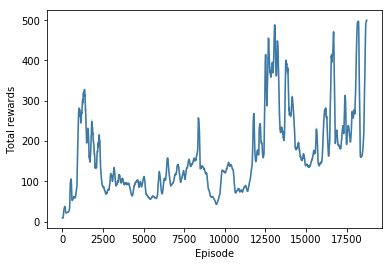

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

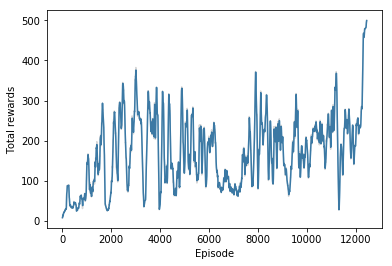

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

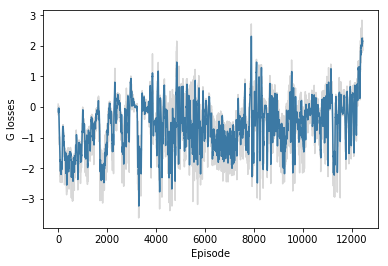

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

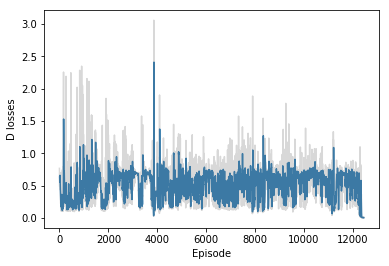

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 487.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.